In [1]:
%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader
#from networks import transform_network_utils

sys.path.append('../neuron')
sys.path.append('../voxelmorph')
import src.losses as vm_losses

gpu_ids = [0]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

import sys
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
import tensorflow as tf
from voxelmorph import dense_3D_spatial_transformer
from keras.models import load_model
 
sys.path.append('../neuron')
import neuron.layers as nrn_layers
import neuron.utils as nrn_utils
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer

start_iter = 20000
# voxelmorph_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_ij_iter20000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': Dense3DSpatialTransformer,
#                    'SpatialTransformer': nrn_layers.SpatialTransformer,
#                    },
#     compile=False,
# )
voxelmorph_model = load_model(
    './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_ij_iter{}.h5'.format(start_iter),
    custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
                    'interp_upsampling': vm_networks.interp_upsampling,
                    'meshgrid': vm_networks.meshgrid,
                    'tf': tf,
                    
                    'VecInt': nrn_layers.VecInt,
                    'SpatialTransformer': nrn_layers.SpatialTransformer,
                    'nrn_utils': nrn_utils,
                    'nrn_layers': nrn_layers,
                   },
    compile=False,
)

Using TensorFlow backend.
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


[(None, 80, 96, 112, 3), (1, 160, 192, 224, 3)]
[(None, 80, 96, 112, 3), (1, 160, 192, 224, 3)]
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


Load training dataset

In [2]:
dataset_key = 'adni-3d-100-unnorm-masked'
import vte_runner
data_params = vte_runner.named_vte_data_params[dataset_key]
    
ds = adni_loader.ADNIDataset(data_params)

vol_shape = tuple(data_params['img_shape'])

# just load some examples so we can get the image size, but actually use a generator later...
(X_unlabeled, _, ids_unlabeled),\
(X_labeled_train, Y_labeled_train, ids_labeled_train), \
(X_labeled_valid, Y_labeled_valid, ids_labeled_valid), \
label_mapping \
= ds.load_dataset(debug=False)

../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Loading adni dataset adni-unnorm-masked_100ul_atlas-l
Params: {'dataset_name': 'adni', 'source_name': 'atl', 'target_name': 'subjs', 'masked': True, 'n_shot': 1, 'use_atlas_as_source': True, 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 100, 'n_validation': 50, 'load_vols': True, 'aug_in_gen': True, 'n_flow_aug': None, 'n_vte_aug': None, 'unnormalized': True, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'n_dims': 3, 'orig_img_shape': (160, 192, 224, 1), 'scale': 1.0, 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_S_1326_base_mri_talairach_orig.npz
ADNI_ADNI-1.5T-FS-5.3-Long_436815.long.094_S_1330_base_mri_talairach_ori

(101, 160, 192, 224, 1)
(1, 160, 192, 224, 1)
(50, 160, 192, 224, 1)
['atlas']
True


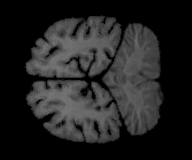

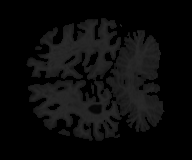

In [3]:
print(X_unlabeled.shape)
print(X_labeled_train.shape)
print(X_labeled_valid.shape)
print(ds.files_labeled_train)
print(ds.params['load_vols'])
import IPython
import PIL
IPython.display.display(PIL.Image.fromarray((X_labeled_train[0, :, :, 64, 0]*255).astype(np.uint8)))
IPython.display.display(PIL.Image.fromarray((X_unlabeled[0, :, :, 64, 0]*255).astype(np.uint8)))


In [4]:
# create diffeomorphic model
sys.path.append('../voxelmorph')
import src.networks as vm_networks
nf_dec = [32, 32, 32, 32, 16, 3]
vm_diffeo_model = vm_networks.miccai2018_bidir(
    (160, 192, 224),
    [16, 32, 32, 32],
    nf_dec,
    bidir=True,
    indexing='ij'
)



[(None, 80, 96, 112, 3), (1, 160, 192, 224, 3)]
[(None, 80, 96, 112, 3), (1, 160, 192, 224, 3)]
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


In [5]:
vm_diffeo_model.summary()
import data_utils
import src.losses as vm_losses

# just train voxelmorph
vm_diffeo_model.compile(
    #loss=['mean_squared_error', vm_losses.gradientLoss('l2')],
    #loss=[vm_losses.cc3D(), vm_losses.gradientLoss('l2')],
    loss=[vm_losses.NCC().loss, vm_losses.NCC().loss, vm_losses.Grad('l2').loss, 'mean_squared_error'],
          #vm_losses.gradientLoss('l2')],
    #loss_weights=[1.0, ,0.01],
    #loss_weights=[1.0, 1.],#0.01],
    loss_weights=[0.5, 0.5, 0.5, 0.],#0.01],
    optimizer=Adam(0.0001)
)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 160, 192, 224 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 112,  880         concatenate_1[0][0]              
__________

In [6]:

# copy weights from regular voxelmorph as initialization
for li, l in enumerate(vm_diffeo_model.layers):
    if l.name.split('_')[0] == voxelmorph_model.layers[li].name.split('_')[0]:  # ignore indexing since somteimes they can get messed up
        print(l.name)
        vm_diffeo_model.layers[li].set_weights(voxelmorph_model.layers[li].get_weights())

input_1
input_2
concatenate_1
conv3d_1
leaky_re_lu_1
conv3d_2
leaky_re_lu_2
conv3d_3
leaky_re_lu_3
conv3d_4
leaky_re_lu_4
conv3d_5
leaky_re_lu_5
up_sampling3d_1
concatenate_2
conv3d_6
leaky_re_lu_6
up_sampling3d_2
concatenate_3
conv3d_7
leaky_re_lu_7
up_sampling3d_3
concatenate_4
conv3d_8
leaky_re_lu_8
conv3d_9
leaky_re_lu_9
flow
lambda_1
flow-int
neg_flow-int
pre_diffflow
neg_pre_diffflow
diffflow
neg_diffflow
spatial_transformer_5
spatial_transformer_6


atlas


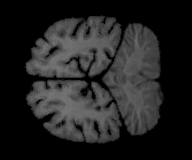

In [7]:
print(ds.files_labeled_train[0])
source_X = ds.X_atlas
#source_X, _ = adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
#source_X = source_X[np.newaxis]
IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))



In [ ]:
print(start_iter)
n_train_iters = 100000
vol_gen = ds.gen_vols_batch(['labeled_train', 'unlabeled_train'], batch_size=1, randomize=True)
print(ds.files_labeled_train + ds.files_unlabeled_train)
#vol_gen = data_utils.gen_batch(X_unlabeled, X_unlabeled, batch_size=1, randomize=True)
target_X, _ = next(vol_gen)
zeros_flow = np.zeros(target_X.shape[:-1] + (3,))

for bi in range(n_train_iters + 1):
    
    target_X, _ = next(vol_gen)
    vm_losses = vm_diffeo_model.train_on_batch([source_X, target_X], [target_X, source_X, zeros_flow, zeros_flow])
    print('Iter {}, loss {}'.format(bi, vm_losses))
    
    if bi > 0 and bi % 2000 == 0:
        vm_diffeo_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_100k_bidir_ij_iter{}.h5'.format(start_iter + bi))

20000
['atlas', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_263697.long.153_S_4077_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_223532.long.153_S_2109_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_76615.long.021_S_0984_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_451346.long.009_S_0751_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100329_NW33DK_FS_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_282668.long.002_S_4270_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_110314_JD99RH_FS_mri_talairach_orig.npz', '/da

Iter 0, loss [-0.19391958, -0.1906493, -0.2211963, 0.024006424, 1.9288852]
Iter 1, loss [-0.19407578, -0.19552346, -0.22022785, 0.027599765, 2.1428545]
Iter 2, loss [-0.1973008, -0.195597, -0.22221707, 0.02321246, 2.1392603]
Iter 3, loss [-0.20966385, -0.21102092, -0.23273906, 0.024432264, 1.6818155]
Iter 4, loss [-0.21276245, -0.22961831, -0.22578478, 0.0298782, 3.292299]
Iter 5, loss [-0.19803883, -0.19299115, -0.22573231, 0.022645798, 1.6106762]
Iter 6, loss [-0.20488206, -0.2051393, -0.22849168, 0.023866847, 1.7988254]
Iter 7, loss [-0.19380182, -0.19175, -0.22458099, 0.028727338, 2.2454863]
Iter 8, loss [-0.20597582, -0.20554635, -0.23092002, 0.024514742, 1.4361523]
Iter 9, loss [-0.20927154, -0.21056658, -0.23352376, 0.025547255, 2.060569]
Iter 10, loss [-0.21756227, -0.2534313, -0.21966642, 0.037973166, 5.5040274]
Iter 11, loss [-0.21106449, -0.22902636, -0.224751, 0.031648383, 3.5518577]
Iter 12, loss [-0.20974989, -0.20903468, -0.2358222, 0.025357101, 1.8291336]
Iter 13, loss 

Iter 107, loss [-0.20910534, -0.21047466, -0.2338507, 0.026114678, 1.7928644]
Iter 108, loss [-0.19012497, -0.19471793, -0.21893777, 0.033405744, 2.010574]
Iter 109, loss [-0.19821918, -0.19388917, -0.23085439, 0.028305199, 2.4044948]
Iter 110, loss [-0.18996896, -0.19476354, -0.21866462, 0.03349024, 2.0041733]
Iter 111, loss [-0.19968867, -0.19887805, -0.23122703, 0.03072774, 2.3059275]
Iter 112, loss [-0.20281804, -0.20430928, -0.22980481, 0.028478023, 1.8468786]
Iter 113, loss [-0.19907856, -0.20703901, -0.22312473, 0.032006633, 1.8624648]
Iter 114, loss [-0.22421329, -0.2544106, -0.23036033, 0.036344342, 3.644856]
Iter 115, loss [-0.20263962, -0.2021558, -0.22846688, 0.025343461, 1.599482]
Iter 116, loss [-0.21199541, -0.21054706, -0.24062876, 0.02718499, 1.6426228]
Iter 117, loss [-0.20778412, -0.24945773, -0.21232729, 0.04621678, 8.214132]
Iter 118, loss [-0.33788997, -0.3411781, -0.33814186, 0.003540054, 0.3056382]
Iter 119, loss [-0.19912972, -0.20690086, -0.22334798, 0.0319894

Iter 212, loss [-0.2131164, -0.24441501, -0.22025882, 0.038441017, 4.0721116]
Iter 213, loss [-0.20001681, -0.19693643, -0.23147336, 0.028376173, 2.1557689]
Iter 214, loss [-0.18399587, -0.18267877, -0.21769369, 0.032380715, 2.2952347]
Iter 215, loss [-0.1963582, -0.19598392, -0.22846253, 0.031730067, 2.4372613]
Iter 216, loss [-0.22218558, -0.22166966, -0.24905299, 0.026351493, 1.917773]
Iter 217, loss [-0.19718914, -0.20337658, -0.2236378, 0.0326361, 2.3363287]
Iter 218, loss [-0.2189935, -0.25780824, -0.22256288, 0.04238411, 5.947898]
Iter 219, loss [-0.20212033, -0.20219901, -0.22955959, 0.027517915, 1.771585]
Iter 220, loss [-0.20305508, -0.20884912, -0.2292174, 0.031956356, 2.0662777]
Iter 221, loss [-0.20333233, -0.20564629, -0.229543, 0.028524635, 2.0083792]
Iter 222, loss [-0.20466852, -0.24606384, -0.20917638, 0.045903187, 6.8535213]
Iter 223, loss [-0.19970956, -0.19784889, -0.2276835, 0.026113257, 1.8318099]
Iter 224, loss [-0.21253067, -0.24546455, -0.22000809, 0.040411294

Iter 318, loss [-0.19694716, -0.19835763, -0.22887217, 0.033335462, 2.197584]
Iter 319, loss [-0.19715373, -0.20048384, -0.22786884, 0.03404522, 2.2027159]
Iter 320, loss [-0.19626398, -0.19151749, -0.23148687, 0.030476397, 2.569422]
Iter 321, loss [-0.20168953, -0.19865084, -0.23579223, 0.031063996, 2.2867846]
Iter 322, loss [-0.21307181, -0.21267264, -0.2416739, 0.02820291, 1.6592379]
Iter 323, loss [-0.21187937, -0.21156488, -0.23915316, 0.02695929, 1.5341835]
Iter 324, loss [-0.20002186, -0.19758126, -0.22820988, 0.025747417, 1.7601817]
Iter 325, loss [-0.21522869, -0.21686287, -0.2404835, 0.026889008, 1.6890596]
Iter 326, loss [-0.21124098, -0.2112524, -0.23907344, 0.0278439, 1.7815192]
Iter 327, loss [-0.20180306, -0.1985968, -0.22897795, 0.023968622, 1.9546238]
Iter 328, loss [-0.18340883, -0.18334047, -0.21188082, 0.028403647, 2.3900301]
Iter 329, loss [-0.21405052, -0.24524683, -0.22324379, 0.04038956, 4.882603]
Iter 330, loss [-0.21555269, -0.21661761, -0.24235883, 0.02787105

Iter 423, loss [-0.22082554, -0.24282768, -0.23095842, 0.032135043, 2.3739138]
Iter 424, loss [-0.19921964, -0.19395953, -0.23441847, 0.029938687, 2.41285]
Iter 425, loss [-0.20559204, -0.20699428, -0.23060517, 0.026415376, 1.767397]
Iter 426, loss [-0.19729605, -0.20007706, -0.22798455, 0.033469513, 2.1496654]
Iter 427, loss [-0.19089803, -0.19237964, -0.21843758, 0.029021155, 1.9068639]
Iter 428, loss [-0.20149297, -0.2030979, -0.22995128, 0.030063238, 1.9154503]
Iter 429, loss [-0.22038497, -0.22091925, -0.24718195, 0.027331267, 1.8904188]
Iter 430, loss [-0.2098198, -0.21177475, -0.2354858, 0.027620982, 1.7517207]
Iter 431, loss [-0.20442948, -0.2008699, -0.23619674, 0.028207704, 2.1627176]
Iter 432, loss [-0.20458485, -0.20096914, -0.23622333, 0.028022757, 2.1747277]
Iter 433, loss [-0.20308545, -0.20260262, -0.23136099, 0.027792703, 1.8083367]
Iter 434, loss [-0.21304522, -0.21446711, -0.23849587, 0.026872542, 1.8247992]
Iter 435, loss [-0.19664869, -0.19209342, -0.23036435, 0.02

Iter 529, loss [-0.22891018, -0.2617296, -0.23418581, 0.038095042, 3.8445737]
Iter 530, loss [-0.21248162, -0.2306631, -0.22725792, 0.032957777, 2.8893034]
Iter 531, loss [-0.19940826, -0.19938527, -0.23025677, 0.0308255, 2.2416325]
Iter 532, loss [-0.2034227, -0.20994931, -0.22984423, 0.03294815, 2.1078103]
Iter 533, loss [-0.20123057, -0.20333779, -0.22970371, 0.030580372, 2.06396]
Iter 534, loss [-0.2043045, -0.20140994, -0.23740622, 0.030207157, 2.085955]
Iter 535, loss [-0.1979677, -0.1981731, -0.22646716, 0.028704887, 1.9176424]
Iter 536, loss [-0.20121568, -0.1988799, -0.23349325, 0.029941782, 2.185624]
Iter 537, loss [-0.19678435, -0.19689728, -0.22706755, 0.030396122, 1.9113337]
Iter 538, loss [-0.21530357, -0.21601361, -0.241676, 0.027082464, 1.3601563]
Iter 539, loss [-0.21120879, -0.2109371, -0.23802114, 0.026540652, 1.3479002]
Iter 540, loss [-0.2001018, -0.19970256, -0.2311219, 0.030620873, 2.1362114]
Iter 541, loss [-0.20312445, -0.20401964, -0.23229444, 0.03006517, 1.98

Iter 634, loss [-0.22154343, -0.22185387, -0.24931544, 0.028082442, 1.936828]
Iter 635, loss [-0.21464446, -0.24729869, -0.22239575, 0.040405516, 3.9753718]
Iter 636, loss [-0.20710945, -0.21184126, -0.22983585, 0.027458189, 1.7824389]
Iter 637, loss [-0.2047538, -0.20818952, -0.23020792, 0.028889846, 1.9878978]
Iter 638, loss [-0.2041979, -0.20702924, -0.23276468, 0.031398114, 2.427589]
Iter 639, loss [-0.19603337, -0.19333057, -0.22928353, 0.03054734, 2.8090556]
Iter 640, loss [-0.19610259, -0.19334403, -0.2295199, 0.030658765, 2.8477798]
Iter 641, loss [-0.21010537, -0.21042062, -0.23715608, 0.027365949, 1.8108144]
Iter 642, loss [-0.19657312, -0.19161987, -0.23185907, 0.030332722, 2.7201946]
Iter 643, loss [-0.21834207, -0.25654116, -0.22175132, 0.04160835, 5.7425847]
Iter 644, loss [-0.20430458, -0.20308721, -0.23546416, 0.029942213, 2.2174113]
Iter 645, loss [-0.19863777, -0.19610022, -0.22810005, 0.02692473, 1.9361839]
Iter 646, loss [-0.19662379, -0.194325, -0.23085828, 0.03193

Iter 739, loss [-0.20790775, -0.20555085, -0.23718171, 0.026917083, 1.8262882]
Iter 740, loss [-0.19882637, -0.19354251, -0.23404483, 0.0299346, 2.4696033]
Iter 741, loss [-0.21017233, -0.21310526, -0.2361093, 0.02886993, 2.1263204]
Iter 742, loss [-0.20318595, -0.20562239, -0.23168623, 0.030936709, 1.9652098]
Iter 743, loss [-0.19972841, -0.20924005, -0.22537884, 0.035162054, 1.9851856]
Iter 744, loss [-0.21356654, -0.2459141, -0.22407265, 0.042853665, 4.9106026]
Iter 745, loss [-0.2099254, -0.21066737, -0.23954709, 0.030363655, 1.9987361]
Iter 746, loss [-0.20843777, -0.20705006, -0.23783329, 0.028007805, 1.7837325]
Iter 747, loss [-0.22914673, -0.2299347, -0.2546363, 0.026277501, 1.5568435]
Iter 748, loss [-0.20340349, -0.20555486, -0.23181695, 0.030564811, 1.8557739]
Iter 749, loss [-0.19957723, -0.19918601, -0.22739735, 0.027428888, 1.7781775]
Iter 750, loss [-0.18979622, -0.19340277, -0.22183454, 0.035644867, 2.436163]
Iter 751, loss [-0.21336861, -0.20985018, -0.24433526, 0.0274

Iter 844, loss [-0.20629227, -0.2091719, -0.23191202, 0.02849937, 2.0323424]
Iter 845, loss [-0.19330752, -0.1945431, -0.22309445, 0.031022504, 2.159182]
Iter 846, loss [-0.18886015, -0.19218157, -0.22065671, 0.035118, 2.2977135]
Iter 847, loss [-0.19763274, -0.19280268, -0.23258074, 0.03011792, 2.2756498]
Iter 848, loss [-0.2100134, -0.21203701, -0.23627988, 0.028290076, 1.7782625]
Iter 849, loss [-0.21274024, -0.21469912, -0.23883031, 0.028048947, 1.4940094]
Iter 850, loss [-0.22947043, -0.23036684, -0.25514072, 0.02656669, 1.7873514]
Iter 851, loss [-0.205067, -0.23074725, -0.21787186, 0.038485132, 4.045514]
Iter 852, loss [-0.20303082, -0.20560378, -0.23216888, 0.031711016, 2.1027105]
Iter 853, loss [-0.19675049, -0.20027266, -0.22789942, 0.03467109, 2.2173457]
Iter 854, loss [-0.22241935, -0.25368962, -0.22909921, 0.037950125, 3.0069735]
Iter 855, loss [-0.20370138, -0.24631478, -0.20888211, 0.04779414, 6.444436]
Iter 856, loss [-0.21414149, -0.21106233, -0.24531521, 0.02809456, 1

Iter 950, loss [-0.19975173, -0.20855755, -0.2253548, 0.034408852, 1.9465898]
Iter 951, loss [-0.21498457, -0.21743266, -0.24112998, 0.028593501, 1.6146579]
Iter 952, loss [-0.2138414, -0.21899961, -0.24002098, 0.031337794, 1.6724339]
Iter 953, loss [-0.20106089, -0.1988407, -0.23392542, 0.030644318, 2.2396176]
Iter 954, loss [-0.21001351, -0.21030001, -0.24054152, 0.03081454, 1.9870805]
Iter 955, loss [-0.19668865, -0.1973042, -0.23014832, 0.034075193, 2.4859898]
Iter 956, loss [-0.22012696, -0.22064641, -0.24755587, 0.027948372, 1.9863309]
Iter 957, loss [-0.2297634, -0.24519964, -0.24483879, 0.030511629, 1.7377765]
Iter 958, loss [-0.2030389, -0.20387866, -0.2322186, 0.030019447, 2.0834785]
Iter 959, loss [-0.22945894, -0.24503756, -0.24418475, 0.030304398, 1.7181172]
Iter 960, loss [-0.17658475, -0.17839201, -0.2148125, 0.040035006, 2.9645143]
Iter 961, loss [-0.19115074, -0.19485791, -0.2237714, 0.03632781, 2.5962536]
Iter 962, loss [-0.20215987, -0.19945487, -0.2366562, 0.0317913

Iter 1055, loss [-0.1994663, -0.19943649, -0.2281673, 0.028671183, 1.9353802]
Iter 1056, loss [-0.21014309, -0.21234994, -0.23551784, 0.027581606, 1.9561454]
Iter 1057, loss [-0.19577824, -0.19632776, -0.22551112, 0.030282421, 2.0231373]
Iter 1058, loss [-0.2104003, -0.20997097, -0.23922724, 0.028397579, 1.7336076]
Iter 1059, loss [-0.19608893, -0.19320045, -0.2292073, 0.030229904, 2.1883848]
Iter 1060, loss [-0.20647272, -0.20968758, -0.2315886, 0.028330728, 1.6636889]
Iter 1061, loss [-0.20364803, -0.20323746, -0.2343907, 0.030332094, 2.1041315]
Iter 1062, loss [-0.18369983, -0.18435389, -0.21895348, 0.035907708, 2.545559]
Iter 1063, loss [-0.18803373, -0.19283745, -0.2216368, 0.03840678, 2.8137643]
Iter 1064, loss [-0.20013665, -0.19750698, -0.2284731, 0.025706798, 1.7520106]
Iter 1065, loss [-0.18395573, -0.18394753, -0.21833552, 0.034371614, 2.3159077]
Iter 1066, loss [-0.20678498, -0.21062261, -0.23371895, 0.03077158, 1.9310535]
Iter 1067, loss [-0.19988692, -0.19800417, -0.23140

Iter 1159, loss [-0.21106039, -0.21235324, -0.24012284, 0.030355318, 1.7293909]
Iter 1160, loss [-0.2127722, -0.23122942, -0.22859524, 0.034280274, 2.8022182]
Iter 1161, loss [-0.213865, -0.23463915, -0.22936288, 0.036272015, 3.1850345]
Iter 1162, loss [-0.20327674, -0.2085176, -0.23295742, 0.034921553, 2.3837621]
Iter 1163, loss [-0.20337273, -0.20617527, -0.23136637, 0.03079616, 1.8553175]
Iter 1164, loss [-0.20695005, -0.2032592, -0.23815519, 0.027514268, 1.8364432]
Iter 1165, loss [-0.22011772, -0.22094007, -0.24748622, 0.028190857, 1.842765]
Iter 1166, loss [-0.1960786, -0.19340728, -0.23081465, 0.032064736, 2.0697756]
Iter 1167, loss [-0.19929868, -0.19968978, -0.23270145, 0.033793874, 2.3841486]
Iter 1168, loss [-0.22098589, -0.22156326, -0.24825625, 0.027847743, 1.8565578]
Iter 1169, loss [-0.2131432, -0.21233891, -0.24312034, 0.02917285, 1.70718]
Iter 1170, loss [-0.20063084, -0.20036452, -0.22872898, 0.027831808, 1.7757218]
Iter 1171, loss [-0.20013902, -0.20933208, -0.225315

Iter 1263, loss [-0.21397564, -0.24718948, -0.22207034, 0.041308533, 3.688833]
Iter 1264, loss [-0.22923772, -0.24577606, -0.24418306, 0.031483676, 1.8622296]
Iter 1265, loss [-0.18958868, -0.19707383, -0.21985674, 0.037753195, 2.4291706]
Iter 1266, loss [-0.33603013, -0.3400571, -0.33613768, 0.0041345647, 0.4603278]
Iter 1267, loss [-0.20259486, -0.20217638, -0.23311667, 0.030103322, 2.4084282]
Iter 1268, loss [-0.21307401, -0.21446654, -0.23957221, 0.027890708, 1.789491]
Iter 1269, loss [-0.20015118, -0.19682121, -0.23024245, 0.026761284, 1.4943205]
Iter 1270, loss [-0.21131676, -0.21078649, -0.23836122, 0.026514169, 1.2267991]
Iter 1271, loss [-0.20620167, -0.201814, -0.23765758, 0.027068226, 1.6633521]
Iter 1272, loss [-0.20832896, -0.2069644, -0.23784204, 0.028148523, 1.717879]
Iter 1273, loss [-0.20519985, -0.20792839, -0.23089038, 0.028419038, 1.8549411]
Iter 1274, loss [-0.19840522, -0.19645093, -0.22750553, 0.027146012, 1.9327905]
Iter 1275, loss [-0.21726292, -0.2565627, -0.2

Iter 1367, loss [-0.20163253, -0.20394269, -0.23046039, 0.031138008, 1.9929388]
Iter 1368, loss [-0.21538517, -0.21680386, -0.24293792, 0.028971445, 1.6421467]
Iter 1369, loss [-0.2018271, -0.19972646, -0.23498128, 0.031053584, 2.4273813]
Iter 1370, loss [-0.22514337, -0.25752768, -0.23247132, 0.039712247, 3.5184045]
Iter 1371, loss [-0.20599052, -0.2102501, -0.23243888, 0.030707931, 1.9696972]
Iter 1372, loss [-0.22175774, -0.26243138, -0.22546013, 0.044376, 5.194008]
Iter 1373, loss [-0.21610616, -0.21900046, -0.24232726, 0.029115422, 1.6990299]
Iter 1374, loss [-0.20019633, -0.1977691, -0.22966075, 0.027037214, 1.9160845]
Iter 1375, loss [-0.21164764, -0.21537474, -0.2379084, 0.029987838, 2.0772624]
Iter 1376, loss [-0.20896122, -0.20778656, -0.23874232, 0.028606456, 1.857042]
Iter 1377, loss [-0.21267207, -0.232169, -0.22999765, 0.036822535, 3.7060218]
Iter 1378, loss [-0.21833679, -0.21841694, -0.24631475, 0.028058102, 1.622039]
Iter 1379, loss [-0.2139833, -0.2132322, -0.24323553

Iter 1471, loss [-0.19973096, -0.20899077, -0.22492816, 0.034457, 1.7750734]
Iter 1472, loss [-0.19649212, -0.19442815, -0.23037495, 0.031818837, 2.566402]
Iter 1473, loss [-0.21274331, -0.21501897, -0.23940139, 0.028933734, 1.5114981]
Iter 1474, loss [-0.20328519, -0.20892592, -0.23418891, 0.036544453, 2.5289965]
Iter 1475, loss [-0.21212135, -0.21161239, -0.24281491, 0.030184586, 1.884437]
Iter 1476, loss [-0.19958878, -0.1998327, -0.22859618, 0.029251326, 1.9387517]
Iter 1477, loss [-0.21558575, -0.21466768, -0.2439968, 0.027492974, 1.7099292]
Iter 1478, loss [-0.21497312, -0.2163359, -0.24180916, 0.028198794, 1.5721517]
Iter 1479, loss [-0.19909702, -0.19911507, -0.22747563, 0.028396627, 2.0211046]
Iter 1480, loss [-0.22273272, -0.22254257, -0.24998848, 0.027065605, 1.7110474]
Iter 1481, loss [-0.19086938, -0.19457352, -0.2232066, 0.03604134, 2.48037]
Iter 1482, loss [-0.20851183, -0.21150953, -0.2345022, 0.028988048, 1.9414644]
Iter 1483, loss [-0.19046262, -0.19439805, -0.2163075

Iter 1575, loss [-0.2135682, -0.21445298, -0.24139015, 0.028706755, 1.6869042]
Iter 1576, loss [-0.20189488, -0.20491749, -0.2315456, 0.032673325, 1.8006357]
Iter 1577, loss [-0.21678159, -0.25069994, -0.22523166, 0.042368412, 4.0091987]
Iter 1578, loss [-0.20971073, -0.20809332, -0.24118437, 0.029856227, 1.7361338]
Iter 1579, loss [-0.20181149, -0.20002292, -0.23449054, 0.030890463, 2.218463]
Iter 1580, loss [-0.2040788, -0.20520025, -0.23118816, 0.028230846, 1.7564745]
Iter 1581, loss [-0.22324677, -0.2237528, -0.25082722, 0.028086482, 1.9224243]
Iter 1582, loss [-0.19164997, -0.19591872, -0.22425517, 0.03687393, 2.7458127]
Iter 1583, loss [-0.21310598, -0.21285984, -0.24295501, 0.029602876, 1.8855444]
Iter 1584, loss [-0.19992808, -0.19560198, -0.23569001, 0.031435832, 2.7253945]
Iter 1585, loss [-0.20913348, -0.20790258, -0.23884751, 0.028483137, 2.1001563]
Iter 1586, loss [-0.2022859, -0.200927, -0.23169453, 0.028049735, 2.0653245]
Iter 1587, loss [-0.17883421, -0.22343743, -0.191

Iter 1679, loss [-0.2156504, -0.21812174, -0.24304588, 0.029866856, 1.6837775]
Iter 1680, loss [-0.19747233, -0.198788, -0.22674203, 0.030585334, 2.0455422]
Iter 1681, loss [-0.16945562, -0.21163896, -0.1818891, 0.0546168, 5.106761]
Iter 1682, loss [-0.21286586, -0.21334077, -0.24162196, 0.029231008, 1.8353918]
Iter 1683, loss [-0.19896767, -0.20941286, -0.22491828, 0.036395784, 2.123538]
Iter 1684, loss [-0.18855374, -0.19317779, -0.21475843, 0.030828742, 1.9538174]
Iter 1685, loss [-0.21344322, -0.21274385, -0.242935, 0.028792422, 1.8293625]
Iter 1686, loss [-0.203669, -0.20297135, -0.2333694, 0.029002747, 2.1972344]
Iter 1687, loss [-0.22658962, -0.25908357, -0.23272897, 0.038633272, 2.935045]
Iter 1688, loss [-0.21481399, -0.21692823, -0.24224097, 0.02954122, 1.7856975]
Iter 1689, loss [-0.2004602, -0.19903432, -0.2333456, 0.031459507, 2.5095067]
Iter 1690, loss [-0.20485157, -0.20356123, -0.23814598, 0.032004073, 2.1944387]
Iter 1691, loss [-0.20524669, -0.20690592, -0.22992928, 0

Iter 1783, loss [-0.2044791, -0.21167861, -0.2319608, 0.034681197, 2.084966]
Iter 1784, loss [-0.22279403, -0.2645012, -0.22713307, 0.04604622, 5.4524875]
Iter 1785, loss [-0.21616538, -0.21953534, -0.24273679, 0.02994134, 1.6256282]
Iter 1786, loss [-0.20449491, -0.20406546, -0.23421305, 0.029288683, 2.0071025]
Iter 1787, loss [-0.23040046, -0.23187794, -0.25618333, 0.027260333, 1.5572953]
Iter 1788, loss [-0.1968966, -0.19469626, -0.2316864, 0.03258946, 2.017974]
Iter 1789, loss [-0.2083689, -0.20492083, -0.24000692, 0.028189965, 1.9634267]
Iter 1790, loss [-0.21630959, -0.21647736, -0.24556568, 0.029423853, 1.8456887]
Iter 1791, loss [-0.19460657, -0.19690132, -0.22513628, 0.03282444, 2.4380026]
Iter 1792, loss [-0.20447406, -0.20755969, -0.2334291, 0.03204065, 2.015114]
Iter 1793, loss [-0.20880073, -0.20512962, -0.2406594, 0.028187558, 1.982794]
Iter 1794, loss [-0.20537777, -0.20324391, -0.23898293, 0.031471282, 1.9622707]
Iter 1795, loss [-0.19338648, -0.19981357, -0.22058776, 0

Iter 1887, loss [-0.20507616, -0.20460394, -0.23433428, 0.028785892, 2.0679896]
Iter 1888, loss [-0.20382012, -0.20411818, -0.23314302, 0.029620951, 1.8050508]
Iter 1889, loss [-0.19152352, -0.19368711, -0.21928914, 0.029929234, 1.8723133]
Iter 1890, loss [-0.21234518, -0.21035372, -0.24354741, 0.029210752, 1.8518234]
Iter 1891, loss [-0.20047247, -0.1957613, -0.23659667, 0.03141301, 2.5163298]
Iter 1892, loss [-0.20462738, -0.20540063, -0.23193939, 0.028085258, 1.7118179]
Iter 1893, loss [-0.1977316, -0.19323415, -0.23357324, 0.031344205, 2.6506042]
Iter 1894, loss [-0.2092934, -0.2082567, -0.23910297, 0.028772894, 1.9875828]
Iter 1895, loss [-0.19835104, -0.19542952, -0.2326143, 0.031341724, 2.5089877]
Iter 1896, loss [-0.22575109, -0.25856104, -0.23297457, 0.040033426, 3.6632652]
Iter 1897, loss [-0.200961, -0.20165999, -0.23266569, 0.032403715, 2.2597573]
Iter 1898, loss [-0.22979935, -0.24609974, -0.24497862, 0.03147968, 1.6092762]
Iter 1899, loss [-0.20263675, -0.20035598, -0.236

Iter 1991, loss [-0.20902185, -0.23689312, -0.22120535, 0.04005477, 3.5801091]
Iter 1992, loss [-0.2150346, -0.22052881, -0.24203184, 0.03249145, 1.8083743]
Iter 1993, loss [-0.19712119, -0.1935323, -0.23229718, 0.031587105, 2.37376]
Iter 1994, loss [-0.21367998, -0.21459927, -0.24158448, 0.028823754, 1.794794]
Iter 1995, loss [-0.20563862, -0.20329459, -0.23910937, 0.031126752, 1.8884982]
Iter 1996, loss [-0.21281196, -0.2126065, -0.24306634, 0.03004895, 1.6010144]
Iter 1997, loss [-0.20030919, -0.20084795, -0.23202437, 0.03225396, 2.276333]
Iter 1998, loss [-0.1912965, -0.197715, -0.22184888, 0.036970876, 2.0546825]
Iter 1999, loss [-0.22190909, -0.26289013, -0.22631554, 0.045387484, 5.5568237]
Iter 2000, loss [-0.18658412, -0.19351825, -0.21308059, 0.033430606, 2.3041537]
Iter 2001, loss [-0.19776988, -0.20535317, -0.22586067, 0.035674106, 2.1421916]
Iter 2002, loss [-0.21603727, -0.21773681, -0.24403657, 0.029698856, 1.576055]
Iter 2003, loss [-0.20541175, -0.21255726, -0.23297201,

Iter 2095, loss [-0.20403959, -0.20549765, -0.2327428, 0.030161288, 1.8340173]
Iter 2096, loss [-0.20226601, -0.2055904, -0.23229328, 0.033351664, 2.0414653]
Iter 2097, loss [-0.19746132, -0.19864057, -0.2315074, 0.035225336, 2.5049584]
Iter 2098, loss [-0.20328897, -0.20163451, -0.23141764, 0.026474193, 1.8016137]
Iter 2099, loss [-0.20835905, -0.2046362, -0.24041718, 0.02833531, 1.9231685]
Iter 2100, loss [-0.21500252, -0.21187791, -0.24690431, 0.02877718, 1.7676332]
Iter 2101, loss [-0.20442666, -0.2070683, -0.23378465, 0.03199961, 1.8768438]
Iter 2102, loss [-0.19436952, -0.20059925, -0.22210526, 0.033965483, 1.9425853]
Iter 2103, loss [-0.19799791, -0.2021754, -0.22787826, 0.034057822, 2.1263943]
Iter 2104, loss [-0.21375394, -0.21164785, -0.24479769, 0.028937658, 1.6679878]
Iter 2105, loss [-0.2100759, -0.2084607, -0.24154472, 0.029853601, 1.7380134]
Iter 2106, loss [-0.2032042, -0.20068675, -0.23810878, 0.03238713, 2.137907]
Iter 2107, loss [-0.20402601, -0.20447244, -0.23359591

Iter 2199, loss [-0.21445315, -0.21640247, -0.24113303, 0.028629214, 1.7602897]
Iter 2200, loss [-0.185426, -0.1927949, -0.21207735, 0.03402026, 2.2585263]
Iter 2201, loss [-0.19997238, -0.19594789, -0.23635948, 0.032362606, 2.4847019]
Iter 2202, loss [-0.1840291, -0.18552765, -0.21362743, 0.031096883, 2.026979]
Iter 2203, loss [-0.19734867, -0.19588318, -0.2322154, 0.033401262, 2.8349621]
Iter 2204, loss [-0.20801562, -0.2045327, -0.24014884, 0.028650269, 1.8620571]
Iter 2205, loss [-0.20489694, -0.20233443, -0.2358405, 0.028381048, 1.7751721]
Iter 2206, loss [-0.20514916, -0.20234546, -0.23811544, 0.030162593, 2.0116]
Iter 2207, loss [-0.2039405, -0.20972426, -0.23470645, 0.03654971, 2.3253548]
Iter 2208, loss [-0.1978332, -0.19645041, -0.23190744, 0.03269144, 2.6481802]
Iter 2209, loss [-0.22157922, -0.2452297, -0.23202123, 0.034092486, 2.334958]
Iter 2210, loss [-0.20320934, -0.20157675, -0.23093475, 0.026092827, 1.7381268]
Iter 2211, loss [-0.20054431, -0.21130115, -0.22636239, 0.

Iter 2303, loss [-0.20856589, -0.2078416, -0.2385368, 0.02924662, 1.965202]
Iter 2304, loss [-0.20129228, -0.20405513, -0.23036069, 0.03183125, 2.1130476]
Iter 2305, loss [-0.19830802, -0.19544296, -0.23263495, 0.031461872, 2.5810611]
Iter 2306, loss [-0.19783428, -0.20192443, -0.22902316, 0.03527903, 2.3046923]
Iter 2307, loss [-0.20178008, -0.19952622, -0.23162638, 0.027592419, 1.6921756]
Iter 2308, loss [-0.20106557, -0.20153196, -0.22799915, 0.027399957, 1.7701721]
Iter 2309, loss [-0.21861905, -0.21937686, -0.24568327, 0.027822018, 1.6080701]
Iter 2310, loss [-0.20213872, -0.20139328, -0.23099461, 0.028110448, 1.7815698]
Iter 2311, loss [-0.20706779, -0.21128184, -0.2352099, 0.03235615, 2.1460905]
Iter 2312, loss [-0.21235451, -0.21158299, -0.24303165, 0.02990561, 1.8316033]
Iter 2313, loss [-0.19181804, -0.19447751, -0.22060321, 0.03144464, 2.0142388]
Iter 2314, loss [-0.20478633, -0.2116617, -0.23295781, 0.035046857, 2.1363697]
Iter 2315, loss [-0.21626182, -0.21735887, -0.24442

Iter 2407, loss [-0.20259205, -0.2005285, -0.23329984, 0.02864426, 1.7680817]
Iter 2408, loss [-0.1977266, -0.19427565, -0.23278934, 0.031611763, 2.4120607]
Iter 2409, loss [-0.18453798, -0.1860703, -0.21406516, 0.031059518, 2.105095]
Iter 2410, loss [-0.19760618, -0.19844395, -0.22866161, 0.03189321, 2.0522597]
Iter 2411, loss [-0.21352786, -0.21330303, -0.24397503, 0.030222371, 1.7740312]
Iter 2412, loss [-0.20543954, -0.21243072, -0.23293127, 0.03448291, 2.1530933]
Iter 2413, loss [-0.21394804, -0.21339326, -0.24471807, 0.030215278, 1.8504554]
Iter 2414, loss [-0.20230195, -0.205274, -0.23212846, 0.03279856, 1.9858736]
Iter 2415, loss [-0.17651542, -0.17893471, -0.21580076, 0.041704632, 3.06458]
Iter 2416, loss [-0.20549133, -0.20928489, -0.23537494, 0.033677157, 2.3019154]
Iter 2417, loss [-0.20885406, -0.21287188, -0.23557064, 0.030734383, 1.9152362]
Iter 2418, loss [-0.19753325, -0.19875851, -0.23123202, 0.034924023, 2.3593583]
Iter 2419, loss [-0.20853515, -0.23615026, -0.220739

Iter 2511, loss [-0.20582743, -0.21094324, -0.23242418, 0.03171255, 1.7093943]
Iter 2512, loss [-0.19622017, -0.19395643, -0.23140092, 0.032916985, 1.8954775]
Iter 2513, loss [-0.21100895, -0.21051674, -0.24170206, 0.030200904, 1.455944]
Iter 2514, loss [-0.1779347, -0.22244395, -0.18996781, 0.056542348, 7.0917525]
Iter 2515, loss [-0.21458836, -0.21683079, -0.24163495, 0.029289035, 1.541175]
Iter 2516, loss [-0.19337955, -0.19574158, -0.22363867, 0.03262114, 2.34982]
Iter 2517, loss [-0.19569309, -0.19975665, -0.22547218, 0.033842664, 2.261161]
Iter 2518, loss [-0.21339054, -0.21617526, -0.2398647, 0.029258883, 1.9115441]
Iter 2519, loss [-0.19839643, -0.19607693, -0.23278715, 0.032071203, 2.5175862]
Iter 2520, loss [-0.19320038, -0.20041151, -0.2207626, 0.034773357, 2.2047808]
Iter 2521, loss [-0.18408507, -0.18591492, -0.21382435, 0.031569123, 2.3947322]
Iter 2522, loss [-0.18448791, -0.18618785, -0.21416274, 0.031374767, 2.3823755]
Iter 2523, loss [-0.20325808, -0.24832241, -0.2112

Iter 2615, loss [-0.21176296, -0.21312122, -0.24090266, 0.030497968, 1.5626212]
Iter 2616, loss [-0.19218212, -0.19498827, -0.2206227, 0.031246718, 1.876148]
Iter 2617, loss [-0.19759484, -0.19861911, -0.22910047, 0.032529928, 2.0503488]
Iter 2618, loss [-0.2211187, -0.22236502, -0.24809486, 0.028222477, 1.8888372]
Iter 2619, loss [-0.17657442, -0.18012941, -0.21549268, 0.042473238, 3.0867722]
Iter 2620, loss [-0.20944747, -0.20812085, -0.24041519, 0.029641107, 1.8013908]
Iter 2621, loss [-0.3346066, -0.33855784, -0.33507866, 0.004423318, 0.27029303]
Iter 2622, loss [-0.21265818, -0.21017598, -0.24359037, 0.028449975, 1.5705719]
Iter 2623, loss [-0.20271137, -0.20173845, -0.23223776, 0.028553447, 1.6251285]
Iter 2624, loss [-0.19635957, -0.19750264, -0.23026907, 0.035052575, 2.1696908]
Iter 2625, loss [-0.19098578, -0.19492799, -0.2246484, 0.037604842, 2.3915443]
Iter 2626, loss [-0.20391291, -0.2035841, -0.23367807, 0.029436355, 2.065509]
Iter 2627, loss [-0.1938309, -0.19617829, -0.2

Iter 2719, loss [-0.19696254, -0.19815546, -0.22836654, 0.032596935, 1.9562615]
Iter 2720, loss [-0.20253417, -0.20530285, -0.23182364, 0.032058157, 1.909012]
Iter 2721, loss [-0.18748681, -0.18913117, -0.22365339, 0.03781095, 2.4984503]
Iter 2722, loss [-0.1948603, -0.19759999, -0.22580306, 0.033682458, 2.3025835]
Iter 2723, loss [-0.20684037, -0.21015775, -0.23298274, 0.029459773, 1.8826745]
Iter 2724, loss [-0.2310493, -0.23281631, -0.25705755, 0.027775254, 1.6357177]
Iter 2725, loss [-0.20462488, -0.2105148, -0.23548923, 0.03675429, 2.4358456]
Iter 2726, loss [-0.22372784, -0.22425355, -0.2517673, 0.02856521, 1.7274237]
Iter 2727, loss [-0.20951739, -0.21306355, -0.23546867, 0.029497437, 1.8727661]
Iter 2728, loss [-0.19788586, -0.19346784, -0.23359841, 0.031294562, 2.4744277]
Iter 2729, loss [-0.20207702, -0.19978377, -0.23256452, 0.028194284, 1.8243685]
Iter 2730, loss [-0.19750717, -0.19862595, -0.22883719, 0.032448795, 2.1831064]
Iter 2731, loss [-0.20468667, -0.20636424, -0.23

Iter 2823, loss [-0.20479025, -0.20657472, -0.23265529, 0.029649526, 1.8668783]
Iter 2824, loss [-0.20583662, -0.20456944, -0.2391899, 0.03208607, 2.0920188]
Iter 2825, loss [-0.18667531, -0.19450575, -0.21374473, 0.034899846, 2.3073082]
Iter 2826, loss [-0.2087821, -0.2146758, -0.23236358, 0.029475164, 1.5632676]
Iter 2827, loss [-0.2045035, -0.20592554, -0.23302943, 0.029947933, 1.6009302]
Iter 2828, loss [-0.23002224, -0.24563788, -0.24532133, 0.030914744, 1.647717]
Iter 2829, loss [-0.2127175, -0.21298648, -0.24117908, 0.028730571, 1.5037442]
Iter 2830, loss [-0.19857228, -0.22075973, -0.21712907, 0.04074424, 4.190052]
Iter 2831, loss [-0.18107863, -0.22774063, -0.19461861, 0.060201984, 9.221721]
Iter 2832, loss [-0.19430949, -0.20114411, -0.22263132, 0.03515647, 2.0569267]
Iter 2833, loss [-0.20876917, -0.21302362, -0.23627779, 0.03176307, 1.9599319]
Iter 2834, loss [-0.21296383, -0.21163821, -0.2450561, 0.03076664, 1.7501246]
Iter 2835, loss [-0.1913461, -0.19874118, -0.22269362,

Iter 2927, loss [-0.19817688, -0.19932301, -0.23165923, 0.034628488, 2.3532457]
Iter 2928, loss [-0.20819847, -0.21242319, -0.23458506, 0.030611305, 1.8345339]
Iter 2929, loss [-0.21545437, -0.21722667, -0.24266188, 0.028979808, 1.2650824]
Iter 2930, loss [-0.21231242, -0.21160568, -0.24300705, 0.029987898, 1.4675651]
Iter 2931, loss [-0.2009358, -0.19851604, -0.23217192, 0.028816376, 1.4708619]
Iter 2932, loss [-0.20877786, -0.25377676, -0.2177336, 0.053954624, 8.230781]
Iter 2933, loss [-0.20596203, -0.20930375, -0.2321285, 0.029508164, 1.6836568]
Iter 2934, loss [-0.20119676, -0.20430301, -0.23026527, 0.03217475, 1.8085867]
Iter 2935, loss [-0.1973213, -0.21981688, -0.21518427, 0.04035855, 3.9777832]
Iter 2936, loss [-0.20899907, -0.21312821, -0.23518701, 0.03031708, 1.936086]
Iter 2937, loss [-0.2118694, -0.21230027, -0.24276274, 0.03132422, 2.0150323]
Iter 2938, loss [-0.21621995, -0.21863385, -0.2439116, 0.03010556, 1.7066486]
Iter 2939, loss [-0.20921996, -0.25463834, -0.2149230

Iter 3031, loss [-0.20244947, -0.20513117, -0.2316836, 0.031915843, 1.8531154]
Iter 3032, loss [-0.20259897, -0.2055287, -0.23202349, 0.032354273, 1.9151495]
Iter 3033, loss [-0.2045158, -0.2054706, -0.23444195, 0.030880958, 1.8097663]
Iter 3034, loss [-0.21347295, -0.21219584, -0.24496424, 0.030214198, 1.7717146]
Iter 3035, loss [-0.21335696, -0.21464157, -0.2419272, 0.029854864, 1.519189]
Iter 3036, loss [-0.21248032, -0.21429615, -0.2420644, 0.031399917, 1.6091611]
Iter 3037, loss [-0.21378747, -0.21189973, -0.24542674, 0.02975153, 1.727366]
Iter 3038, loss [-0.21709354, -0.21867178, -0.24510826, 0.029592957, 1.5373222]
Iter 3039, loss [-0.20034537, -0.20104687, -0.22970907, 0.030065205, 2.0309021]
Iter 3040, loss [-0.19687828, -0.20039143, -0.22728358, 0.03391845, 2.1903887]
Iter 3041, loss [-0.19729988, -0.19481884, -0.23241189, 0.032630958, 2.0622854]
Iter 3042, loss [-0.20384298, -0.20438196, -0.23172773, 0.02842374, 1.8899399]
Iter 3043, loss [-0.2139035, -0.21211602, -0.245289

Iter 3135, loss [-0.2106923, -0.25587115, -0.21756439, 0.05205091, 8.16499]
Iter 3136, loss [-0.21144402, -0.21207976, -0.24224976, 0.031441484, 1.9204208]
Iter 3137, loss [-0.18485524, -0.18644252, -0.21477552, 0.03150758, 1.9748594]
Iter 3138, loss [-0.21688324, -0.22058147, -0.24384347, 0.030658443, 1.684577]
Iter 3139, loss [-0.21006101, -0.21372063, -0.23696095, 0.030559551, 1.9414748]
Iter 3140, loss [-0.21617115, -0.21847945, -0.24474691, 0.030884083, 1.67794]
Iter 3141, loss [-0.2125288, -0.21412888, -0.24247004, 0.031541355, 1.7148842]
Iter 3142, loss [-0.21454793, -0.21653622, -0.24173817, 0.029178536, 1.8100976]
Iter 3143, loss [-0.21362029, -0.21134175, -0.24491303, 0.02901419, 1.7058816]
Iter 3144, loss [-0.2126037, -0.21371396, -0.24154939, 0.03005594, 1.5890849]
Iter 3145, loss [-0.20311885, -0.20209302, -0.23238613, 0.028241461, 1.8523542]
Iter 3146, loss [-0.19826655, -0.20028274, -0.23140171, 0.035151333, 2.2738905]
Iter 3147, loss [-0.20293891, -0.20058852, -0.233866

Iter 3239, loss [-0.20117123, -0.20147271, -0.23465809, 0.033788364, 2.2044215]
Iter 3240, loss [-0.22968921, -0.26400173, -0.23527999, 0.03990327, 3.3498976]
Iter 3241, loss [-0.20567961, -0.20537569, -0.23504497, 0.029061435, 2.0060844]
Iter 3242, loss [-0.21008176, -0.23865992, -0.2219338, 0.040430173, 3.499034]
Iter 3243, loss [-0.20662676, -0.20877902, -0.23136364, 0.026889136, 1.987254]
Iter 3244, loss [-0.21030883, -0.23820247, -0.22323568, 0.04082049, 3.6744547]
Iter 3245, loss [-0.21329024, -0.21284908, -0.24507163, 0.03134025, 1.9217833]
Iter 3246, loss [-0.2069627, -0.20871438, -0.23194356, 0.02673253, 2.0748167]
Iter 3247, loss [-0.21574621, -0.2207806, -0.24267428, 0.031962465, 1.7385434]
Iter 3248, loss [-0.18626247, -0.1868788, -0.22177711, 0.03613097, 2.3925965]
Iter 3249, loss [-0.20480415, -0.20637064, -0.23323084, 0.029993191, 1.6878647]
Iter 3250, loss [-0.21653424, -0.21954298, -0.24281776, 0.029292261, 1.5732808]
Iter 3251, loss [-0.21588355, -0.22097397, -0.24260

Iter 3343, loss [-0.20148614, -0.20231144, -0.23370083, 0.03304, 2.1512172]
Iter 3344, loss [-0.21402033, -0.23259112, -0.23057438, 0.03512486, 2.7042227]
Iter 3345, loss [-0.21474616, -0.2149345, -0.24429071, 0.029732889, 1.5185565]
Iter 3346, loss [-0.21718906, -0.21900377, -0.24509437, 0.029720034, 1.4961435]
Iter 3347, loss [-0.19902116, -0.20692377, -0.22716174, 0.036043175, 2.0995796]
Iter 3348, loss [-0.21038519, -0.21415824, -0.23695414, 0.030342003, 1.9689044]
Iter 3349, loss [-0.1978218, -0.19933201, -0.22913608, 0.032824524, 2.1250803]
Iter 3350, loss [-0.18721375, -0.18907854, -0.22305283, 0.037703887, 2.554227]
Iter 3351, loss [-0.19729123, -0.20155647, -0.22766306, 0.034637105, 2.2482228]
Iter 3352, loss [-0.19748111, -0.20162898, -0.22798142, 0.03464818, 2.2016485]
Iter 3353, loss [-0.19878922, -0.20378385, -0.22891943, 0.035124846, 2.215128]
Iter 3354, loss [-0.21484146, -0.21725324, -0.24184266, 0.029412992, 1.7885545]
Iter 3355, loss [-0.20484161, -0.20647115, -0.2336

Iter 3447, loss [-0.20805442, -0.21438737, -0.23119247, 0.029470991, 1.7096536]
Iter 3448, loss [-0.20808038, -0.21303359, -0.23453347, 0.0314063, 2.1725652]
Iter 3449, loss [-0.1967911, -0.19880974, -0.22799271, 0.03322026, 2.2784195]
Iter 3450, loss [-0.21216562, -0.21423475, -0.24154973, 0.031453237, 1.8149081]
Iter 3451, loss [-0.20596002, -0.2034409, -0.23904936, 0.030570239, 2.230865]
Iter 3452, loss [-0.20388041, -0.20583121, -0.23385595, 0.031926338, 2.0310354]
Iter 3453, loss [-0.20253286, -0.20027772, -0.23281007, 0.028022042, 1.7054158]
Iter 3454, loss [-0.185434, -0.18622689, -0.22050308, 0.035861976, 2.2999432]
Iter 3455, loss [-0.2236714, -0.22400941, -0.2517134, 0.028379973, 1.8708496]
Iter 3456, loss [-0.3319354, -0.33576638, -0.33236083, 0.004256363, 0.41979113]
Iter 3457, loss [-0.2214553, -0.22243576, -0.24923036, 0.028755484, 1.9409865]
Iter 3458, loss [-0.2115517, -0.21355079, -0.23823173, 0.028679146, 1.3482947]
Iter 3459, loss [-0.20558393, -0.20741485, -0.230447

Iter 3551, loss [-0.2311939, -0.23276304, -0.25752592, 0.027901169, 1.5564762]
Iter 3552, loss [-0.20530915, -0.20277563, -0.23661952, 0.028776838, 1.791559]
Iter 3553, loss [-0.19247746, -0.19722931, -0.21903157, 0.031305965, 1.8269771]
Iter 3554, loss [-0.2053891, -0.20682858, -0.23345646, 0.029506845, 1.6278663]
Iter 3555, loss [-0.21946229, -0.2206895, -0.24755329, 0.029318202, 1.6087078]
Iter 3556, loss [-0.21008375, -0.20948167, -0.2401241, 0.029438263, 1.7950457]
Iter 3557, loss [-0.21706322, -0.21523277, -0.24657632, 0.027682647, 1.4195074]
Iter 3558, loss [-0.21822532, -0.22117427, -0.24524482, 0.02996847, 1.6463873]
Iter 3559, loss [-0.20472112, -0.20524384, -0.2345747, 0.030376313, 1.8412832]
Iter 3560, loss [-0.19846094, -0.19674581, -0.23354986, 0.0333738, 2.8180473]
Iter 3561, loss [-0.21711266, -0.2515279, -0.22629309, 0.043595683, 4.2297263]
Iter 3562, loss [-0.21483722, -0.21493661, -0.2446252, 0.029887391, 1.6886464]
Iter 3563, loss [-0.19285649, -0.19604449, -0.22111

Iter 3655, loss [-0.20523106, -0.20221427, -0.23847117, 0.03022333, 2.1111937]
Iter 3656, loss [-0.20064491, -0.20164868, -0.23326874, 0.0336276, 2.2508793]
Iter 3657, loss [-0.19873294, -0.19627862, -0.23377682, 0.03258955, 2.4126081]
Iter 3658, loss [-0.2010129, -0.20233807, -0.23348038, 0.03379264, 2.2787766]
Iter 3659, loss [-0.19817035, -0.20337336, -0.228472, 0.03550466, 2.2879221]
Iter 3660, loss [-0.19654432, -0.19486266, -0.23134682, 0.033120833, 1.9269356]
Iter 3661, loss [-0.19689348, -0.20105791, -0.22726409, 0.03453505, 2.0588865]
Iter 3662, loss [-0.20813432, -0.2129623, -0.2364739, 0.033167537, 1.9595203]
Iter 3663, loss [-0.20119792, -0.20219535, -0.23501565, 0.034815133, 2.184968]
Iter 3664, loss [-0.20493719, -0.2024828, -0.23561908, 0.028227506, 1.7000756]
Iter 3665, loss [-0.20461139, -0.20780687, -0.23352407, 0.032108173, 1.8079305]
Iter 3666, loss [-0.20282409, -0.20045222, -0.23710698, 0.03191101, 2.05727]
Iter 3667, loss [-0.18535651, -0.18701455, -0.21450695, 0

Iter 3759, loss [-0.20002271, -0.19855247, -0.22917795, 0.027685022, 1.7176243]
Iter 3760, loss [-0.20831187, -0.22994424, -0.22289124, 0.036211766, 3.078983]
Iter 3761, loss [-0.1916265, -0.19512808, -0.22094819, 0.032823272, 1.918378]
Iter 3762, loss [-0.21545795, -0.21399432, -0.24419364, 0.02727206, 1.4253383]
Iter 3763, loss [-0.19158864, -0.19492373, -0.22113961, 0.03288605, 1.895251]
Iter 3764, loss [-0.21157047, -0.21279009, -0.24136949, 0.031018618, 1.5631357]
Iter 3765, loss [-0.20472153, -0.20200521, -0.236247, 0.028809153, 1.7709045]
Iter 3766, loss [-0.21599483, -0.21350399, -0.24563792, 0.027152237, 1.3556069]
Iter 3767, loss [-0.20477678, -0.20205848, -0.23776259, 0.030267514, 2.1102736]
Iter 3768, loss [-0.19513924, -0.19394052, -0.22910632, 0.03276833, 2.6931126]
Iter 3769, loss [-0.21699965, -0.2203604, -0.24393892, 0.03030001, 1.7403973]
Iter 3770, loss [-0.19729549, -0.1989931, -0.23163481, 0.036036924, 2.6155903]
Iter 3771, loss [-0.19714156, -0.19533654, -0.232951

Iter 3863, loss [-0.2056653, -0.21326718, -0.23367302, 0.03560958, 2.052976]
Iter 3864, loss [-0.20911396, -0.2057264, -0.24152897, 0.029027453, 1.8993781]
Iter 3865, loss [-0.19820304, -0.19481438, -0.23387408, 0.032282393, 2.3184507]
Iter 3866, loss [-0.21612152, -0.2215683, -0.24324407, 0.03256931, 1.6953945]
Iter 3867, loss [-0.21741608, -0.21528319, -0.24720849, 0.02765955, 1.445517]
Iter 3868, loss [-0.22295412, -0.2647524, -0.2277052, 0.046549335, 5.1537256]
Iter 3869, loss [-0.21086335, -0.20951882, -0.24274853, 0.030540636, 1.8154329]
Iter 3870, loss [-0.21436921, -0.21440314, -0.24520801, 0.030872747, 1.8004271]
Iter 3871, loss [-0.20689604, -0.20531875, -0.24063559, 0.032162257, 1.9594117]
Iter 3872, loss [-0.20610823, -0.20995851, -0.23411077, 0.031852808, 2.128594]
Iter 3873, loss [-0.2011057, -0.19918261, -0.23066987, 0.027641084, 1.9195517]
Iter 3874, loss [-0.18730047, -0.19440357, -0.21416783, 0.03397046, 2.2993643]
Iter 3875, loss [-0.2049452, -0.21053338, -0.2365646,

Iter 3967, loss [-0.21355553, -0.21599162, -0.2404433, 0.029323852, 1.3787761]
Iter 3968, loss [-0.1983263, -0.20215836, -0.23017237, 0.035678115, 2.1064436]
Iter 3969, loss [-0.18622656, -0.1867059, -0.22221388, 0.036466647, 2.3437777]
Iter 3970, loss [-0.19821492, -0.22066978, -0.21802242, 0.042262368, 4.778974]
Iter 3971, loss [-0.21054584, -0.21403925, -0.23822014, 0.031167716, 1.9270778]
Iter 3972, loss [-0.19757698, -0.20306449, -0.2288341, 0.036744624, 2.4526954]
Iter 3973, loss [-0.20394851, -0.20245671, -0.23342708, 0.027986754, 1.7323968]
Iter 3974, loss [-0.20233741, -0.20532557, -0.23226745, 0.032918215, 1.8755342]
Iter 3975, loss [-0.20872444, -0.21275112, -0.23495764, 0.030259863, 1.7452335]
Iter 3976, loss [-0.20998277, -0.21066928, -0.23931386, 0.030017575, 1.4576489]
Iter 3977, loss [-0.21292773, -0.21277252, -0.24420755, 0.031124588, 1.4711064]
Iter 3978, loss [-0.20693067, -0.20305656, -0.23860809, 0.027803292, 1.6880438]
Iter 3979, loss [-0.20660391, -0.20271204, -0

Iter 4071, loss [-0.19826978, -0.19453706, -0.23371886, 0.031716343, 2.2459464]
Iter 4072, loss [-0.21562688, -0.21735042, -0.24375145, 0.029848129, 1.5114278]
Iter 4073, loss [-0.20675264, -0.20602933, -0.23860683, 0.031130873, 1.9773214]
Iter 4074, loss [-0.20065452, -0.2019835, -0.23163922, 0.03231367, 2.0862257]
Iter 4075, loss [-0.2120181, -0.21498148, -0.23918313, 0.030128434, 1.759313]
Iter 4076, loss [-0.20006564, -0.19740652, -0.23509915, 0.032374382, 2.3859715]
Iter 4077, loss [-0.20542711, -0.20903781, -0.23463379, 0.03281736, 1.9563639]
Iter 4078, loss [-0.19733694, -0.20161876, -0.2277125, 0.034657367, 2.2416403]
Iter 4079, loss [-0.20694666, -0.20952475, -0.23113059, 0.026762042, 2.000167]
Iter 4080, loss [-0.2177563, -0.25262195, -0.22684875, 0.04395811, 4.2756643]
Iter 4081, loss [-0.19202027, -0.19913217, -0.22296837, 0.038060002, 2.0239]
Iter 4082, loss [-0.19917223, -0.20412377, -0.22896574, 0.03474503, 2.2801309]
Iter 4083, loss [-0.21333525, -0.21380109, -0.2441713

Iter 4175, loss [-0.18356757, -0.18466552, -0.21913901, 0.036669403, 2.1845825]
Iter 4176, loss [-0.20016062, -0.20092443, -0.23431927, 0.034922443, 2.14522]
Iter 4177, loss [-0.22904511, -0.23073193, -0.25543427, 0.028075984, 1.6108538]
Iter 4178, loss [-0.20826626, -0.20805947, -0.23832546, 0.029852418, 1.9190347]
Iter 4179, loss [-0.22856312, -0.24512571, -0.24413455, 0.032134023, 1.8609332]
Iter 4180, loss [-0.21279566, -0.21309109, -0.24340364, 0.030903434, 1.7431462]
Iter 4181, loss [-0.19250184, -0.19834971, -0.22302164, 0.03636767, 2.2051935]
Iter 4182, loss [-0.1970596, -0.1984115, -0.226957, 0.031249281, 2.0288055]
Iter 4183, loss [-0.20242935, -0.20268127, -0.23307894, 0.030901488, 1.9727585]
Iter 4184, loss [-0.20261149, -0.20074263, -0.23568994, 0.0312096, 1.8557031]
Iter 4185, loss [-0.19786575, -0.20152673, -0.22684664, 0.03264187, 2.0134764]
Iter 4186, loss [-0.21487606, -0.24856877, -0.22379437, 0.042611025, 4.139142]
Iter 4187, loss [-0.20800373, -0.23519136, -0.22008

Iter 4279, loss [-0.22152992, -0.22325201, -0.2490819, 0.029274076, 1.8678348]
Iter 4280, loss [-0.2039346, -0.20512031, -0.23126386, 0.02851497, 1.7846398]
Iter 4281, loss [-0.20704222, -0.20972699, -0.23100165, 0.026644185, 1.8839802]
Iter 4282, loss [-0.1967858, -0.2008586, -0.22665693, 0.033943933, 2.0381484]
Iter 4283, loss [-0.20883383, -0.20556974, -0.24080047, 0.028702548, 1.7931607]
Iter 4284, loss [-0.20791858, -0.21307437, -0.23665313, 0.03389033, 2.110763]
Iter 4285, loss [-0.20744051, -0.2126902, -0.23647092, 0.034280088, 2.164818]
Iter 4286, loss [-0.20997922, -0.20828636, -0.24186715, 0.030195078, 1.7842242]
Iter 4287, loss [-0.21349238, -0.21391512, -0.24199262, 0.028923009, 1.481814]
Iter 4288, loss [-0.21500508, -0.21495005, -0.24468428, 0.029624157, 1.5788974]
Iter 4289, loss [-0.2056858, -0.20760132, -0.23145719, 0.027686935, 1.9914029]
Iter 4290, loss [-0.21491191, -0.21521802, -0.24467172, 0.030065924, 1.606873]
Iter 4291, loss [-0.19723545, -0.20110501, -0.228004

Iter 4383, loss [-0.20599061, -0.21078059, -0.23591962, 0.034718987, 2.301944]
Iter 4384, loss [-0.21687362, -0.2522626, -0.2251624, 0.04367776, 3.7633104]
Iter 4385, loss [-0.20795785, -0.21326374, -0.23478286, 0.03213089, 1.8236282]
Iter 4386, loss [-0.21095271, -0.21080342, -0.24130209, 0.030200098, 1.8288223]
Iter 4387, loss [-0.20376088, -0.204854, -0.23178774, 0.029119996, 1.8381233]
Iter 4388, loss [-0.20639901, -0.20423765, -0.23975427, 0.031193912, 2.1937253]
Iter 4389, loss [-0.21676303, -0.21697755, -0.24660684, 0.030058324, 1.7435501]
Iter 4390, loss [-0.2195587, -0.22066015, -0.24764891, 0.029191636, 1.7073926]
Iter 4391, loss [-0.21595313, -0.21796788, -0.24389136, 0.029952977, 1.6294131]
Iter 4392, loss [-0.21633731, -0.21806684, -0.24445532, 0.029847529, 1.6054468]
Iter 4393, loss [-0.23120983, -0.24707045, -0.24708916, 0.03173995, 1.7334116]
Iter 4394, loss [-0.19190037, -0.1963157, -0.21903422, 0.03154917, 1.9651291]
Iter 4395, loss [-0.23177867, -0.23309141, -0.25799

Iter 4487, loss [-0.20040236, -0.19790643, -0.23532501, 0.032426722, 2.3662758]
Iter 4488, loss [-0.1785962, -0.18193486, -0.21837807, 0.043120526, 3.047883]
Iter 4489, loss [-0.20114131, -0.19745693, -0.23772223, 0.03289655, 2.554541]
Iter 4490, loss [-0.21028814, -0.21433112, -0.23676878, 0.030523617, 2.0013313]
Iter 4491, loss [-0.20587523, -0.2059498, -0.235401, 0.029600352, 2.065923]
Iter 4492, loss [-0.21408635, -0.21412785, -0.24526894, 0.031224087, 1.6893684]
Iter 4493, loss [-0.19825041, -0.19594832, -0.23373254, 0.033180013, 2.0327795]
Iter 4494, loss [-0.19506148, -0.20200008, -0.22290772, 0.03478484, 1.9753612]
Iter 4495, loss [-0.21735874, -0.21716563, -0.24748029, 0.029928453, 1.7169964]
Iter 4496, loss [-0.22324242, -0.24737848, -0.23466583, 0.035559483, 2.4459724]
Iter 4497, loss [-0.21078306, -0.21016386, -0.2411639, 0.029761627, 1.8213453]
Iter 4498, loss [-0.20539685, -0.20619594, -0.23537716, 0.030779382, 1.7979231]
Iter 4499, loss [-0.2077197, -0.211166, -0.2338396

Iter 4592, loss [-0.20927939, -0.20901448, -0.24035127, 0.030806944, 1.9937178]
Iter 4593, loss [-0.19659458, -0.21790501, -0.21558373, 0.040299576, 3.5536923]
Iter 4594, loss [-0.20844291, -0.21435067, -0.23199017, 0.029455043, 1.5945473]
Iter 4595, loss [-0.20178577, -0.20420036, -0.2310926, 0.03172142, 1.8916955]
Iter 4596, loss [-0.21233346, -0.21221767, -0.24133432, 0.028885087, 1.5178308]
Iter 4597, loss [-0.18454978, -0.18600042, -0.21441205, 0.031312905, 2.0760086]
Iter 4598, loss [-0.2166799, -0.21834107, -0.24503432, 0.030015588, 1.6808989]
Iter 4599, loss [-0.19797644, -0.19608077, -0.2336035, 0.033731416, 2.1905994]
Iter 4600, loss [-0.20460363, -0.20672204, -0.23238814, 0.029902896, 1.6897227]
Iter 4601, loss [-0.22332923, -0.2580541, -0.23098528, 0.04238092, 3.7124023]
Iter 4602, loss [-0.21694131, -0.21932718, -0.24500562, 0.0304502, 1.587913]
Iter 4603, loss [-0.20102672, -0.21157074, -0.2279912, 0.037508488, 1.9718024]
Iter 4604, loss [-0.21390748, -0.2327192, -0.22982

Iter 4696, loss [-0.19467254, -0.20205554, -0.22227952, 0.03498998, 1.9210256]
Iter 4697, loss [-0.21385945, -0.21233988, -0.24539214, 0.030013114, 1.661962]
Iter 4698, loss [-0.2135404, -0.21455953, -0.24227902, 0.029757738, 1.4097166]
Iter 4699, loss [-0.20469613, -0.20659892, -0.23517159, 0.032378223, 1.8960187]
Iter 4700, loss [-0.19285068, -0.1978404, -0.21924375, 0.03138279, 1.6883525]
Iter 4701, loss [-0.20661727, -0.20503317, -0.24074507, 0.03254371, 1.8672187]
Iter 4702, loss [-0.19954652, -0.2042217, -0.22977977, 0.03490843, 2.1657355]
Iter 4703, loss [-0.20544015, -0.20608667, -0.2355818, 0.03078816, 1.7685523]
Iter 4704, loss [-0.19865559, -0.20157705, -0.23256451, 0.036830407, 2.2944136]
Iter 4705, loss [-0.21237043, -0.21364616, -0.24411303, 0.03301836, 2.093044]
Iter 4706, loss [-0.20959745, -0.25605193, -0.21613723, 0.052994248, 7.0979304]
Iter 4707, loss [-0.20309514, -0.2016578, -0.2387417, 0.034209237, 2.599617]
Iter 4708, loss [-0.20564365, -0.20333254, -0.23718685,

Iter 4800, loss [-0.21760523, -0.25233996, -0.22689337, 0.044022854, 4.290605]
Iter 4801, loss [-0.1862264, -0.19443974, -0.21392883, 0.0359158, 2.424201]
Iter 4802, loss [-0.20356402, -0.20143385, -0.23914191, 0.033447728, 2.2163508]
Iter 4803, loss [-0.20691194, -0.2057894, -0.24118567, 0.03315117, 1.9301274]
Iter 4804, loss [-0.20527442, -0.20689657, -0.2332213, 0.02956906, 1.6085325]
Iter 4805, loss [-0.2313113, -0.24826498, -0.24744755, 0.033089917, 1.7479367]
Iter 4806, loss [-0.21807188, -0.25301754, -0.22824477, 0.045118563, 4.384136]
Iter 4807, loss [-0.21715474, -0.2168337, -0.24810153, 0.030625772, 1.6712792]
Iter 4808, loss [-0.20466737, -0.2102998, -0.23651263, 0.03747771, 2.3443196]
Iter 4809, loss [-0.20177019, -0.21214367, -0.22850549, 0.03710879, 1.926704]
Iter 4810, loss [-0.22283296, -0.24672435, -0.23474325, 0.03580167, 2.451423]
Iter 4811, loss [-0.20206988, -0.21276233, -0.22877733, 0.037399903, 2.0082984]
Iter 4812, loss [-0.215844, -0.21819322, -0.24406627, 0.03

Iter 4904, loss [-0.21760032, -0.21633123, -0.24735796, 0.028488576, 1.475476]
Iter 4905, loss [-0.22602114, -0.2609344, -0.23418011, 0.04307221, 3.7292054]
Iter 4906, loss [-0.22233935, -0.26578504, -0.22696418, 0.048070528, 5.239419]
Iter 4907, loss [-0.23082703, -0.23318543, -0.25691238, 0.028443769, 1.5641927]
Iter 4908, loss [-0.19839695, -0.20037997, -0.23255952, 0.03614556, 2.356294]
Iter 4909, loss [-0.1983034, -0.20128986, -0.23200099, 0.03668402, 2.1739674]
Iter 4910, loss [-0.20538853, -0.2056406, -0.23483482, 0.029698342, 1.9188609]
Iter 4911, loss [-0.3316295, -0.3347338, -0.33268374, 0.004158497, 0.27329886]
Iter 4912, loss [-0.2051638, -0.20280175, -0.23568319, 0.028157335, 1.6071613]
Iter 4913, loss [-0.20099339, -0.20345537, -0.2298903, 0.031358883, 1.7463822]
Iter 4914, loss [-0.19558096, -0.20135099, -0.22468981, 0.034878872, 2.0718372]
Iter 4915, loss [-0.22299282, -0.23918517, -0.23679714, 0.029996656, 1.4819489]
Iter 4916, loss [-0.20371534, -0.20861344, -0.229475

Iter 5008, loss [-0.19811898, -0.19970952, -0.22941206, 0.03288362, 1.8667251]
Iter 5009, loss [-0.19706634, -0.2002426, -0.23017661, 0.036286518, 2.0059354]
Iter 5010, loss [-0.20939188, -0.21394673, -0.23542196, 0.030584928, 1.8031158]
Iter 5011, loss [-0.21337694, -0.2176021, -0.2402286, 0.031076815, 1.5192261]
Iter 5012, loss [-0.21560551, -0.22227003, -0.24308324, 0.034142237, 1.8909528]
Iter 5013, loss [-0.33485147, -0.33847126, -0.33575782, 0.004526116, 0.415746]
Iter 5014, loss [-0.2173953, -0.2204842, -0.24491943, 0.03061299, 1.7740794]
Iter 5015, loss [-0.20772393, -0.21236396, -0.23703912, 0.033955228, 2.202484]
Iter 5016, loss [-0.19852115, -0.19653085, -0.23414488, 0.03363344, 2.7484398]
Iter 5017, loss [-0.20439574, -0.20475739, -0.23250419, 0.028470106, 1.7711586]
Iter 5018, loss [-0.19638696, -0.19975935, -0.22725444, 0.03423986, 2.0084424]
Iter 5019, loss [-0.204711, -0.20534784, -0.2325915, 0.028517324, 1.8112508]
Iter 5020, loss [-0.207453, -0.21092616, -0.23338817, 

Iter 5112, loss [-0.2062395, -0.21102981, -0.23622864, 0.03477947, 2.3929203]
Iter 5113, loss [-0.20250863, -0.2014498, -0.23566835, 0.032100886, 2.2011986]
Iter 5114, loss [-0.20761968, -0.21254487, -0.23419133, 0.031496853, 1.783554]
Iter 5115, loss [-0.21357095, -0.23265201, -0.22948423, 0.034994334, 2.527683]
Iter 5116, loss [-0.20399486, -0.2035968, -0.23352782, 0.029134905, 1.732599]
Iter 5117, loss [-0.22290367, -0.2652303, -0.22715193, 0.046574883, 4.810333]
Iter 5118, loss [-0.21653847, -0.21945068, -0.24480693, 0.031180661, 1.5698595]
Iter 5119, loss [-0.21237166, -0.2142475, -0.24402626, 0.033530448, 2.0399969]
Iter 5120, loss [-0.2139893, -0.21519354, -0.24557745, 0.032792386, 1.7551805]
Iter 5121, loss [-0.20176965, -0.20317535, -0.23477276, 0.034408823, 2.3446293]
Iter 5122, loss [-0.17826608, -0.18146867, -0.21882425, 0.043760773, 3.0521557]
Iter 5123, loss [-0.21269539, -0.21666485, -0.23968977, 0.03096385, 2.0203135]
Iter 5124, loss [-0.20566094, -0.21259847, -0.233612

Iter 5216, loss [-0.21575138, -0.22114114, -0.24284697, 0.03248536, 1.794862]
Iter 5217, loss [-0.19193837, -0.19890569, -0.22320244, 0.03823137, 2.1773016]
Iter 5218, loss [-0.21438248, -0.21561065, -0.24271955, 0.029565249, 1.9891704]
Iter 5219, loss [-0.19682771, -0.19619176, -0.23000784, 0.0325442, 2.5332026]
Iter 5220, loss [-0.20519462, -0.2110694, -0.23642723, 0.037107408, 2.480532]
Iter 5221, loss [-0.20351282, -0.2071035, -0.23358388, 0.03366175, 1.8664105]
Iter 5222, loss [-0.2048957, -0.21089602, -0.23606183, 0.037166428, 2.342061]
Iter 5223, loss [-0.22440337, -0.22533572, -0.25286007, 0.02938905, 1.7090183]
Iter 5224, loss [-0.20829524, -0.21323484, -0.23545115, 0.03209553, 1.7747768]
Iter 5225, loss [-0.19905658, -0.2072135, -0.22767206, 0.03677241, 2.1162837]
Iter 5226, loss [-0.2178179, -0.25234896, -0.22743717, 0.044150323, 4.192654]
Iter 5227, loss [-0.19545369, -0.19819146, -0.22695982, 0.03424392, 2.2069209]
Iter 5228, loss [-0.21692902, -0.21882628, -0.24542509, 0.

Iter 5320, loss [-0.22279628, -0.24703573, -0.23532343, 0.03676663, 2.7185016]
Iter 5321, loss [-0.20588103, -0.2059089, -0.2361884, 0.030335248, 2.0373425]
Iter 5322, loss [-0.202609, -0.2054407, -0.23241426, 0.032636926, 1.9231955]
Iter 5323, loss [-0.2046198, -0.20286629, -0.23871247, 0.032339156, 1.9326589]
Iter 5324, loss [-0.20637842, -0.204595, -0.24024534, 0.032083504, 1.8731457]
Iter 5325, loss [-0.19871572, -0.20363268, -0.22871894, 0.03492017, 2.1757622]
Iter 5326, loss [-0.22953057, -0.2463043, -0.24491991, 0.032163076, 1.6765918]
Iter 5327, loss [-0.20325015, -0.20221443, -0.23170225, 0.027416375, 1.6649925]
Iter 5328, loss [-0.20590734, -0.20641991, -0.23569149, 0.030296728, 2.0269759]
Iter 5329, loss [-0.19189005, -0.19722341, -0.21891351, 0.03235683, 1.8887073]
Iter 5330, loss [-0.21470293, -0.21488342, -0.24556316, 0.03104072, 1.6225281]
Iter 5331, loss [-0.20432276, -0.20518236, -0.23250885, 0.029045712, 1.7562656]
Iter 5332, loss [-0.20855406, -0.21069214, -0.2335446

Iter 5424, loss [-0.21341461, -0.21813087, -0.24013928, 0.03144092, 1.9952935]
Iter 5425, loss [-0.21615522, -0.21679588, -0.24599406, 0.030479517, 1.6576471]
Iter 5426, loss [-0.18836921, -0.19001867, -0.22476503, 0.038045287, 2.498336]
Iter 5427, loss [-0.2085551, -0.21346115, -0.23684269, 0.03319366, 2.133333]
Iter 5428, loss [-0.1887424, -0.19030842, -0.2254245, 0.038248114, 2.5133693]
Iter 5429, loss [-0.21044002, -0.23862043, -0.22331028, 0.04105063, 3.5511665]
Iter 5430, loss [-0.20131777, -0.22425729, -0.22043654, 0.042058285, 4.2051144]
Iter 5431, loss [-0.19448908, -0.20182794, -0.22346693, 0.03631673, 1.9803507]
Iter 5432, loss [-0.20432127, -0.20626003, -0.23410465, 0.03172213, 1.6684762]
Iter 5433, loss [-0.1993092, -0.20201635, -0.23387371, 0.037271667, 2.2816775]
Iter 5434, loss [-0.19501734, -0.20223898, -0.22337559, 0.035579875, 2.0465393]
Iter 5435, loss [-0.20578985, -0.2060211, -0.23552233, 0.029963743, 2.0636976]
Iter 5436, loss [-0.2054023, -0.20738584, -0.2343002

Iter 5528, loss [-0.20750171, -0.21283937, -0.23422289, 0.032058842, 1.7967341]
Iter 5529, loss [-0.19856277, -0.20067805, -0.23004663, 0.03359914, 2.0440493]
Iter 5530, loss [-0.19520159, -0.19880144, -0.22621799, 0.034616273, 2.2910337]
Iter 5531, loss [-0.20570669, -0.2146649, -0.23331673, 0.03656828, 2.1197526]
Iter 5532, loss [-0.20781682, -0.21199633, -0.2342885, 0.030651182, 1.9125898]
Iter 5533, loss [-0.19813846, -0.20042181, -0.22996604, 0.034110934, 2.0866785]
Iter 5534, loss [-0.20158571, -0.2253856, -0.21980935, 0.042023525, 4.167304]
Iter 5535, loss [-0.19853728, -0.19740266, -0.23328626, 0.033614364, 2.57989]
Iter 5536, loss [-0.21529087, -0.21790743, -0.24265689, 0.029982567, 1.5116085]
Iter 5537, loss [-0.20433432, -0.20398141, -0.23416387, 0.02947665, 1.7352275]
Iter 5538, loss [-0.20602806, -0.20610426, -0.23616326, 0.03021141, 2.0038872]
Iter 5539, loss [-0.20493835, -0.20565455, -0.2353099, 0.031087749, 1.836098]
Iter 5540, loss [-0.21481739, -0.21200044, -0.247770

Iter 5632, loss [-0.20359898, -0.20220797, -0.23486172, 0.029871732, 1.7367579]
Iter 5633, loss [-0.20686279, -0.20704985, -0.23862115, 0.03194542, 2.0589814]
Iter 5634, loss [-0.21669433, -0.21892847, -0.24514437, 0.030684188, 1.5073494]
Iter 5635, loss [-0.20617653, -0.20648257, -0.23621924, 0.030348744, 1.9799247]
Iter 5636, loss [-0.20528995, -0.20739521, -0.23619248, 0.03300781, 1.9692004]
Iter 5637, loss [-0.19511095, -0.20226113, -0.22348554, 0.03552477, 1.9658426]
Iter 5638, loss [-0.21730146, -0.21541825, -0.24766035, 0.02847571, 1.4212286]
Iter 5639, loss [-0.2178851, -0.22009669, -0.24650988, 0.030836334, 1.5576118]
Iter 5640, loss [-0.18598305, -0.18801633, -0.21636705, 0.03241726, 2.026768]
Iter 5641, loss [-0.21554835, -0.21645962, -0.24559519, 0.030958083, 1.5935675]
Iter 5642, loss [-0.21783875, -0.2201402, -0.24618317, 0.030645868, 1.5284405]
Iter 5643, loss [-0.2112102, -0.20971273, -0.24377127, 0.031063586, 1.8113801]
Iter 5644, loss [-0.20994468, -0.213782, -0.23693

Iter 5736, loss [-0.21046773, -0.21435913, -0.23756519, 0.030988872, 1.9821864]
Iter 5737, loss [-0.21508847, -0.21982184, -0.24159682, 0.031241708, 1.5246181]
Iter 5738, loss [-0.20378101, -0.20115869, -0.23879062, 0.03238728, 1.9636176]
Iter 5739, loss [-0.19626635, -0.19589496, -0.229514, 0.03287624, 2.0963407]
Iter 5740, loss [-0.18242984, -0.22918911, -0.1961508, 0.06048023, 8.757252]
Iter 5741, loss [-0.19815072, -0.2002909, -0.23295775, 0.0369472, 2.226601]
Iter 5742, loss [-0.2059647, -0.21112818, -0.23696287, 0.03616163, 2.1684947]
Iter 5743, loss [-0.19153057, -0.19962151, -0.22358914, 0.04014952, 1.9196689]
Iter 5744, loss [-0.2124255, -0.21428044, -0.24265714, 0.032086566, 1.5253807]
Iter 5745, loss [-0.21796887, -0.21976155, -0.24655624, 0.030380053, 1.4776925]
Iter 5746, loss [-0.21573411, -0.21293233, -0.24813467, 0.029598806, 1.7310945]
Iter 5747, loss [-0.18556708, -0.18706903, -0.22053249, 0.036467385, 2.3416357]
Iter 5748, loss [-0.21320412, -0.21471962, -0.24211527,

Iter 5840, loss [-0.19834656, -0.20280184, -0.22959994, 0.035708666, 2.265748]
Iter 5841, loss [-0.21103922, -0.21558939, -0.23860747, 0.032118436, 2.0535612]
Iter 5842, loss [-0.2075417, -0.20511727, -0.24123393, 0.031267803, 2.24466]
Iter 5843, loss [-0.2014135, -0.20276701, -0.23097372, 0.030913746, 2.0605757]
Iter 5844, loss [-0.21117899, -0.21079014, -0.2414626, 0.029894754, 1.8648077]
Iter 5845, loss [-0.20592546, -0.20679623, -0.2357484, 0.030693706, 1.831162]
Iter 5846, loss [-0.2027035, -0.20362289, -0.23656207, 0.034777954, 2.3175817]
Iter 5847, loss [-0.2158598, -0.2185251, -0.2428535, 0.029659014, 1.8027697]
Iter 5848, loss [-0.18337817, -0.2317367, -0.19657183, 0.061552208, 9.058689]
Iter 5849, loss [-0.18388161, -0.23237662, -0.19686414, 0.061477527, 9.035338]
Iter 5850, loss [-0.20243569, -0.22647056, -0.22089182, 0.042491, 4.373845]
Iter 5851, loss [-0.19819903, -0.2029595, -0.22931893, 0.035880342, 2.1916914]
Iter 5852, loss [-0.20530695, -0.20766526, -0.23462325, 0.03

Iter 5944, loss [-0.22397459, -0.22492385, -0.25241834, 0.029393008, 1.6673971]
Iter 5945, loss [-0.1976463, -0.20198189, -0.22869548, 0.03538475, 2.2048106]
Iter 5946, loss [-0.20401287, -0.20476368, -0.23236476, 0.029102668, 1.8835948]
Iter 5947, loss [-0.2019287, -0.21250841, -0.22899348, 0.037644487, 2.0484247]
Iter 5948, loss [-0.20106481, -0.20208614, -0.23073965, 0.030696187, 2.0436313]
Iter 5949, loss [-0.22092229, -0.26348013, -0.22675297, 0.048388522, 5.3719463]
Iter 5950, loss [-0.18579096, -0.1876303, -0.21609902, 0.032147393, 2.0597796]
Iter 5951, loss [-0.23153412, -0.23326218, -0.25775877, 0.027952712, 1.6275059]
Iter 5952, loss [-0.23142636, -0.24806449, -0.24738367, 0.032595444, 1.8208252]
Iter 5953, loss [-0.20162785, -0.2025936, -0.23597583, 0.03531373, 2.24022]
Iter 5954, loss [-0.20532379, -0.20723051, -0.23322718, 0.029810142, 1.5980688]
Iter 5955, loss [-0.21733095, -0.22080626, -0.24510875, 0.03125314, 1.6581626]
Iter 5956, loss [-0.21403965, -0.2150578, -0.2438

Iter 6048, loss [-0.22728376, -0.26085994, -0.23447311, 0.040765528, 3.3922734]
Iter 6049, loss [-0.20063473, -0.19778466, -0.23560303, 0.03211822, 2.3173175]
Iter 6050, loss [-0.2052004, -0.20719871, -0.23399335, 0.030791251, 1.6568246]
Iter 6051, loss [-0.21072857, -0.21037841, -0.24128157, 0.030202847, 1.8299845]
Iter 6052, loss [-0.21680805, -0.2191556, -0.24488558, 0.030425072, 1.5516027]
Iter 6053, loss [-0.19936734, -0.19848143, -0.23521125, 0.034957998, 2.7495985]
Iter 6054, loss [-0.20633182, -0.21114609, -0.23713742, 0.035619847, 2.2548935]
Iter 6055, loss [-0.22403468, -0.22476667, -0.25273037, 0.029427674, 1.6186997]
Iter 6056, loss [-0.19700342, -0.19952808, -0.22826177, 0.03378301, 2.1002247]
Iter 6057, loss [-0.19239017, -0.19736952, -0.22584823, 0.03843741, 2.4950325]
Iter 6058, loss [-0.20166858, -0.22490741, -0.21988164, 0.041451897, 3.9873073]
Iter 6059, loss [-0.19928645, -0.20371789, -0.23146597, 0.03661097, 2.2005603]
Iter 6060, loss [-0.20607014, -0.21415803, -0.

Iter 6152, loss [-0.20659128, -0.20622438, -0.23849079, 0.0315326, 1.9908255]
Iter 6153, loss [-0.20959069, -0.21563052, -0.23376407, 0.030213205, 1.672048]
Iter 6154, loss [-0.2097515, -0.21580902, -0.23420896, 0.030514982, 1.6903874]
Iter 6155, loss [-0.2107314, -0.21456298, -0.23830003, 0.031400196, 1.9581252]
Iter 6156, loss [-0.19734116, -0.19680962, -0.23121223, 0.03333954, 2.2823687]
Iter 6157, loss [-0.18202117, -0.22931807, -0.1954077, 0.060683426, 7.9072556]
Iter 6158, loss [-0.20146061, -0.21251458, -0.22817136, 0.0377647, 1.8811587]
Iter 6159, loss [-0.21764103, -0.21790896, -0.24810852, 0.030735424, 1.6639007]
Iter 6160, loss [-0.20571011, -0.20800558, -0.23650537, 0.033090696, 1.9880266]
Iter 6161, loss [-0.21538334, -0.21825103, -0.2432867, 0.030771045, 1.4850975]
Iter 6162, loss [-0.20308703, -0.20620951, -0.2331272, 0.033162657, 2.0204763]
Iter 6163, loss [-0.23170765, -0.23333345, -0.25858486, 0.028503042, 1.6758946]
Iter 6164, loss [-0.18857375, -0.19030304, -0.22575

Iter 6256, loss [-0.20256807, -0.22664909, -0.22082448, 0.042337455, 4.6475625]
Iter 6257, loss [-0.19875902, -0.2011558, -0.2333528, 0.03699055, 2.4487996]
Iter 6258, loss [-0.21098083, -0.21030232, -0.24384253, 0.032183163, 1.7707392]
Iter 6259, loss [-0.19837834, -0.19679496, -0.2345374, 0.034575682, 2.011591]
Iter 6260, loss [-0.21485463, -0.21654454, -0.24369746, 0.030532733, 1.6712264]
Iter 6261, loss [-0.20348813, -0.20666513, -0.23327121, 0.032960087, 1.8395057]
Iter 6262, loss [-0.21009481, -0.21626905, -0.23404054, 0.030119967, 1.5455608]
Iter 6263, loss [-0.21403912, -0.23590398, -0.22982737, 0.037653126, 2.9960444]
Iter 6264, loss [-0.2020002, -0.20281865, -0.23420796, 0.03302623, 2.1518261]
Iter 6265, loss [-0.2004393, -0.20227906, -0.23122144, 0.032621905, 2.0712445]
Iter 6266, loss [-0.20052645, -0.19816367, -0.23564537, 0.032756157, 2.3638546]
Iter 6267, loss [-0.20584497, -0.20988138, -0.23576306, 0.033954512, 1.9943082]
Iter 6268, loss [-0.19283085, -0.19662902, -0.22

Iter 6360, loss [-0.20765701, -0.2132682, -0.23537342, 0.033327606, 1.9425731]
Iter 6361, loss [-0.20048895, -0.19839604, -0.2361776, 0.033595733, 2.5015175]
Iter 6362, loss [-0.21319234, -0.21526773, -0.24245028, 0.031333335, 1.6402683]
Iter 6363, loss [-0.1994324, -0.20449117, -0.23209578, 0.037722155, 2.212517]
Iter 6364, loss [-0.19814122, -0.20228499, -0.22930042, 0.03530298, 2.159808]
Iter 6365, loss [-0.18686473, -0.18795533, -0.2233437, 0.03756958, 2.348095]
Iter 6366, loss [-0.20743844, -0.21077244, -0.23411292, 0.030008491, 1.8520174]
Iter 6367, loss [-0.2058101, -0.21312381, -0.23406585, 0.035569444, 2.2213736]
Iter 6368, loss [-0.21247698, -0.2155061, -0.23945451, 0.03000665, 1.8539599]
Iter 6369, loss [-0.18607752, -0.18774337, -0.2163338, 0.03192214, 2.09992]
Iter 6370, loss [-0.19755234, -0.19987212, -0.2284531, 0.03322056, 2.124695]
Iter 6371, loss [-0.21418065, -0.21414356, -0.24592416, 0.031706415, 1.760888]
Iter 6372, loss [-0.21727899, -0.21571857, -0.2474311, 0.028

Iter 6465, loss [-0.23148659, -0.23416708, -0.2572181, 0.028411996, 1.7078424]
Iter 6466, loss [-0.22621839, -0.26079494, -0.2337331, 0.042091276, 3.771649]
Iter 6467, loss [-0.2037567, -0.20789711, -0.23418477, 0.034568466, 1.9472866]
Iter 6468, loss [-0.20579836, -0.21378434, -0.23405793, 0.036245547, 2.046171]
Iter 6469, loss [-0.21684021, -0.21644421, -0.24656734, 0.029331153, 1.6599551]
Iter 6470, loss [-0.19523767, -0.19854324, -0.22691038, 0.034978267, 2.2990203]
Iter 6471, loss [-0.20712592, -0.20694664, -0.239482, 0.032176815, 2.09987]
Iter 6472, loss [-0.18676439, -0.18871787, -0.21700655, 0.032195635, 2.0728965]
Iter 6473, loss [-0.19804348, -0.19494215, -0.23396012, 0.032815315, 2.308859]
Iter 6474, loss [-0.21276937, -0.21510217, -0.24251193, 0.032075346, 1.6327822]
Iter 6475, loss [-0.20423307, -0.2051919, -0.23206171, 0.028787475, 1.6995482]
Iter 6476, loss [-0.21405178, -0.21255927, -0.24601626, 0.030471995, 1.6379961]
Iter 6477, loss [-0.20110118, -0.20228517, -0.23067

Iter 6569, loss [-0.2098748, -0.21461684, -0.23755461, 0.032421857, 2.051577]
Iter 6570, loss [-0.2141245, -0.21664509, -0.24260889, 0.03100498, 1.5784932]
Iter 6571, loss [-0.21646917, -0.21616437, -0.24657488, 0.029800877, 1.6158907]
Iter 6572, loss [-0.18641448, -0.19492231, -0.21335469, 0.035448045, 2.315876]
Iter 6573, loss [-0.20143898, -0.20007016, -0.23429757, 0.03148976, 2.0725837]
Iter 6574, loss [-0.21386862, -0.21602696, -0.24039572, 0.028685441, 1.6982739]
Iter 6575, loss [-0.216755, -0.21913604, -0.24330854, 0.028934589, 1.6263438]
Iter 6576, loss [-0.20938504, -0.23686741, -0.22192, 0.04001732, 3.5056655]
Iter 6577, loss [-0.22249511, -0.26491958, -0.22784893, 0.04777832, 5.21949]
Iter 6578, loss [-0.1953345, -0.19657765, -0.22827035, 0.034179047, 2.6188917]
Iter 6579, loss [-0.1848981, -0.18785389, -0.21564513, 0.03370283, 2.1601465]
Iter 6580, loss [-0.19762784, -0.20165169, -0.23219024, 0.038586244, 2.2158656]
Iter 6581, loss [-0.20364198, -0.20467827, -0.23230278, 0.

Iter 6673, loss [-0.1920842, -0.19704513, -0.22584058, 0.038717344, 2.5590186]
Iter 6674, loss [-0.21523523, -0.21573845, -0.2448937, 0.030161684, 1.5367072]
Iter 6675, loss [-0.20411265, -0.20489088, -0.23382218, 0.030487787, 1.7072221]
Iter 6676, loss [-0.20987779, -0.20918313, -0.24023473, 0.029662274, 1.7183505]
Iter 6677, loss [-0.19703352, -0.1966623, -0.23037645, 0.032971695, 2.2397914]
Iter 6678, loss [-0.22235584, -0.2467038, -0.23393367, 0.03592579, 2.115606]
Iter 6679, loss [-0.20308653, -0.20467801, -0.23125467, 0.029759644, 1.8338351]
Iter 6680, loss [-0.21244074, -0.21408238, -0.24403387, 0.033234756, 1.9565527]
Iter 6681, loss [-0.21713278, -0.2201115, -0.24566701, 0.031512972, 1.5214199]
Iter 6682, loss [-0.21576266, -0.21707402, -0.24602705, 0.031575765, 1.5498072]
Iter 6683, loss [-0.22249037, -0.22427233, -0.25088927, 0.030180883, 1.8107895]
Iter 6684, loss [-0.21437567, -0.2143083, -0.2460096, 0.031566553, 1.6816186]
Iter 6685, loss [-0.1972792, -0.19954357, -0.2284

Iter 6777, loss [-0.20129429, -0.19753185, -0.23822078, 0.033164047, 2.3634033]
Iter 6778, loss [-0.2146726, -0.23383647, -0.23125567, 0.035746947, 2.737351]
Iter 6779, loss [-0.20636961, -0.21007723, -0.23468298, 0.032020994, 2.0670042]
Iter 6780, loss [-0.2180695, -0.21730363, -0.24837744, 0.029542092, 1.6626532]
Iter 6781, loss [-0.19889751, -0.20029204, -0.23089872, 0.033395734, 1.9503928]
Iter 6782, loss [-0.20587914, -0.20659511, -0.23618369, 0.031020533, 1.6808722]
Iter 6783, loss [-0.18331605, -0.23116347, -0.19637513, 0.060906492, 8.331504]
Iter 6784, loss [-0.3372062, -0.34080374, -0.33781746, 0.004208739, 0.2612865]
Iter 6785, loss [-0.20849213, -0.2120704, -0.23503344, 0.030119594, 1.7737169]
Iter 6786, loss [-0.19804521, -0.20221934, -0.22901775, 0.035146676, 2.0696385]
Iter 6787, loss [-0.19419214, -0.19726221, -0.22324339, 0.03212129, 1.8328612]
Iter 6788, loss [-0.20314164, -0.20380461, -0.23595099, 0.03347234, 2.1491845]
Iter 6789, loss [-0.20794967, -0.21277453, -0.23

Iter 6881, loss [-0.1988471, -0.20064668, -0.23322594, 0.03617844, 2.4404602]
Iter 6882, loss [-0.21091977, -0.2151296, -0.23784375, 0.031133823, 2.0225308]
Iter 6883, loss [-0.20751682, -0.20751189, -0.23964252, 0.03212077, 2.1158817]
Iter 6884, loss [-0.2012554, -0.2026363, -0.23125051, 0.031376045, 2.1091433]
Iter 6885, loss [-0.20083745, -0.19728558, -0.23837154, 0.033982217, 2.4617932]
Iter 6886, loss [-0.21499527, -0.2131374, -0.24754108, 0.030687958, 1.7128162]
Iter 6887, loss [-0.21815296, -0.21641488, -0.2484887, 0.028597688, 1.4235947]
Iter 6888, loss [-0.2076892, -0.21265815, -0.236508, 0.03378775, 2.2118056]
Iter 6889, loss [-0.18847148, -0.19617422, -0.21575902, 0.034990285, 2.363696]
Iter 6890, loss [-0.20846961, -0.21306486, -0.23579517, 0.031920828, 1.7142764]
Iter 6891, loss [-0.19800732, -0.19459733, -0.23394114, 0.03252384, 2.007393]
Iter 6892, loss [-0.2314157, -0.24869053, -0.24754737, 0.033406496, 1.5471138]
Iter 6893, loss [-0.20522837, -0.20762204, -0.23623326, 

Iter 6985, loss [-0.18949237, -0.19768295, -0.21660656, 0.03530474, 2.3836098]
Iter 6986, loss [-0.20739827, -0.21206284, -0.23764123, 0.034907535, 2.3589566]
Iter 6987, loss [-0.21269862, -0.21379139, -0.24384737, 0.032241493, 1.9943501]
Iter 6988, loss [-0.19932595, -0.19593589, -0.235464, 0.032748, 2.381387]
Iter 6989, loss [-0.20571834, -0.20764525, -0.2366043, 0.032812897, 2.1271534]
Iter 6990, loss [-0.20281893, -0.20360881, -0.23584431, 0.03381527, 2.324997]
Iter 6991, loss [-0.18762437, -0.18844436, -0.2239831, 0.037178725, 2.3396354]
Iter 6992, loss [-0.21792267, -0.21804246, -0.24832135, 0.030518472, 1.6942201]
Iter 6993, loss [-0.20630443, -0.2079988, -0.2346967, 0.030086637, 1.5771073]
Iter 6994, loss [-0.21143368, -0.21094877, -0.24230045, 0.030381866, 1.7643286]
Iter 6995, loss [-0.2023451, -0.20343722, -0.2369743, 0.0357213, 2.2283719]
Iter 6996, loss [-0.21446525, -0.21582495, -0.24397562, 0.030870076, 1.5299829]
Iter 6997, loss [-0.22488527, -0.22579625, -0.25401884, 0

Iter 7089, loss [-0.21323115, -0.21452628, -0.24472667, 0.03279066, 1.9563626]
Iter 7090, loss [-0.20191205, -0.20389602, -0.23346251, 0.03353445, 2.1683254]
Iter 7091, loss [-0.21651325, -0.21418378, -0.25004464, 0.03120194, 1.7971625]
Iter 7092, loss [-0.20945898, -0.21492736, -0.23862858, 0.034637988, 2.1784585]
Iter 7093, loss [-0.20477895, -0.20328927, -0.2363109, 0.030042272, 1.714082]
Iter 7094, loss [-0.21812923, -0.2183842, -0.24857569, 0.030701417, 1.7415663]
Iter 7095, loss [-0.22830805, -0.2631493, -0.23626234, 0.042795524, 3.7055867]
Iter 7096, loss [-0.23330176, -0.26848957, -0.23977323, 0.04165929, 3.6490834]
Iter 7097, loss [-0.19958243, -0.20741169, -0.22786482, 0.036111657, 2.0259047]
Iter 7098, loss [-0.20859128, -0.213407, -0.23567276, 0.031897184, 1.7520784]
Iter 7099, loss [-0.19985256, -0.20787652, -0.22863157, 0.036802977, 2.0722995]
Iter 7100, loss [-0.20458703, -0.20260753, -0.24076572, 0.03419922, 2.1992803]
Iter 7101, loss [-0.20617695, -0.20727274, -0.23680

Iter 7193, loss [-0.2176929, -0.21570207, -0.24759498, 0.027911266, 1.359997]
Iter 7194, loss [-0.21011436, -0.2171367, -0.2343535, 0.03126149, 1.6454154]
Iter 7195, loss [-0.20977533, -0.20689665, -0.24233685, 0.029682834, 1.8504963]
Iter 7196, loss [-0.21822178, -0.21634534, -0.24829026, 0.028192049, 1.3499722]
Iter 7197, loss [-0.20021486, -0.20584688, -0.23124023, 0.03665738, 2.1790953]
Iter 7198, loss [-0.20552689, -0.208062, -0.23482472, 0.03183295, 1.6024528]
Iter 7199, loss [-0.20573413, -0.2043366, -0.23482281, 0.027691124, 1.5994647]
Iter 7200, loss [-0.22377649, -0.24874079, -0.2346853, 0.035873108, 2.1931045]
Iter 7201, loss [-0.21060348, -0.23966591, -0.22258687, 0.041045845, 3.177639]
Iter 7202, loss [-0.2153601, -0.23537567, -0.23193842, 0.036593884, 2.647965]
Iter 7203, loss [-0.22284958, -0.22484027, -0.2513372, 0.030478299, 1.9643489]
Iter 7204, loss [-0.19819826, -0.20293069, -0.22964568, 0.036179848, 2.2572153]
Iter 7205, loss [-0.23186499, -0.24878377, -0.24831915,

Iter 7297, loss [-0.21277174, -0.21419577, -0.24097867, 0.02963095, 1.8765571]
Iter 7298, loss [-0.19717656, -0.19344424, -0.23365988, 0.032751, 2.6180146]
Iter 7299, loss [-0.23040223, -0.23216175, -0.25666353, 0.0280208, 1.7358371]
Iter 7300, loss [-0.21574026, -0.21557128, -0.24600443, 0.030095201, 1.8276074]
Iter 7301, loss [-0.20391543, -0.20214704, -0.23915249, 0.033468675, 2.0980713]
Iter 7302, loss [-0.19314407, -0.20123625, -0.2207442, 0.0356923, 1.85749]
Iter 7303, loss [-0.20698667, -0.21424429, -0.23074922, 0.031020178, 1.5481887]
Iter 7304, loss [-0.20103382, -0.20028758, -0.23085982, 0.029079765, 1.784642]
Iter 7305, loss [-0.21489316, -0.21822582, -0.2418126, 0.030252084, 1.6972384]
Iter 7306, loss [-0.19733097, -0.196726, -0.2325248, 0.034588855, 2.7229376]
Iter 7307, loss [-0.19807965, -0.2035398, -0.23013394, 0.03751445, 2.161295]
Iter 7308, loss [-0.21014844, -0.23911567, -0.22263387, 0.041452687, 3.4932466]
Iter 7309, loss [-0.20410508, -0.20238025, -0.24011214, 0.0

Iter 7401, loss [-0.18383972, -0.23174922, -0.19680296, 0.060872734, 8.090171]
Iter 7402, loss [-0.21464789, -0.21569087, -0.24377638, 0.030171439, 1.4747565]
Iter 7403, loss [-0.23291846, -0.2345152, -0.2595838, 0.028262114, 1.5640252]
Iter 7404, loss [-0.1993658, -0.20071743, -0.23435368, 0.03633953, 2.3935373]
Iter 7405, loss [-0.20340382, -0.20211466, -0.23760863, 0.032915648, 2.2445376]
Iter 7406, loss [-0.18714137, -0.18902934, -0.21821125, 0.032957815, 2.1714804]
Iter 7407, loss [-0.2026387, -0.20384707, -0.23743299, 0.03600266, 2.4166074]
Iter 7408, loss [-0.21589537, -0.21873568, -0.24361677, 0.030561727, 1.8880438]
Iter 7409, loss [-0.21554127, -0.2174983, -0.24406287, 0.030478619, 1.8041754]
Iter 7410, loss [-0.19943376, -0.2015227, -0.23376313, 0.03641828, 2.395311]
Iter 7411, loss [-0.21829027, -0.221287, -0.24653946, 0.031245928, 1.615163]
Iter 7412, loss [-0.22318329, -0.22511016, -0.25126198, 0.030005552, 1.9749736]
Iter 7413, loss [-0.1987406, -0.20312269, -0.22952919,

Iter 7505, loss [-0.20353444, -0.20757367, -0.23392418, 0.03442898, 1.925198]
Iter 7506, loss [-0.20171985, -0.2029637, -0.23306426, 0.032588255, 2.0695572]
Iter 7507, loss [-0.19771111, -0.19941461, -0.22905508, 0.033047482, 2.1661694]
Iter 7508, loss [-0.19899586, -0.20661804, -0.2270877, 0.035714015, 2.1346629]
Iter 7509, loss [-0.21037072, -0.21428595, -0.23739737, 0.030941917, 1.9871609]
Iter 7510, loss [-0.21522108, -0.21673559, -0.24314149, 0.029434932, 1.7546855]
Iter 7511, loss [-0.21335466, -0.21814042, -0.23976308, 0.031194173, 1.7758818]
Iter 7512, loss [-0.19978988, -0.20806766, -0.22805877, 0.036546636, 2.0082793]
Iter 7513, loss [-0.20061833, -0.20571752, -0.23134239, 0.03582325, 2.1643815]
Iter 7514, loss [-0.1887305, -0.19707166, -0.21632081, 0.035931505, 2.2169714]
Iter 7515, loss [-0.21079835, -0.21570972, -0.23811233, 0.03222535, 1.7835859]
Iter 7516, loss [-0.20641604, -0.20698687, -0.2363838, 0.0305386, 1.8938869]
Iter 7517, loss [-0.19763966, -0.19747743, -0.2308

Iter 7609, loss [-0.21190745, -0.21162926, -0.24291342, 0.030727802, 1.8202413]
Iter 7610, loss [-0.20229942, -0.20114608, -0.23270583, 0.029253077, 1.8690886]
Iter 7611, loss [-0.21753418, -0.21705514, -0.24782006, 0.029806864, 1.5967333]
Iter 7612, loss [-0.21878916, -0.22060719, -0.24746503, 0.0304939, 1.5005394]
Iter 7613, loss [-0.19805682, -0.20097014, -0.2290029, 0.033859406, 2.174487]
Iter 7614, loss [-0.19550739, -0.20333804, -0.22313261, 0.035455845, 1.9716572]
Iter 7615, loss [-0.20678641, -0.20742194, -0.23635565, 0.03020477, 1.9450756]
Iter 7616, loss [-0.20761824, -0.20786229, -0.23925228, 0.0318781, 2.005831]
Iter 7617, loss [-0.21418516, -0.21903737, -0.24084, 0.031507038, 1.9461524]
Iter 7618, loss [-0.23175144, -0.24833709, -0.24764249, 0.03247669, 1.6986345]
Iter 7619, loss [-0.20590411, -0.21228269, -0.23764472, 0.03811918, 2.5489554]
Iter 7620, loss [-0.20039722, -0.19899614, -0.23639522, 0.034596905, 2.8496351]
Iter 7621, loss [-0.21858636, -0.22233894, -0.2457456

Iter 7713, loss [-0.23244862, -0.2673686, -0.24045369, 0.042925023, 4.31579]
Iter 7714, loss [-0.212545, -0.21327901, -0.24440932, 0.032598358, 2.1940768]
Iter 7715, loss [-0.22474833, -0.22533488, -0.25396737, 0.029805593, 1.8911695]
Iter 7716, loss [-0.19873375, -0.2028152, -0.23010376, 0.035451483, 2.2438762]
Iter 7717, loss [-0.20372367, -0.20661992, -0.23376574, 0.0329383, 1.9401953]
Iter 7718, loss [-0.2151655, -0.23649716, -0.23195933, 0.038125522, 3.219658]
Iter 7719, loss [-0.21323873, -0.21378323, -0.24468407, 0.031989846, 1.9425542]
Iter 7720, loss [-0.21517706, -0.21664067, -0.24403226, 0.030318787, 1.7538009]
Iter 7721, loss [-0.20391949, -0.20207416, -0.2357933, 0.030028492, 1.6255164]
Iter 7722, loss [-0.21672738, -0.21414882, -0.24982195, 0.03051602, 1.648435]
Iter 7723, loss [-0.20296687, -0.20414387, -0.23240471, 0.030614853, 1.665216]
Iter 7724, loss [-0.20818226, -0.21352567, -0.2356879, 0.032849044, 1.6637012]
Iter 7725, loss [-0.20214815, -0.22643128, -0.22120343,

Iter 7817, loss [-0.21123347, -0.21621989, -0.23835744, 0.032110408, 1.947074]
Iter 7818, loss [-0.1991238, -0.20126683, -0.23093536, 0.0339546, 2.0083675]
Iter 7819, loss [-0.23277666, -0.23491271, -0.25927985, 0.02863922, 1.5319636]
Iter 7820, loss [-0.20343904, -0.204458, -0.23278013, 0.030360049, 1.7367748]
Iter 7821, loss [-0.22422911, -0.24914865, -0.23543154, 0.036121957, 2.2134273]
Iter 7822, loss [-0.21566284, -0.23553176, -0.23230934, 0.036515407, 2.5019603]
Iter 7823, loss [-0.18975995, -0.19748633, -0.21714516, 0.035111587, 2.1675234]
Iter 7824, loss [-0.21852206, -0.21831039, -0.2493075, 0.030573761, 1.6158248]
Iter 7825, loss [-0.21625358, -0.21912768, -0.244057, 0.030677542, 1.3783277]
Iter 7826, loss [-0.19889137, -0.20298629, -0.23024873, 0.035452273, 2.0882485]
Iter 7827, loss [-0.18992671, -0.19154344, -0.2271819, 0.0388719, 2.409498]
Iter 7828, loss [-0.20462994, -0.20277742, -0.23633656, 0.029854102, 1.6627203]
Iter 7829, loss [-0.20510803, -0.20332475, -0.24123615

Iter 7921, loss [-0.20732087, -0.20470251, -0.24114244, 0.0312032, 2.1974192]
Iter 7922, loss [-0.20582473, -0.20783225, -0.23490682, 0.03108961, 1.671327]
Iter 7923, loss [-0.18746184, -0.19467969, -0.21425647, 0.03401246, 2.0834339]
Iter 7924, loss [-0.23255989, -0.23451696, -0.25880146, 0.028198674, 1.6001835]
Iter 7925, loss [-0.19958028, -0.19794112, -0.2355183, 0.034298856, 2.1814003]
Iter 7926, loss [-0.1891559, -0.19158648, -0.22595467, 0.039229333, 2.7204595]
Iter 7927, loss [-0.21832809, -0.21735838, -0.24804021, 0.028742425, 1.5568104]
Iter 7928, loss [-0.20677376, -0.2149393, -0.23483565, 0.036227427, 2.1431477]
Iter 7929, loss [-0.17917517, -0.18276115, -0.21939959, 0.04381039, 2.9742696]
Iter 7930, loss [-0.21359004, -0.21662106, -0.24054536, 0.029986352, 1.6682925]
Iter 7931, loss [-0.19738752, -0.19667724, -0.23023342, 0.0321356, 2.0735874]
Iter 7932, loss [-0.20993286, -0.256276, -0.21695167, 0.053361945, 7.573904]
Iter 7933, loss [-0.21533355, -0.23506568, -0.23168671

Iter 8025, loss [-0.2153817, -0.21804293, -0.2428942, 0.030173754, 1.526384]
Iter 8026, loss [-0.20889483, -0.21366635, -0.23594916, 0.031825848, 1.8920747]
Iter 8027, loss [-0.20801534, -0.20609008, -0.24229656, 0.03235597, 1.9671094]
Iter 8028, loss [-0.19785394, -0.19712779, -0.23110417, 0.032524075, 2.2777417]
Iter 8029, loss [-0.19915302, -0.20062946, -0.23097865, 0.03330206, 1.9711627]
Iter 8030, loss [-0.21103841, -0.21725519, -0.23545209, 0.03063046, 1.6161162]
Iter 8031, loss [-0.20609787, -0.20855744, -0.2368899, 0.0332516, 1.9681017]
Iter 8032, loss [-0.20722146, -0.21209997, -0.23771253, 0.03536958, 2.3205001]
Iter 8033, loss [-0.22291571, -0.22518866, -0.25146797, 0.03082521, 1.8549684]
Iter 8034, loss [-0.20788832, -0.20710254, -0.24236767, 0.03369359, 1.9058584]
Iter 8035, loss [-0.20576055, -0.20656529, -0.23612517, 0.031169346, 1.8252093]
Iter 8036, loss [-0.18941045, -0.19090149, -0.22624408, 0.038324643, 2.4583993]
Iter 8037, loss [-0.18336338, -0.23108761, -0.196691

Iter 8129, loss [-0.20695105, -0.20486434, -0.23858741, 0.029549658, 1.8556802]
Iter 8130, loss [-0.18684313, -0.18912257, -0.21766528, 0.033101633, 2.0310805]
Iter 8131, loss [-0.19353348, -0.19914337, -0.22822157, 0.04029797, 2.6203866]
Iter 8132, loss [-0.20128055, -0.19936182, -0.23695317, 0.03375391, 2.4668512]
Iter 8133, loss [-0.20050722, -0.19962838, -0.23619643, 0.03481038, 2.86822]
Iter 8134, loss [-0.21592158, -0.23732565, -0.23339395, 0.038876444, 2.9075944]
Iter 8135, loss [-0.19936071, -0.19616754, -0.23626761, 0.033713717, 2.6424253]
Iter 8136, loss [-0.2113489, -0.2156123, -0.23843785, 0.031352334, 2.0587804]
Iter 8137, loss [-0.17945963, -0.18277933, -0.22011127, 0.04397134, 3.0373135]
Iter 8138, loss [-0.20073491, -0.19908732, -0.23675536, 0.03437285, 2.7194376]
Iter 8139, loss [-0.21591988, -0.21837758, -0.24371432, 0.030252134, 1.7552177]
Iter 8140, loss [-0.2032616, -0.20433047, -0.23266715, 0.030474417, 1.7405144]
Iter 8141, loss [-0.20771089, -0.20520742, -0.2413

Iter 8233, loss [-0.22695872, -0.26151046, -0.2344236, 0.042016637, 3.5468032]
Iter 8234, loss [-0.21151842, -0.21109855, -0.24164754, 0.029709255, 1.7933148]
Iter 8235, loss [-0.20799503, -0.2115739, -0.23432098, 0.029904854, 1.8312844]
Iter 8236, loss [-0.20662804, -0.21088755, -0.2350302, 0.03266168, 2.058182]
Iter 8237, loss [-0.20151198, -0.20315798, -0.23137106, 0.031505074, 1.9623913]
Iter 8238, loss [-0.336664, -0.34037554, -0.337371, 0.004418561, 0.22735469]
Iter 8239, loss [-0.20878994, -0.21411937, -0.23598821, 0.032527696, 1.6326851]
Iter 8240, loss [-0.20586593, -0.20801692, -0.23457727, 0.030862292, 1.482021]
Iter 8241, loss [-0.20373215, -0.20492819, -0.23289075, 0.030354654, 1.6407933]
Iter 8242, loss [-0.20271634, -0.2016433, -0.23572874, 0.03193935, 2.051203]
Iter 8243, loss [-0.21536362, -0.21780652, -0.2421051, 0.029184356, 1.7165171]
Iter 8244, loss [-0.21601222, -0.21504948, -0.24482593, 0.027850954, 1.6025754]
Iter 8245, loss [-0.2000299, -0.19791579, -0.23498408

Iter 8337, loss [-0.20823613, -0.20580974, -0.24244592, 0.031783387, 2.0981197]
Iter 8338, loss [-0.19386935, -0.19976752, -0.22124566, 0.03327447, 1.8797724]
Iter 8339, loss [-0.21400455, -0.21780866, -0.24158724, 0.03138679, 1.7506502]
Iter 8340, loss [-0.21953852, -0.2561272, -0.22890666, 0.04595682, 4.2695255]
Iter 8341, loss [-0.20689939, -0.21105394, -0.23658502, 0.033840187, 1.9095159]
Iter 8342, loss [-0.22963376, -0.26485422, -0.23688015, 0.04246686, 3.5409744]
Iter 8343, loss [-0.20091859, -0.19936721, -0.23652083, 0.034050897, 2.6538255]
Iter 8344, loss [-0.20467354, -0.20293379, -0.2359674, 0.02955409, 1.6555214]
Iter 8345, loss [-0.21797739, -0.22034228, -0.24632008, 0.030707559, 1.545546]
Iter 8346, loss [-0.20363191, -0.2146209, -0.2305636, 0.0379207, 1.9623213]
Iter 8347, loss [-0.21200486, -0.216162, -0.23943633, 0.031588625, 1.9849381]
Iter 8348, loss [-0.22969867, -0.26463738, -0.23786202, 0.043102063, 3.6734915]
Iter 8349, loss [-0.20332858, -0.22740963, -0.2221929,

Iter 8441, loss [-0.21274674, -0.2159459, -0.2428294, 0.033281814, 1.7815129]
Iter 8442, loss [-0.19940943, -0.20410635, -0.23189639, 0.037183873, 2.192839]
Iter 8443, loss [-0.20393658, -0.20740655, -0.23443161, 0.033964988, 1.9164667]
Iter 8444, loss [-0.21607487, -0.21867684, -0.24374679, 0.03027389, 1.8700278]
Iter 8445, loss [-0.21091135, -0.21726939, -0.23535718, 0.030803887, 1.7581482]
Iter 8446, loss [-0.20702097, -0.20906623, -0.23526293, 0.030287217, 1.8038654]
Iter 8447, loss [-0.1982246, -0.20098096, -0.2296074, 0.03413917, 2.37016]
Iter 8448, loss [-0.20572597, -0.2049858, -0.23466837, 0.028202247, 1.8507016]
Iter 8449, loss [-0.19952857, -0.19674605, -0.23540853, 0.033097446, 2.2764082]
Iter 8450, loss [-0.20069036, -0.20595644, -0.23127803, 0.03585376, 2.1360729]
Iter 8451, loss [-0.20034811, -0.2088118, -0.2293484, 0.037463978, 1.9551721]
Iter 8452, loss [-0.21480533, -0.21498613, -0.24697879, 0.032354247, 1.6667292]
Iter 8453, loss [-0.20425682, -0.2076141, -0.23404554

Iter 8545, loss [-0.19438851, -0.1982586, -0.22262128, 0.03210285, 1.911723]
Iter 8546, loss [-0.18947664, -0.19806807, -0.21601743, 0.03513224, 2.2551138]
Iter 8547, loss [-0.20752117, -0.25342557, -0.21425048, 0.05263371, 7.3603306]
Iter 8548, loss [-0.20549971, -0.20908272, -0.23409094, 0.032174215, 1.8924857]
Iter 8549, loss [-0.19848947, -0.19654715, -0.23418681, 0.03375504, 2.580061]
Iter 8550, loss [-0.19262794, -0.20075656, -0.22409226, 0.039592937, 2.2431896]
Iter 8551, loss [-0.20449151, -0.20919134, -0.23338501, 0.033593334, 2.3938627]
Iter 8552, loss [-0.1955167, -0.20260961, -0.22425163, 0.03582781, 2.1310902]
Iter 8553, loss [-0.2048208, -0.23033734, -0.22198509, 0.04268084, 4.4737525]
Iter 8554, loss [-0.20620677, -0.20940709, -0.23329537, 0.03028894, 1.766632]
Iter 8555, loss [-0.20510401, -0.2015906, -0.23871438, 0.030096978, 1.8683261]
Iter 8556, loss [-0.18633533, -0.18665266, -0.22245713, 0.036439117, 2.1304052]
Iter 8557, loss [-0.21692358, -0.21846011, -0.24515362

Iter 8649, loss [-0.21751675, -0.21535523, -0.24759276, 0.027914487, 1.3481153]
Iter 8650, loss [-0.18950613, -0.19063295, -0.2265185, 0.038139194, 2.3784335]
Iter 8651, loss [-0.17910734, -0.1821784, -0.22000697, 0.043970715, 3.0111415]
Iter 8652, loss [-0.20334041, -0.20464431, -0.23334427, 0.03130777, 1.9342881]
Iter 8653, loss [-0.21636179, -0.21828225, -0.24544907, 0.031007722, 1.8720338]
Iter 8654, loss [-0.20804313, -0.20595582, -0.24206354, 0.031933095, 2.224698]
Iter 8655, loss [-0.20113818, -0.19907697, -0.23648977, 0.033290353, 2.390702]
Iter 8656, loss [-0.2017563, -0.2036175, -0.23596282, 0.03606774, 2.2969341]
Iter 8657, loss [-0.21123272, -0.21577843, -0.23780009, 0.031113079, 1.9229277]
Iter 8658, loss [-0.19490361, -0.198347, -0.22365357, 0.03219337, 2.0008287]
Iter 8659, loss [-0.21758135, -0.21979888, -0.24617101, 0.0308072, 1.6212635]
Iter 8660, loss [-0.21144158, -0.21568175, -0.239093, 0.03189157, 2.0173855]
Iter 8661, loss [-0.21129072, -0.21529269, -0.23874111, 

Iter 8753, loss [-0.197987, -0.2012389, -0.23209368, 0.03735855, 1.9935966]
Iter 8754, loss [-0.19648091, -0.19423711, -0.23208508, 0.033360362, 2.1301749]
Iter 8755, loss [-0.20633383, -0.21220337, -0.2345207, 0.034056395, 2.0228171]
Iter 8756, loss [-0.2142631, -0.21636106, -0.24279107, 0.030625947, 1.7893274]
Iter 8757, loss [-0.20634755, -0.2036095, -0.23946516, 0.030379549, 2.1383715]
Iter 8758, loss [-0.20538974, -0.20237888, -0.23825967, 0.029859062, 2.0378218]
Iter 8759, loss [-0.21074697, -0.21414301, -0.2369042, 0.029553255, 1.6938602]
Iter 8760, loss [-0.18114783, -0.22805871, -0.19559737, 0.06136042, 8.49265]
Iter 8761, loss [-0.21398512, -0.21866314, -0.24052903, 0.031221917, 2.0675921]
Iter 8762, loss [-0.19921654, -0.19803034, -0.23433006, 0.033927314, 2.8728323]
Iter 8763, loss [-0.19775076, -0.20034353, -0.23192795, 0.03676995, 2.6742887]
Iter 8764, loss [-0.20000516, -0.19819482, -0.23513652, 0.033321023, 2.6399229]
Iter 8765, loss [-0.201873, -0.2009448, -0.23220687,

Iter 8857, loss [-0.20227017, -0.20360413, -0.2319898, 0.031053599, 2.010967]
Iter 8858, loss [-0.20774575, -0.20797573, -0.23778643, 0.030270666, 1.9721469]
Iter 8859, loss [-0.2143515, -0.21621813, -0.24441604, 0.031931147, 1.5839897]
Iter 8860, loss [-0.20369123, -0.20282637, -0.23723334, 0.032677263, 2.1686313]
Iter 8861, loss [-0.19996634, -0.19691946, -0.23614794, 0.033134706, 2.301129]
Iter 8862, loss [-0.20014732, -0.19720763, -0.2365167, 0.033429712, 2.3131633]
Iter 8863, loss [-0.2249745, -0.24979286, -0.23697996, 0.036823828, 2.356963]
Iter 8864, loss [-0.2083945, -0.20624524, -0.24259691, 0.032053158, 2.119192]
Iter 8865, loss [-0.21190815, -0.21670696, -0.2389022, 0.03179286, 1.908446]
Iter 8866, loss [-0.22043647, -0.25657558, -0.23019235, 0.04589502, 4.201041]
Iter 8867, loss [-0.20820293, -0.20864107, -0.24030145, 0.03253664, 2.0823798]
Iter 8868, loss [-0.2162115, -0.21952577, -0.24410793, 0.031210732, 1.4942051]
Iter 8869, loss [-0.3371066, -0.34098917, -0.33768302, 0

Iter 8961, loss [-0.19641207, -0.2037444, -0.22500409, 0.035924353, 2.0097182]
Iter 8962, loss [-0.22521389, -0.22586408, -0.2545196, 0.029955909, 1.7407713]
Iter 8963, loss [-0.22908618, -0.26374224, -0.23735857, 0.042928427, 3.4118025]
Iter 8964, loss [-0.19445017, -0.20000821, -0.22165985, 0.032767724, 1.8699956]
Iter 8965, loss [-0.23389372, -0.2695578, -0.24051033, 0.04228069, 3.5896518]
Iter 8966, loss [-0.1997281, -0.2029416, -0.23417376, 0.037659172, 2.3014035]
Iter 8967, loss [-0.20842525, -0.20613687, -0.24232124, 0.03160759, 2.1467164]
Iter 8968, loss [-0.22407678, -0.2257871, -0.25253788, 0.03017142, 1.8631861]
Iter 8969, loss [-0.20185603, -0.19843784, -0.23940673, 0.034132518, 2.3359447]
Iter 8970, loss [-0.18950416, -0.19779338, -0.21730448, 0.036089532, 2.169583]
Iter 8971, loss [-0.21267271, -0.25995088, -0.21947473, 0.05408018, 7.823528]
Iter 8972, loss [-0.19428876, -0.1998069, -0.22132595, 0.032555334, 2.0646963]
Iter 8973, loss [-0.207123, -0.2117954, -0.2377229, 0

Iter 9065, loss [-0.20772988, -0.2056151, -0.2392184, 0.029373778, 1.7800677]
Iter 9066, loss [-0.18756561, -0.18956624, -0.21810745, 0.032542456, 1.9818403]
Iter 9067, loss [-0.23320782, -0.23538615, -0.25953397, 0.028504498, 1.561579]
Iter 9068, loss [-0.22033623, -0.25605604, -0.2302666, 0.045650195, 4.1075253]
Iter 9069, loss [-0.21004991, -0.21279685, -0.23559932, 0.02829634, 1.9136405]
Iter 9070, loss [-0.1962044, -0.20421581, -0.22498216, 0.036789194, 2.038594]
Iter 9071, loss [-0.21662395, -0.21407832, -0.2499686, 0.030799042, 1.7316256]
Iter 9072, loss [-0.20644335, -0.20889263, -0.23601365, 0.032019574, 1.6667416]
Iter 9073, loss [-0.20202878, -0.22608635, -0.22083487, 0.042863667, 4.081101]
Iter 9074, loss [-0.21737832, -0.21540087, -0.25019756, 0.030841803, 1.7215736]
Iter 9075, loss [-0.21845224, -0.22276375, -0.2456154, 0.031474665, 1.625598]
Iter 9076, loss [-0.20007944, -0.19860591, -0.23624828, 0.034695335, 2.0734327]
Iter 9077, loss [-0.22499123, -0.2500311, -0.236661

Iter 9169, loss [-0.1934689, -0.19859755, -0.22801982, 0.039679594, 2.6904824]
Iter 9170, loss [-0.19407031, -0.19755249, -0.22331254, 0.032724407, 2.0269547]
Iter 9171, loss [-0.21484622, -0.2160401, -0.24551469, 0.03186236, 1.8560838]
Iter 9172, loss [-0.20537132, -0.21154663, -0.23693837, 0.037742365, 2.3860505]
Iter 9173, loss [-0.20328288, -0.20174935, -0.23469071, 0.029874295, 1.6324117]
Iter 9174, loss [-0.19484434, -0.20234066, -0.2231414, 0.03579338, 1.9421142]
Iter 9175, loss [-0.21690576, -0.21447986, -0.25074562, 0.031413984, 1.7921191]
Iter 9176, loss [-0.20271815, -0.20403583, -0.23646718, 0.035066705, 2.36435]
Iter 9177, loss [-0.2172473, -0.21756524, -0.24810395, 0.031174578, 1.7936419]
Iter 9178, loss [-0.21841215, -0.21861063, -0.24958947, 0.031375803, 1.7990716]
Iter 9179, loss [-0.21523058, -0.21524787, -0.2474157, 0.03220243, 1.8257697]
Iter 9180, loss [-0.20642479, -0.20699121, -0.23702066, 0.031162297, 1.7480328]
Iter 9181, loss [-0.20196082, -0.20251131, -0.2363

Iter 9273, loss [-0.18738687, -0.1895538, -0.21805161, 0.032831654, 2.1613467]
Iter 9274, loss [-0.19910847, -0.24180704, -0.2089115, 0.05250158, 5.5223584]
Iter 9275, loss [-0.21376288, -0.2193736, -0.2409473, 0.032795124, 2.169513]
Iter 9276, loss [-0.20553522, -0.20862485, -0.2368207, 0.034375094, 2.3406985]
Iter 9277, loss [-0.21219927, -0.23315695, -0.22936389, 0.038122293, 2.7833827]
Iter 9278, loss [-0.20497158, -0.20698826, -0.2334793, 0.030524388, 1.8357538]
Iter 9279, loss [-0.20061886, -0.20524271, -0.23172869, 0.035733674, 2.4456074]
Iter 9280, loss [-0.23195744, -0.24812666, -0.24811696, 0.032328736, 1.9048995]
Iter 9281, loss [-0.19934809, -0.2035169, -0.23181942, 0.036640123, 2.29332]
Iter 9282, loss [-0.20143256, -0.20241043, -0.23321566, 0.032760993, 2.1861627]
Iter 9283, loss [-0.2276008, -0.26104736, -0.23626436, 0.04211011, 3.387052]
Iter 9284, loss [-0.22464818, -0.22495718, -0.25365442, 0.029315231, 1.6162287]
Iter 9285, loss [-0.2017838, -0.20010598, -0.23179947,

Iter 9378, loss [-0.20203306, -0.20035462, -0.23314781, 0.029436328, 2.0050483]
Iter 9379, loss [-0.21697387, -0.22233102, -0.24488522, 0.033268526, 1.7746775]
Iter 9380, loss [-0.22349125, -0.22454734, -0.2520908, 0.029655632, 1.9577324]
Iter 9381, loss [-0.21180345, -0.24046776, -0.2243471, 0.041207947, 3.4944017]
Iter 9382, loss [-0.20215167, -0.20351113, -0.23072666, 0.029934429, 1.6649083]
Iter 9383, loss [-0.21611863, -0.21821786, -0.24450856, 0.030489145, 1.7224047]
Iter 9384, loss [-0.21263476, -0.2608231, -0.21927577, 0.05482935, 7.502895]
Iter 9385, loss [-0.20755605, -0.20557754, -0.2415712, 0.032036643, 2.211873]
Iter 9386, loss [-0.199545, -0.1961865, -0.23682033, 0.033916842, 2.5058756]
Iter 9387, loss [-0.20441352, -0.20279376, -0.23638801, 0.030354727, 1.6600078]
Iter 9388, loss [-0.21932553, -0.25478753, -0.22968532, 0.045821823, 4.384396]
Iter 9389, loss [-0.21541183, -0.21827407, -0.24315932, 0.030609757, 1.4106916]
Iter 9390, loss [-0.20694548, -0.20706101, -0.23679

Iter 9482, loss [-0.19967693, -0.19612071, -0.23791847, 0.0346853, 2.5136378]
Iter 9483, loss [-0.21171252, -0.21532267, -0.23987457, 0.031772204, 1.7923559]
Iter 9484, loss [-0.17834865, -0.22586028, -0.19331774, 0.062480718, 7.333414]
Iter 9485, loss [-0.1976502, -0.20013893, -0.23028855, 0.035127115, 1.9574059]
Iter 9486, loss [-0.21217963, -0.21823853, -0.2395674, 0.033446666, 1.8646995]
Iter 9487, loss [-0.2032871, -0.20388985, -0.23345914, 0.030774813, 1.6167184]
Iter 9488, loss [-0.20480406, -0.2073904, -0.23274197, 0.030524245, 1.4844619]
Iter 9489, loss [-0.20978694, -0.21611714, -0.23387063, 0.030413887, 1.4892513]
Iter 9490, loss [-0.19409947, -0.2020308, -0.22247621, 0.036308087, 1.8615216]
Iter 9491, loss [-0.19893016, -0.20043148, -0.2338711, 0.036442246, 2.3374586]
Iter 9492, loss [-0.21568069, -0.22134678, -0.24313743, 0.033122852, 1.6273149]
Iter 9493, loss [-0.20494029, -0.21017832, -0.23246133, 0.032759085, 1.8655841]
Iter 9494, loss [-0.20235471, -0.20581545, -0.232

Iter 9586, loss [-0.19743979, -0.19700882, -0.23097259, 0.033101834, 2.3979468]
Iter 9587, loss [-0.21158534, -0.24069297, -0.22429103, 0.04181332, 3.2102127]
Iter 9588, loss [-0.18445009, -0.23263608, -0.19775687, 0.061492782, 7.8233542]
Iter 9589, loss [-0.20005971, -0.2010275, -0.23488219, 0.035790272, 2.2934177]
Iter 9590, loss [-0.23265591, -0.24851868, -0.24913475, 0.032341585, 1.6798071]
Iter 9591, loss [-0.3365294, -0.33981454, -0.33759984, 0.0043555894, 0.283363]
Iter 9592, loss [-0.21153632, -0.21531415, -0.23940326, 0.03164477, 1.9156047]
Iter 9593, loss [-0.2034726, -0.20201714, -0.23731694, 0.032388907, 2.120864]
Iter 9594, loss [-0.22122152, -0.22251445, -0.24930492, 0.029376334, 1.829287]
Iter 9595, loss [-0.20299992, -0.20402968, -0.23759544, 0.035625286, 2.264905]
Iter 9596, loss [-0.23181215, -0.24804726, -0.24769661, 0.032119587, 1.7004015]
Iter 9597, loss [-0.21009259, -0.23750539, -0.22366513, 0.040985342, 3.91414]
Iter 9598, loss [-0.18401508, -0.23207481, -0.1983

Iter 9690, loss [-0.20664747, -0.2097647, -0.2374075, 0.03387729, 1.9344022]
Iter 9691, loss [-0.19603664, -0.20453894, -0.22437836, 0.036844023, 1.9514835]
Iter 9692, loss [-0.21818127, -0.21773173, -0.2484554, 0.029824596, 1.4304838]
Iter 9693, loss [-0.20326208, -0.20484503, -0.23297897, 0.03129986, 1.8152461]
Iter 9694, loss [-0.23311836, -0.24972644, -0.24983509, 0.033324827, 1.7202901]
Iter 9695, loss [-0.20893794, -0.21379325, -0.23689799, 0.032815322, 1.8620139]
Iter 9696, loss [-0.20558152, -0.20274107, -0.24196155, 0.03353959, 2.1831334]
Iter 9697, loss [-0.20652814, -0.21181141, -0.23875865, 0.037513755, 2.370008]
Iter 9698, loss [-0.19994126, -0.19691692, -0.23615712, 0.033191532, 1.9495496]
Iter 9699, loss [-0.20819137, -0.2123177, -0.23900649, 0.03494146, 2.26002]
Iter 9700, loss [-0.20727389, -0.20939331, -0.23839019, 0.033235736, 2.0448384]
Iter 9701, loss [-0.20261444, -0.20415181, -0.23257191, 0.031494826, 2.113956]
Iter 9702, loss [-0.21518666, -0.21664844, -0.246430

Iter 9794, loss [-0.19261928, -0.20013773, -0.22453706, 0.03943626, 1.9416562]
Iter 9795, loss [-0.20017777, -0.20889007, -0.22945091, 0.037985407, 2.1116822]
Iter 9796, loss [-0.205127, -0.20392467, -0.24152122, 0.0351919, 2.3199248]
Iter 9797, loss [-0.20917763, -0.20678155, -0.24228658, 0.030712863, 2.0136359]
Iter 9798, loss [-0.19820678, -0.19823416, -0.2323624, 0.03418301, 2.3695464]
Iter 9799, loss [-0.20634454, -0.20855108, -0.23516889, 0.031030908, 1.6710591]
Iter 9800, loss [-0.199217, -0.20124893, -0.2316695, 0.03448441, 2.0263784]
Iter 9801, loss [-0.20599923, -0.20879877, -0.23567265, 0.03247297, 1.7129751]
Iter 9802, loss [-0.22031821, -0.26363724, -0.22700825, 0.05000907, 4.587614]
Iter 9803, loss [-0.18911947, -0.19057222, -0.22617857, 0.038511842, 2.4285376]
Iter 9804, loss [-0.20824353, -0.21155815, -0.23490803, 0.029979115, 1.8041933]
Iter 9805, loss [-0.204166, -0.20232463, -0.23602599, 0.030018633, 1.77187]
Iter 9806, loss [-0.21481785, -0.21509273, -0.24703369, 0.

Iter 9898, loss [-0.21209255, -0.21198164, -0.2430203, 0.030816853, 1.8453614]
Iter 9899, loss [-0.21392241, -0.2174206, -0.24156764, 0.03114344, 1.7985824]
Iter 9900, loss [-0.22109814, -0.22270079, -0.24990815, 0.030412637, 1.6042831]
Iter 9901, loss [-0.20680763, -0.20912875, -0.23618989, 0.03170338, 1.6256832]
Iter 9902, loss [-0.20676106, -0.2089996, -0.2378053, 0.033282794, 1.9196461]
Iter 9903, loss [-0.20642157, -0.20746599, -0.23688023, 0.031503092, 1.7529495]
Iter 9904, loss [-0.21571578, -0.21654294, -0.24583012, 0.03094153, 1.7131157]
Iter 9905, loss [-0.23243903, -0.24925481, -0.24836087, 0.03273763, 1.8635935]
Iter 9906, loss [-0.20989843, -0.20705247, -0.24272546, 0.029981067, 2.0122385]
Iter 9907, loss [-0.20551103, -0.20346719, -0.241541, 0.033986107, 2.3303576]
Iter 9908, loss [-0.21249273, -0.21192427, -0.24351905, 0.03045786, 1.8838991]
Iter 9909, loss [-0.20464006, -0.22840302, -0.22326486, 0.042387754, 4.117843]
Iter 9910, loss [-0.21874334, -0.21844718, -0.249285

Iter 10002, loss [-0.21208987, -0.2121262, -0.24293089, 0.030877367, 1.8263074]
Iter 10003, loss [-0.1964574, -0.21883014, -0.21660484, 0.042520206, 3.3746324]
Iter 10004, loss [-0.20741937, -0.20588386, -0.23871726, 0.029762378, 1.8349981]
Iter 10005, loss [-0.20411704, -0.20444185, -0.23435108, 0.030558845, 1.868968]
Iter 10006, loss [-0.21518981, -0.23632972, -0.23134182, 0.0372919, 2.696987]
Iter 10007, loss [-0.20591423, -0.20429386, -0.24155143, 0.034016844, 2.3294027]
Iter 10008, loss [-0.21470086, -0.2154036, -0.24596487, 0.03196674, 1.7670617]
Iter 10009, loss [-0.201237, -0.2032126, -0.23357566, 0.03431428, 2.377505]
Iter 10010, loss [-0.1974625, -0.19706024, -0.23168395, 0.03381919, 2.3539073]
Iter 10011, loss [-0.22483638, -0.22512046, -0.2539117, 0.029359413, 1.6408492]
Iter 10012, loss [-0.20430185, -0.20232786, -0.2360325, 0.029756662, 1.47321]
Iter 10013, loss [-0.2055802, -0.20649669, -0.23550984, 0.030846134, 1.5463792]
Iter 10014, loss [-0.20182674, -0.22503506, -0.2

Iter 10105, loss [-0.22308594, -0.22500718, -0.25163588, 0.030471172, 1.8072906]
Iter 10106, loss [-0.20838882, -0.21322963, -0.23935427, 0.03580626, 2.2947614]
Iter 10107, loss [-0.23306711, -0.23542851, -0.25986245, 0.02915674, 1.6277272]
Iter 10108, loss [-0.20034684, -0.2059084, -0.23316358, 0.03837831, 2.2648551]
Iter 10109, loss [-0.21863651, -0.22136356, -0.24744868, 0.031539187, 1.6504657]
Iter 10110, loss [-0.20035943, -0.19845662, -0.23669201, 0.03442976, 2.120572]
Iter 10111, loss [-0.21391064, -0.21480139, -0.24582928, 0.032809384, 1.9879966]
Iter 10112, loss [-0.20010613, -0.19778588, -0.23638545, 0.03395906, 2.0358737]
Iter 10113, loss [-0.2071034, -0.20911534, -0.23834197, 0.033250522, 2.0135794]
Iter 10114, loss [-0.1936952, -0.20108303, -0.2255358, 0.03922841, 2.0000527]
Iter 10115, loss [-0.2006609, -0.19930375, -0.2365697, 0.034551643, 2.7909064]
Iter 10116, loss [-0.21019658, -0.2130679, -0.2355096, 0.028184343, 2.0133202]
Iter 10117, loss [-0.19034284, -0.19247402,

Iter 10208, loss [-0.19678828, -0.2004489, -0.22826596, 0.0351383, 2.2454505]
Iter 10209, loss [-0.22486018, -0.22639601, -0.2533617, 0.030037384, 1.7055516]
Iter 10210, loss [-0.33417255, -0.3383791, -0.33424604, 0.004280108, 0.2640092]
Iter 10211, loss [-0.20522875, -0.21019441, -0.23617586, 0.035912782, 2.114316]
Iter 10212, loss [-0.20954615, -0.21579626, -0.23356049, 0.030264443, 1.492492]
Iter 10213, loss [-0.20187335, -0.1999025, -0.23224805, 0.028403841, 1.7460806]
Iter 10214, loss [-0.20187572, -0.212103, -0.22881292, 0.037164494, 1.8381596]
Iter 10215, loss [-0.2038474, -0.20688589, -0.23196732, 0.031158423, 1.9094644]
Iter 10216, loss [-0.18524194, -0.1868834, -0.22184165, 0.03824117, 2.474219]
Iter 10217, loss [-0.19877253, -0.20116176, -0.23316799, 0.036784686, 2.183259]
Iter 10218, loss [-0.20469221, -0.20553574, -0.23526235, 0.03141366, 1.7165096]
Iter 10219, loss [-0.20539024, -0.20387077, -0.23469748, 0.027787758, 1.5140527]
Iter 10220, loss [-0.20607425, -0.2069563, -

Iter 10311, loss [-0.18457803, -0.23326072, -0.19766834, 0.061773002, 8.048362]
Iter 10312, loss [-0.20928386, -0.21426548, -0.23671332, 0.03241109, 1.8736621]
Iter 10313, loss [-0.20541121, -0.2038589, -0.24119565, 0.034232114, 2.281153]
Iter 10314, loss [-0.20762612, -0.20780857, -0.2395451, 0.03210143, 2.0761735]
Iter 10315, loss [-0.21425603, -0.23564707, -0.23080608, 0.03794107, 2.623284]
Iter 10316, loss [-0.20087281, -0.20607907, -0.2316961, 0.03602954, 2.1591723]
Iter 10317, loss [-0.2053473, -0.2066491, -0.23565648, 0.03161098, 1.6704314]
Iter 10318, loss [-0.22515574, -0.22664143, -0.25412738, 0.030457323, 1.6704938]
Iter 10319, loss [-0.2190444, -0.2233219, -0.24654719, 0.03178026, 1.6199915]
Iter 10320, loss [-0.18968312, -0.19184288, -0.226831, 0.039307617, 2.4934423]
Iter 10321, loss [-0.2020649, -0.20363143, -0.23348503, 0.032986656, 2.2009041]
Iter 10322, loss [-0.22814815, -0.26266044, -0.23645227, 0.042816438, 3.481481]
Iter 10323, loss [-0.21674839, -0.21720064, -0.2

Iter 10414, loss [-0.20742503, -0.2096977, -0.23608871, 0.030936364, 1.6662678]
Iter 10415, loss [-0.19878188, -0.19848266, -0.23267853, 0.033597436, 2.284391]
Iter 10416, loss [-0.20646927, -0.20523073, -0.23596965, 0.028261848, 1.7824155]
Iter 10417, loss [-0.20424096, -0.20503265, -0.23761636, 0.034167077, 2.1832278]
Iter 10418, loss [-0.20447913, -0.20535016, -0.23795909, 0.034350984, 2.2249014]
Iter 10419, loss [-0.22623955, -0.22713764, -0.25545275, 0.03011129, 1.8215367]
Iter 10420, loss [-0.20102367, -0.19980247, -0.23720327, 0.03495842, 2.8082356]
Iter 10421, loss [-0.1889551, -0.19054653, -0.22581723, 0.038453586, 2.471502]
Iter 10422, loss [-0.206432, -0.20895587, -0.23590147, 0.031993352, 1.8248084]
Iter 10423, loss [-0.1998607, -0.20179713, -0.23189062, 0.033966344, 2.090047]
Iter 10424, loss [-0.204089, -0.20522358, -0.23309141, 0.030136969, 1.7719632]
Iter 10425, loss [-0.188822, -0.1901446, -0.22477895, 0.037279543, 2.2677379]
Iter 10426, loss [-0.2117352, -0.21660323, 

Iter 10517, loss [-0.2323615, -0.2489166, -0.24851365, 0.032707274, 1.8133882]
Iter 10518, loss [-0.21431664, -0.21459877, -0.24624147, 0.03220696, 1.8722948]
Iter 10519, loss [-0.20694588, -0.21126983, -0.23830898, 0.035687067, 2.5563233]
Iter 10520, loss [-0.21136242, -0.2101462, -0.24511144, 0.032532815, 2.0690877]
Iter 10521, loss [-0.2095931, -0.21283847, -0.2366434, 0.03029567, 1.9389232]
Iter 10522, loss [-0.21611688, -0.21929784, -0.24451612, 0.031580202, 1.4579167]
Iter 10523, loss [-0.21555512, -0.23825885, -0.23316981, 0.040318437, 2.8267212]
Iter 10524, loss [-0.18827991, -0.18946986, -0.22490633, 0.037816383, 2.271747]
Iter 10525, loss [-0.20464669, -0.20881411, -0.23535977, 0.03488049, 1.8398827]
Iter 10526, loss [-0.20655599, -0.21341655, -0.23882177, 0.03912632, 2.3687062]
Iter 10527, loss [-0.20778388, -0.20571308, -0.24174383, 0.031889133, 2.0271525]
Iter 10528, loss [-0.19396254, -0.20184167, -0.22599939, 0.039915986, 1.8889103]
Iter 10529, loss [-0.21505527, -0.2165

Iter 10620, loss [-0.21467279, -0.21564, -0.2468152, 0.033109646, 2.0499253]
Iter 10621, loss [-0.21513213, -0.22004387, -0.24232459, 0.0321042, 1.9875398]
Iter 10622, loss [-0.21869694, -0.21867901, -0.24891968, 0.030204792, 1.6293011]
Iter 10623, loss [-0.21248467, -0.24180329, -0.22495186, 0.041785818, 3.3652372]
Iter 10624, loss [-0.19899587, -0.20143493, -0.23082799, 0.03427116, 2.1914413]
Iter 10625, loss [-0.2334376, -0.23527668, -0.26029932, 0.02870084, 1.5655068]
Iter 10626, loss [-0.2081863, -0.21410632, -0.24068931, 0.038423024, 2.4186597]
Iter 10627, loss [-0.22009356, -0.22374201, -0.24821068, 0.03176555, 1.634491]
Iter 10628, loss [-0.21820125, -0.22417453, -0.24630488, 0.03407693, 1.7056167]
Iter 10629, loss [-0.20404698, -0.20581378, -0.23597583, 0.03369566, 2.2161162]
Iter 10630, loss [-0.19065854, -0.19269349, -0.22817953, 0.039555922, 2.5076418]
Iter 10631, loss [-0.20506826, -0.20415919, -0.2394414, 0.033464067, 2.2723815]
Iter 10632, loss [-0.21208991, -0.21680354,

Iter 10723, loss [-0.22249463, -0.22486742, -0.25114375, 0.031021908, 2.1235871]
Iter 10724, loss [-0.21604708, -0.21937144, -0.2440954, 0.031372666, 1.5874897]
Iter 10725, loss [-0.20360935, -0.20689875, -0.23377487, 0.03345491, 2.1156468]
Iter 10726, loss [-0.20454937, -0.20824367, -0.23514469, 0.034289584, 1.95578]
Iter 10727, loss [-0.19670737, -0.19956365, -0.22841519, 0.03456412, 2.2351484]
Iter 10728, loss [-0.19922778, -0.20343912, -0.23159574, 0.0365793, 1.9492917]
Iter 10729, loss [-0.2064374, -0.2070782, -0.23689741, 0.03110085, 1.6092829]
Iter 10730, loss [-0.18302968, -0.23115149, -0.19634554, 0.06143766, 8.00523]
Iter 10731, loss [-0.1996478, -0.2034067, -0.23424602, 0.03835711, 2.1955676]
Iter 10732, loss [-0.2075741, -0.20737942, -0.24248491, 0.03471613, 2.0046635]
Iter 10733, loss [-0.20266545, -0.20817298, -0.233472, 0.03631408, 2.0866106]
Iter 10734, loss [-0.1978962, -0.20071906, -0.2305244, 0.035451088, 2.1542234]
Iter 10735, loss [-0.20298584, -0.20497313, -0.2351

Iter 10826, loss [-0.21065521, -0.20782438, -0.24331059, 0.02982454, 1.7833935]
Iter 10827, loss [-0.20385656, -0.2148706, -0.23062083, 0.037778314, 1.8589959]
Iter 10828, loss [-0.194862, -0.20085981, -0.22153918, 0.03267501, 1.8255019]
Iter 10829, loss [-0.2088434, -0.20764966, -0.243431, 0.033393882, 1.9217175]
Iter 10830, loss [-0.18562114, -0.23484142, -0.19890782, 0.06250697, 8.397083]
Iter 10831, loss [-0.20220158, -0.20400241, -0.23256283, 0.03216206, 2.1039844]
Iter 10832, loss [-0.19458798, -0.20231101, -0.22695358, 0.04008866, 2.064]
Iter 10833, loss [-0.20101105, -0.20391214, -0.23587833, 0.0377684, 2.281422]
Iter 10834, loss [-0.22916368, -0.26429215, -0.23783706, 0.04380186, 3.808672]
Iter 10835, loss [-0.20196146, -0.20706163, -0.23281394, 0.035952657, 2.2270126]
Iter 10836, loss [-0.22162479, -0.25773716, -0.23112321, 0.045610793, 4.2812147]
Iter 10837, loss [-0.2078037, -0.2058785, -0.23916161, 0.029432705, 1.8068253]
Iter 10838, loss [-0.21400069, -0.21757543, -0.2412

Iter 10929, loss [-0.21457675, -0.21693003, -0.24350277, 0.031279303, 1.8594252]
Iter 10930, loss [-0.21982369, -0.22105837, -0.24882859, 0.030239573, 1.8125705]
Iter 10931, loss [-0.21719742, -0.21643102, -0.24812375, 0.030159963, 1.9541993]
Iter 10932, loss [-0.1990528, -0.20009428, -0.22849494, 0.030483644, 2.3225367]
Iter 10933, loss [-0.3364781, -0.34021384, -0.33702388, 0.0042815367, 0.39282513]
Iter 10934, loss [-0.22310777, -0.24651791, -0.23447213, 0.034774512, 2.22955]
Iter 10935, loss [-0.20582727, -0.20251688, -0.23883855, 0.029700905, 1.7984586]
Iter 10936, loss [-0.20808934, -0.21267554, -0.23507617, 0.031573027, 1.5269185]
Iter 10937, loss [-0.2158804, -0.22217217, -0.24282312, 0.03323452, 1.4531355]
Iter 10938, loss [-0.20902564, -0.21289344, -0.23582359, 0.030665744, 1.6845891]
Iter 10939, loss [-0.21919937, -0.25618464, -0.22943383, 0.04721972, 4.0925922]
Iter 10940, loss [-0.20542258, -0.20629874, -0.24021876, 0.035672344, 1.8758129]
Iter 10941, loss [-0.19953933, -0

Iter 11032, loss [-0.20784722, -0.20989864, -0.23634277, 0.030546954, 1.7019589]
Iter 11033, loss [-0.21894288, -0.21874298, -0.25000486, 0.030862078, 1.7472656]
Iter 11034, loss [-0.21698153, -0.21980126, -0.24464235, 0.030480564, 1.8014472]
Iter 11035, loss [-0.20184584, -0.21019271, -0.2307448, 0.03724584, 2.0975132]
Iter 11036, loss [-0.23308565, -0.23573856, -0.25928453, 0.028851781, 1.5285643]
Iter 11037, loss [-0.21370286, -0.26249808, -0.22056271, 0.055655062, 7.9932723]
Iter 11038, loss [-0.20343335, -0.20503858, -0.23777033, 0.03594222, 2.189954]
Iter 11039, loss [-0.20323189, -0.2047839, -0.23309614, 0.03141626, 1.8912836]
Iter 11040, loss [-0.19806454, -0.20119117, -0.22991776, 0.034979872, 2.170169]
Iter 11041, loss [-0.20826209, -0.20851918, -0.24069743, 0.03269244, 2.055489]
Iter 11042, loss [-0.21613863, -0.21865673, -0.24429697, 0.03067642, 1.4213648]
Iter 11043, loss [-0.20381086, -0.21521778, -0.231226, 0.038822073, 2.0693338]
Iter 11044, loss [-0.21711352, -0.218742

Iter 11135, loss [-0.20721987, -0.20618348, -0.24170832, 0.033452068, 1.8698056]
Iter 11136, loss [-0.21450073, -0.21658616, -0.24467735, 0.032262057, 1.6706569]
Iter 11137, loss [-0.21596637, -0.21906358, -0.24397129, 0.031102117, 1.560291]
Iter 11138, loss [-0.21436135, -0.21462819, -0.24649182, 0.032397307, 2.0012522]
Iter 11139, loss [-0.213101, -0.21647124, -0.24051756, 0.030786823, 1.814591]
Iter 11140, loss [-0.22052759, -0.26164123, -0.22856872, 0.04915476, 5.775466]
Iter 11141, loss [-0.20014824, -0.19748123, -0.23637387, 0.033558644, 1.9156156]
Iter 11142, loss [-0.20613432, -0.20355731, -0.23989558, 0.031184262, 1.8821357]
Iter 11143, loss [-0.20074552, -0.198527, -0.23611407, 0.033150017, 2.1502657]
Iter 11144, loss [-0.2146635, -0.21564396, -0.24661812, 0.032935083, 1.6914877]
Iter 11145, loss [-0.1894574, -0.19228457, -0.22608541, 0.039455175, 2.5233328]
Iter 11146, loss [-0.21389118, -0.21539935, -0.24571635, 0.033333372, 1.8560493]
Iter 11147, loss [-0.20281015, -0.2047

Iter 11238, loss [-0.21482518, -0.21511821, -0.24701917, 0.03248703, 1.7554224]
Iter 11239, loss [-0.20593879, -0.20459442, -0.24214196, 0.034858808, 2.209701]
Iter 11240, loss [-0.19331267, -0.19887666, -0.22810248, 0.04035379, 2.4654565]
Iter 11241, loss [-0.2262056, -0.2514988, -0.2386501, 0.03773769, 2.3395886]
Iter 11242, loss [-0.21647482, -0.21966061, -0.244447, 0.03115796, 1.7699943]
Iter 11243, loss [-0.20055033, -0.1996888, -0.23628396, 0.034872085, 2.6352184]
Iter 11244, loss [-0.19885688, -0.20198317, -0.23032376, 0.0345932, 2.1829457]
Iter 11245, loss [-0.20679742, -0.20830975, -0.23726979, 0.031984683, 1.7813988]
Iter 11246, loss [-0.21483989, -0.21548133, -0.24697948, 0.032781042, 1.7273844]
Iter 11247, loss [-0.19840556, -0.20154837, -0.22982173, 0.034558948, 2.246226]
Iter 11248, loss [-0.20217703, -0.19885562, -0.23954467, 0.034046236, 2.513969]
Iter 11249, loss [-0.19449727, -0.20215988, -0.22627227, 0.03943761, 2.034319]
Iter 11250, loss [-0.22415073, -0.22551227, -

Iter 11341, loss [-0.19473773, -0.19887443, -0.22395884, 0.0333578, 1.9618132]
Iter 11342, loss [-0.20243627, -0.19890036, -0.24010137, 0.034129214, 2.5079837]
Iter 11343, loss [-0.21766794, -0.22005162, -0.24665894, 0.031374685, 1.6245004]
Iter 11344, loss [-0.20200835, -0.1996575, -0.23785739, 0.033498205, 2.410378]
Iter 11345, loss [-0.19933762, -0.20417005, -0.230867, 0.036361825, 2.1761649]
Iter 11346, loss [-0.20271869, -0.20439431, -0.23284385, 0.031800777, 1.9855856]
Iter 11347, loss [-0.19985597, -0.19705947, -0.23640399, 0.033751514, 2.275524]
Iter 11348, loss [-0.21032923, -0.2142799, -0.23726189, 0.030883318, 1.8873637]
Iter 11349, loss [-0.18819448, -0.19083007, -0.2190254, 0.033466525, 2.110915]
Iter 11350, loss [-0.23335803, -0.23570259, -0.260177, 0.029163554, 1.7039356]
Iter 11351, loss [-0.19458894, -0.19835672, -0.22360446, 0.0327833, 2.0326333]
Iter 11352, loss [-0.18488061, -0.23363402, -0.19812423, 0.06199704, 7.87699]
Iter 11353, loss [-0.21739398, -0.21513073, -

Iter 11444, loss [-0.2193006, -0.22300728, -0.24697646, 0.03138256, 1.6797922]
Iter 11445, loss [-0.2167549, -0.21940254, -0.24424191, 0.030134661, 1.7354114]
Iter 11446, loss [-0.22575508, -0.2265623, -0.2544596, 0.029511727, 1.6447948]
Iter 11447, loss [-0.2172347, -0.21766685, -0.24768832, 0.030885741, 1.5049095]
Iter 11448, loss [-0.21686558, -0.21983846, -0.24496013, 0.03106739, 1.3712776]
Iter 11449, loss [-0.207091, -0.213585, -0.23935194, 0.038754936, 2.4257479]
Iter 11450, loss [-0.21946225, -0.2218354, -0.24881746, 0.031728372, 1.5351087]
Iter 11451, loss [-0.21211496, -0.21865875, -0.23653944, 0.030968264, 1.5785728]
Iter 11452, loss [-0.22173767, -0.22356309, -0.2508225, 0.030910274, 1.5775658]
Iter 11453, loss [-0.2243208, -0.22631149, -0.25314292, 0.0308128, 1.8485931]
Iter 11454, loss [-0.21464434, -0.21820977, -0.24217372, 0.03109478, 1.7287617]
Iter 11455, loss [-0.2203853, -0.25699428, -0.23025477, 0.046478443, 3.8005571]
Iter 11456, loss [-0.21052574, -0.21403493, -0

Iter 11547, loss [-0.21641986, -0.21475151, -0.24878168, 0.030693462, 1.6755652]
Iter 11548, loss [-0.21694455, -0.22035244, -0.24478264, 0.031246006, 1.4335183]
Iter 11549, loss [-0.20072678, -0.20610362, -0.23343644, 0.03808651, 2.2478232]
Iter 11550, loss [-0.20319273, -0.205394, -0.23504959, 0.034058124, 2.2540593]
Iter 11551, loss [-0.20387033, -0.20264865, -0.23501419, 0.029922184, 1.9791385]
Iter 11552, loss [-0.20417574, -0.20576416, -0.23830229, 0.03571498, 2.3707018]
Iter 11553, loss [-0.21477869, -0.21452354, -0.24793202, 0.03289818, 1.8642466]
Iter 11554, loss [-0.20493948, -0.20394742, -0.23907404, 0.033142503, 2.1638715]
Iter 11555, loss [-0.20857918, -0.20614976, -0.24240759, 0.03139898, 2.1334805]
Iter 11556, loss [-0.2163399, -0.21482158, -0.2486514, 0.03079315, 1.8362586]
Iter 11557, loss [-0.21721703, -0.23935342, -0.23442616, 0.039345503, 3.3370857]
Iter 11558, loss [-0.33627877, -0.33995906, -0.33714077, 0.0045422968, 0.36192933]
Iter 11559, loss [-0.2054837, -0.20

Iter 11650, loss [-0.33669618, -0.34064817, -0.33727115, 0.0045269895, 0.30527365]
Iter 11651, loss [-0.21987915, -0.22315592, -0.24723957, 0.030637216, 1.5882342]
Iter 11652, loss [-0.20587721, -0.20335545, -0.24133204, 0.03293304, 2.1292508]
Iter 11653, loss [-0.20133874, -0.20933867, -0.2299638, 0.03662498, 2.088654]
Iter 11654, loss [-0.20212638, -0.19967657, -0.2374782, 0.032901987, 2.3672285]
Iter 11655, loss [-0.20104073, -0.19759776, -0.23830432, 0.033820596, 2.544289]
Iter 11656, loss [-0.22417189, -0.26698682, -0.22855388, 0.04719689, 5.0734124]
Iter 11657, loss [-0.2029778, -0.205149, -0.23302443, 0.032217793, 2.0317383]
Iter 11658, loss [-0.20350248, -0.20294571, -0.23395768, 0.029898435, 1.8606508]
Iter 11659, loss [-0.21718155, -0.21951209, -0.24633673, 0.0314857, 1.7038772]
Iter 11660, loss [-0.20168997, -0.2105863, -0.23130181, 0.03850814, 2.0468347]
Iter 11661, loss [-0.20385148, -0.2155543, -0.23106699, 0.038918342, 1.8888315]
Iter 11662, loss [-0.2189336, -0.21928057

Iter 11753, loss [-0.208446, -0.207473, -0.24339375, 0.03397478, 1.8838283]
Iter 11754, loss [-0.20295578, -0.2144652, -0.22977538, 0.038328998, 1.816379]
Iter 11755, loss [-0.20271395, -0.2017934, -0.23283806, 0.029203568, 1.7778983]
Iter 11756, loss [-0.19914502, -0.20448156, -0.23065299, 0.036844503, 2.224351]
Iter 11757, loss [-0.19438842, -0.20060006, -0.22202243, 0.03384565, 2.0667176]
Iter 11758, loss [-0.20525652, -0.20685585, -0.23401242, 0.030355226, 1.9980693]
Iter 11759, loss [-0.2060853, -0.20757963, -0.23482782, 0.030236837, 1.9357373]
Iter 11760, loss [-0.20078367, -0.19731553, -0.23829739, 0.03404557, 2.531998]
Iter 11761, loss [-0.21146786, -0.21660373, -0.23911643, 0.032784417, 1.9873565]
Iter 11762, loss [-0.2191745, -0.2219495, -0.24801709, 0.03161759, 1.62994]
Iter 11763, loss [-0.20658123, -0.20926026, -0.2357169, 0.03181471, 1.6577746]
Iter 11764, loss [-0.20224974, -0.1986317, -0.23958237, 0.033714592, 2.4004939]
Iter 11765, loss [-0.19722494, -0.2001318, -0.228

Iter 11856, loss [-0.21942155, -0.22174808, -0.2484399, 0.03134487, 1.5026376]
Iter 11857, loss [-0.19523421, -0.19867708, -0.22438666, 0.03259535, 1.8539547]
Iter 11858, loss [-0.2006044, -0.20248404, -0.23315611, 0.034431364, 1.9845089]
Iter 11859, loss [-0.2130144, -0.21253924, -0.24428006, 0.030790523, 1.8361629]
Iter 11860, loss [-0.20231858, -0.19983159, -0.23836869, 0.033563133, 2.4102588]
Iter 11861, loss [-0.20941201, -0.20819438, -0.24468684, 0.034057185, 2.010314]
Iter 11862, loss [-0.20567974, -0.20604424, -0.2359567, 0.030641425, 1.7737215]
Iter 11863, loss [-0.21734703, -0.21922243, -0.24636827, 0.030896652, 1.7339267]
Iter 11864, loss [-0.2174943, -0.21927811, -0.24653244, 0.030821962, 1.7408631]
Iter 11865, loss [-0.20144612, -0.20011245, -0.23745874, 0.03467893, 2.753452]
Iter 11866, loss [-0.20339142, -0.19962147, -0.24135807, 0.0341967, 2.4960513]
Iter 11867, loss [-0.20134935, -0.20607996, -0.23432761, 0.037708864, 2.195738]
Iter 11868, loss [-0.2198028, -0.21939328

Iter 11959, loss [-0.20853375, -0.20921417, -0.24082112, 0.032967787, 2.0937314]
Iter 11960, loss [-0.20767993, -0.21268761, -0.23680493, 0.03413269, 2.1461642]
Iter 11961, loss [-0.21209386, -0.21688336, -0.23929282, 0.03198844, 1.9377197]
Iter 11962, loss [-0.21617118, -0.23653133, -0.234237, 0.038425967, 2.8078096]
Iter 11963, loss [-0.3366384, -0.340433, -0.3372425, 0.00439869, 0.26368725]
Iter 11964, loss [-0.2166766, -0.23850556, -0.23355775, 0.038710125, 2.9335873]
Iter 11965, loss [-0.19959089, -0.19557665, -0.23604792, 0.03244282, 2.1623268]
Iter 11966, loss [-0.20194426, -0.19924961, -0.23696722, 0.0323283, 2.1703992]
Iter 11967, loss [-0.20532838, -0.20930183, -0.23557273, 0.034217816, 1.8917708]
Iter 11968, loss [-0.21558632, -0.23715262, -0.23207004, 0.038050022, 3.0839536]
Iter 11969, loss [-0.1779649, -0.18332127, -0.21877609, 0.04616756, 3.273755]
Iter 11970, loss [-0.18767087, -0.19010887, -0.22463647, 0.039403588, 2.471514]
Iter 11971, loss [-0.20393309, -0.20758101, 

Iter 12062, loss [-0.23331018, -0.24952696, -0.25017926, 0.033085857, 1.7065451]
Iter 12063, loss [-0.20094198, -0.2059539, -0.23433726, 0.038407218, 2.2139983]
Iter 12064, loss [-0.21942757, -0.22126257, -0.24907494, 0.031482376, 1.6238928]
Iter 12065, loss [-0.21674262, -0.2169245, -0.24909504, 0.032534312, 1.6557077]
Iter 12066, loss [-0.22969188, -0.26519886, -0.23793527, 0.043750368, 3.3916667]
Iter 12067, loss [-0.21621166, -0.21477285, -0.24894936, 0.031298917, 1.7040557]
Iter 12068, loss [-0.21612051, -0.21675816, -0.24799722, 0.032514352, 1.6319824]
Iter 12069, loss [-0.21229376, -0.21684307, -0.24071619, 0.032971743, 2.063596]
Iter 12070, loss [-0.1811514, -0.18416804, -0.22290333, 0.044768535, 3.1674073]
Iter 12071, loss [-0.20060062, -0.19832163, -0.23755717, 0.034677573, 2.2366304]
Iter 12072, loss [-0.22963569, -0.26415572, -0.23912837, 0.044012725, 3.734504]
Iter 12073, loss [-0.2078262, -0.21006006, -0.23661466, 0.031022325, 1.691024]
Iter 12074, loss [-0.20121334, -0.1

Iter 12165, loss [-0.19993153, -0.20279503, -0.23485604, 0.03778802, 2.1249053]
Iter 12166, loss [-0.19894817, -0.20173316, -0.23129472, 0.035131525, 2.1865106]
Iter 12167, loss [-0.23319833, -0.2688079, -0.24095397, 0.043365207, 3.978516]
Iter 12168, loss [-0.20424451, -0.20568433, -0.23452145, 0.031716757, 1.8285345]
Iter 12169, loss [-0.20770165, -0.21184562, -0.23708701, 0.033529337, 2.152576]
Iter 12170, loss [-0.18620661, -0.23409662, -0.20002672, 0.06171012, 9.187749]
Iter 12171, loss [-0.20692933, -0.20912538, -0.23831458, 0.033581313, 1.9198925]
Iter 12172, loss [-0.2215359, -0.2230326, -0.2504408, 0.030401595, 1.5556556]
Iter 12173, loss [-0.18727782, -0.18950847, -0.21838301, 0.03333582, 2.0282147]
Iter 12174, loss [-0.2112329, -0.21546255, -0.23875505, 0.031751823, 1.9251323]
Iter 12175, loss [-0.2058489, -0.2055564, -0.23674393, 0.0306025, 1.8273779]
Iter 12176, loss [-0.21169476, -0.21579477, -0.23963022, 0.03203548, 2.010734]
Iter 12177, loss [-0.21492307, -0.21352942, -

Iter 12268, loss [-0.337633, -0.34166458, -0.33803993, 0.004438505, 0.23867878]
Iter 12269, loss [-0.19516724, -0.20099308, -0.2223841, 0.033042654, 1.7129405]
Iter 12270, loss [-0.21295778, -0.2123242, -0.24373795, 0.030146575, 1.6641346]
Iter 12271, loss [-0.20428947, -0.20523496, -0.2375442, 0.034200218, 2.1209645]
Iter 12272, loss [-0.20534915, -0.20431775, -0.23941016, 0.033029612, 2.144301]
Iter 12273, loss [-0.19937633, -0.20433481, -0.23052862, 0.0361108, 2.2041876]
Iter 12274, loss [-0.33986557, -0.34317386, -0.34039772, 0.0038404274, 0.26934457]
Iter 12275, loss [-0.20348029, -0.20567949, -0.235413, 0.034131914, 2.1557653]
Iter 12276, loss [-0.21279833, -0.2172631, -0.24015027, 0.03181673, 1.9116503]
Iter 12277, loss [-0.2174806, -0.22010879, -0.24392311, 0.029070703, 1.448525]
Iter 12278, loss [-0.2003969, -0.1971764, -0.23653278, 0.0329154, 2.2915466]
Iter 12279, loss [-0.21936372, -0.22235528, -0.24655771, 0.030185536, 1.6338431]
Iter 12280, loss [-0.21888158, -0.21831971,

Iter 12371, loss [-0.2038795, -0.20257106, -0.2348525, 0.029664537, 1.8838788]
Iter 12372, loss [-0.19955568, -0.20198692, -0.23199087, 0.034866434, 1.9797504]
Iter 12373, loss [-0.210115, -0.20742947, -0.24291262, 0.030112086, 1.7921395]
Iter 12374, loss [-0.20057389, -0.19752751, -0.23709634, 0.033476066, 2.2037714]
Iter 12375, loss [-0.21559386, -0.2353143, -0.23297225, 0.03709882, 2.6335623]
Iter 12376, loss [-0.23313431, -0.24997377, -0.24962708, 0.03333223, 1.6093385]
Iter 12377, loss [-0.20459493, -0.21151778, -0.23645975, 0.038787693, 2.5476792]
Iter 12378, loss [-0.21384437, -0.21947727, -0.24086718, 0.032655694, 1.8915255]
Iter 12379, loss [-0.19987467, -0.201892, -0.2320858, 0.03422843, 1.9149245]
Iter 12380, loss [-0.21421789, -0.21622974, -0.24319929, 0.03099325, 1.3836577]
Iter 12381, loss [-0.23185334, -0.26689854, -0.23901027, 0.04220216, 3.493176]
Iter 12382, loss [-0.19933516, -0.19628066, -0.2358011, 0.033411443, 2.0357087]
Iter 12383, loss [-0.20663702, -0.21191382,

Iter 12474, loss [-0.20372152, -0.20488566, -0.23839398, 0.035836577, 2.286455]
Iter 12475, loss [-0.34021765, -0.34340715, -0.34088355, 0.0038553802, 0.27318776]
Iter 12476, loss [-0.20786428, -0.21172349, -0.23765706, 0.033651974, 1.9364011]
Iter 12477, loss [-0.22068815, -0.25622985, -0.22994216, 0.044795718, 4.0118976]
Iter 12478, loss [-0.20867176, -0.2089002, -0.23898935, 0.03054605, 1.9757553]
Iter 12479, loss [-0.226315, -0.22685084, -0.25505188, 0.029272703, 1.7031821]
Iter 12480, loss [-0.20908436, -0.21361841, -0.23990658, 0.035356294, 2.2744954]
Iter 12481, loss [-0.21371506, -0.26084602, -0.22008716, 0.053503066, 8.33518]
Iter 12482, loss [-0.20127952, -0.20658316, -0.23421171, 0.038235843, 2.233112]
Iter 12483, loss [-0.20243998, -0.20072033, -0.23823284, 0.034073204, 2.4736154]
Iter 12484, loss [-0.20524064, -0.20497383, -0.23961903, 0.034111597, 2.3740323]
Iter 12485, loss [-0.2101002, -0.21355908, -0.23557746, 0.02893616, 2.076035]
Iter 12486, loss [-0.2190637, -0.2218

Iter 12577, loss [-0.2029745, -0.20473056, -0.23736274, 0.03614433, 2.403807]
Iter 12578, loss [-0.20071465, -0.19723594, -0.23795998, 0.033766642, 2.602182]
Iter 12579, loss [-0.21307379, -0.21362595, -0.24562553, 0.0331039, 2.0879076]
Iter 12580, loss [-0.2019849, -0.20003955, -0.23775199, 0.03382173, 2.4935799]
Iter 12581, loss [-0.20512004, -0.20462002, -0.23934564, 0.0337256, 2.3194416]
Iter 12582, loss [-0.19923215, -0.20239556, -0.23080373, 0.034734994, 2.2736316]
Iter 12583, loss [-0.20887631, -0.20973758, -0.24084821, 0.032833163, 2.150292]
Iter 12584, loss [-0.19789283, -0.2016517, -0.22942656, 0.03529259, 2.3191862]
Iter 12585, loss [-0.20766811, -0.21257904, -0.23652157, 0.033764403, 2.1819603]
Iter 12586, loss [-0.20113984, -0.1982189, -0.23781061, 0.03374982, 2.261544]
Iter 12587, loss [-0.18541619, -0.23571166, -0.20096254, 0.06584181, 9.965833]
Iter 12588, loss [-0.2081249, -0.21220629, -0.23475397, 0.030710459, 1.7065474]
Iter 12589, loss [-0.20762587, -0.21337694, -0.

Iter 12680, loss [-0.22416615, -0.26747, -0.23069856, 0.049836233, 5.264807]
Iter 12681, loss [-0.20328927, -0.20547695, -0.23528406, 0.034182504, 2.1588545]
Iter 12682, loss [-0.1945416, -0.19836283, -0.22361608, 0.032895677, 1.9158332]
Iter 12683, loss [-0.19777437, -0.20111965, -0.22950767, 0.035078596, 2.2771595]
Iter 12684, loss [-0.18873677, -0.19031437, -0.22516784, 0.03800868, 2.422077]
Iter 12685, loss [-0.20993635, -0.2128959, -0.23516043, 0.028183645, 2.0703492]
Iter 12686, loss [-0.19683425, -0.20476027, -0.22521295, 0.03630471, 2.1147249]
Iter 12687, loss [-0.21813044, -0.2181407, -0.24839705, 0.030276887, 1.6347326]
Iter 12688, loss [-0.21244308, -0.24145453, -0.22530994, 0.04187828, 3.3642337]
Iter 12689, loss [-0.2031634, -0.2081264, -0.23355053, 0.03535012, 1.9734138]
Iter 12690, loss [-0.20759776, -0.20604898, -0.23969369, 0.03054715, 1.8773943]
Iter 12691, loss [-0.2160005, -0.2194836, -0.24428193, 0.031764537, 1.347617]
Iter 12692, loss [-0.20898345, -0.21457347, -0

Iter 12783, loss [-0.22429685, -0.22656767, -0.2527933, 0.030767303, 1.9728688]
Iter 12784, loss [-0.19502084, -0.20042951, -0.22932668, 0.039714508, 2.589566]
Iter 12785, loss [-0.20949179, -0.20963587, -0.24167717, 0.03232944, 2.0955064]
Iter 12786, loss [-0.20769699, -0.21008094, -0.23591739, 0.030604336, 1.6967254]
Iter 12787, loss [-0.21959618, -0.21930785, -0.25055772, 0.030673211, 1.7203475]
Iter 12788, loss [-0.20839845, -0.21272823, -0.23730859, 0.033239935, 2.118668]
Iter 12789, loss [-0.2155088, -0.21904863, -0.2429831, 0.03101412, 1.841582]
Iter 12790, loss [-0.21774499, -0.21876785, -0.24827442, 0.03155228, 1.656414]
Iter 12791, loss [-0.22189707, -0.25883135, -0.23132502, 0.046362214, 4.0297914]
Iter 12792, loss [-0.200612, -0.2028519, -0.235675, 0.03730295, 2.406553]
Iter 12793, loss [-0.2097816, -0.2087433, -0.24518494, 0.03436504, 1.9962287]
Iter 12794, loss [-0.18953471, -0.19127212, -0.22653987, 0.03874257, 2.3618114]
Iter 12795, loss [-0.21703337, -0.21534228, -0.25

Iter 12886, loss [-0.19917741, -0.20148668, -0.23075156, 0.03388339, 2.0613885]
Iter 12887, loss [-0.21216832, -0.21919215, -0.23688531, 0.031740826, 1.6219046]
Iter 12888, loss [-0.20572254, -0.20438585, -0.2416584, 0.034599185, 2.2210166]
Iter 12889, loss [-0.21609148, -0.21488933, -0.24842893, 0.031135306, 1.7579719]
Iter 12890, loss [-0.20775795, -0.21450704, -0.24016844, 0.039159596, 2.3923104]
Iter 12891, loss [-0.20938605, -0.21399613, -0.23628052, 0.03150455, 1.7431545]
Iter 12892, loss [-0.22161806, -0.22339538, -0.2505208, 0.030680075, 1.6228188]
Iter 12893, loss [-0.19677544, -0.20459516, -0.22526772, 0.03631201, 2.1174371]
Iter 12894, loss [-0.20347437, -0.2046752, -0.2365422, 0.03426864, 2.4040194]
Iter 12895, loss [-0.20859924, -0.20676981, -0.2401777, 0.02974905, 2.022071]
Iter 12896, loss [-0.19933717, -0.19959892, -0.23312388, 0.034048475, 2.427131]
Iter 12897, loss [-0.20160088, -0.2105393, -0.23077486, 0.038112387, 2.1428387]
Iter 12898, loss [-0.2085382, -0.21417294

Iter 12989, loss [-0.20443568, -0.22881204, -0.22341612, 0.043356806, 4.1184344]
Iter 12990, loss [-0.336944, -0.3401638, -0.33786955, 0.004145325, 0.2700091]
Iter 12991, loss [-0.21925911, -0.22124963, -0.24823509, 0.030966489, 1.4127538]
Iter 12992, loss [-0.21880196, -0.25555465, -0.22742882, 0.04537954, 3.9034917]
Iter 12993, loss [-0.20684522, -0.21288846, -0.23356129, 0.032759316, 1.6349711]
Iter 12994, loss [-0.228301, -0.26345122, -0.23539905, 0.042248286, 3.5015182]
Iter 12995, loss [-0.22208814, -0.2637321, -0.22728235, 0.04683817, 5.45127]
Iter 12996, loss [-0.18795928, -0.18997121, -0.22530638, 0.03935902, 2.2535374]
Iter 12997, loss [-0.20854297, -0.21272229, -0.2362648, 0.03190112, 1.7512195]
Iter 12998, loss [-0.20785365, -0.20554, -0.24329308, 0.033125788, 1.8968338]
Iter 12999, loss [-0.20485891, -0.20371324, -0.23973526, 0.033730652, 2.1725261]
Iter 13000, loss [-0.19917564, -0.20193368, -0.23142287, 0.03500528, 2.199574]
Iter 13001, loss [-0.21918258, -0.25491104, -0

Iter 13092, loss [-0.2054574, -0.20437114, -0.23702168, 0.030478042, 1.6359384]
Iter 13093, loss [-0.21097594, -0.21616833, -0.23843591, 0.032652363, 1.8525512]
Iter 13094, loss [-0.21079665, -0.25747088, -0.21784346, 0.053721018, 6.937245]
Iter 13095, loss [-0.22087204, -0.25760365, -0.23130813, 0.047167674, 4.4448204]
Iter 13096, loss [-0.21206112, -0.21629214, -0.23989138, 0.032061286, 1.9685416]
Iter 13097, loss [-0.33757764, -0.34137127, -0.3382618, 0.004477801, 0.31983984]
Iter 13098, loss [-0.21532185, -0.23606756, -0.23544933, 0.040873207, 3.8405576]
Iter 13099, loss [-0.20830342, -0.20653242, -0.24400835, 0.033933952, 1.9397625]
Iter 13100, loss [-0.19997524, -0.20224836, -0.2345774, 0.036875274, 2.1651623]
Iter 13101, loss [-0.21540086, -0.21240368, -0.24766189, 0.029263847, 1.6194267]
Iter 13102, loss [-0.20368682, -0.21390137, -0.23088123, 0.037408985, 1.8855053]
Iter 13103, loss [-0.21198198, -0.21568887, -0.23985022, 0.03157516, 1.8839296]
Iter 13104, loss [-0.20525648, -

Iter 13195, loss [-0.21229963, -0.21694583, -0.24055733, 0.032903876, 1.9909202]
Iter 13196, loss [-0.2066795, -0.2091688, -0.23789419, 0.03370401, 1.9316065]
Iter 13197, loss [-0.2164061, -0.21624927, -0.24717076, 0.03060781, 1.4767034]
Iter 13198, loss [-0.20730864, -0.20981075, -0.23841378, 0.033607267, 1.8046876]
Iter 13199, loss [-0.2162936, -0.21978785, -0.24401782, 0.031218465, 1.2486428]
Iter 13200, loss [-0.22700086, -0.26200855, -0.23515621, 0.043163043, 2.8068862]
Iter 13201, loss [-0.20163368, -0.2040324, -0.23321664, 0.033981703, 2.0678875]
Iter 13202, loss [-0.19426872, -0.19963685, -0.22925235, 0.04035178, 2.3964303]
Iter 13203, loss [-0.20317397, -0.20506802, -0.23520744, 0.033927538, 2.0065434]
Iter 13204, loss [-0.2208768, -0.22220993, -0.2504977, 0.030954024, 1.476715]
Iter 13205, loss [-0.21164766, -0.21824817, -0.236205, 0.031157857, 1.5460186]
Iter 13206, loss [-0.21220711, -0.24154115, -0.22575161, 0.04287855, 3.3794427]
Iter 13207, loss [-0.20082553, -0.20569713

Iter 13298, loss [-0.21779874, -0.21894416, -0.24810202, 0.031448737, 1.6876425]
Iter 13299, loss [-0.2114553, -0.21520789, -0.23829709, 0.03059437, 1.8494076]
Iter 13300, loss [-0.20816858, -0.2106954, -0.23640671, 0.030764978, 1.6626035]
Iter 13301, loss [-0.23389573, -0.23612559, -0.2605269, 0.028861027, 1.6283329]
Iter 13302, loss [-0.20619169, -0.20486198, -0.23810294, 0.03058153, 1.6678156]
Iter 13303, loss [-0.20397851, -0.20605911, -0.2354938, 0.033595905, 2.1134682]
Iter 13304, loss [-0.20290595, -0.20080517, -0.23869719, 0.033690467, 2.3194907]
Iter 13305, loss [-0.20840931, -0.21110906, -0.23979852, 0.034088966, 2.0020921]
Iter 13306, loss [-0.18927836, -0.19158731, -0.22618708, 0.03921765, 2.3488448]
Iter 13307, loss [-0.2095772, -0.21039225, -0.24028493, 0.031522788, 2.0090218]
Iter 13308, loss [-0.3396123, -0.3433418, -0.33993894, 0.004056101, 0.23833686]
Iter 13309, loss [-0.20080534, -0.20260696, -0.2356202, 0.03661651, 2.3208685]
Iter 13310, loss [-0.20827481, -0.21201

Iter 13401, loss [-0.19010946, -0.19232748, -0.22715467, 0.039263234, 2.3629372]
Iter 13402, loss [-0.2120659, -0.21898891, -0.23604983, 0.030906923, 1.644837]
Iter 13403, loss [-0.21326655, -0.21334258, -0.24455354, 0.03136302, 1.9419701]
Iter 13404, loss [-0.20414051, -0.20309567, -0.2352016, 0.030016229, 2.0328593]
Iter 13405, loss [-0.21574546, -0.2360364, -0.233199, 0.03774449, 2.5635724]
Iter 13406, loss [-0.21229728, -0.21697545, -0.24020673, 0.03258763, 2.0759325]
Iter 13407, loss [-0.19464521, -0.2003426, -0.22950229, 0.04055446, 2.718471]
Iter 13408, loss [-0.21831115, -0.2244669, -0.2461233, 0.033967912, 1.7952564]
Iter 13409, loss [-0.20883203, -0.20893519, -0.24111538, 0.03238651, 2.0771694]
Iter 13410, loss [-0.21851192, -0.21844049, -0.2487761, 0.030192744, 1.715709]
Iter 13411, loss [-0.21826957, -0.23992455, -0.23561628, 0.039001673, 3.0593526]
Iter 13412, loss [-0.2083448, -0.2122798, -0.23804376, 0.03363395, 2.13198]
Iter 13413, loss [-0.20710379, -0.20769699, -0.238

Iter 13504, loss [-0.20722684, -0.20962316, -0.23645334, 0.031622812, 1.8306]
Iter 13505, loss [-0.2117976, -0.21605074, -0.24033287, 0.032788422, 2.0062103]
Iter 13506, loss [-0.21293983, -0.2310457, -0.23063675, 0.035802774, 2.4356444]
Iter 13507, loss [-0.21314146, -0.21704116, -0.23996343, 0.030721694, 1.7135442]
Iter 13508, loss [-0.20774142, -0.20569368, -0.2414735, 0.031684317, 2.021157]
Iter 13509, loss [-0.21656376, -0.23639396, -0.23325934, 0.0365258, 2.5206854]
Iter 13510, loss [-0.21075122, -0.2162224, -0.23744337, 0.03216335, 1.79001]
Iter 13511, loss [-0.21492699, -0.21918875, -0.24277207, 0.03210686, 1.6414874]
Iter 13512, loss [-0.2081107, -0.20934561, -0.24102908, 0.03415327, 1.976755]
Iter 13513, loss [-0.23081334, -0.24767785, -0.24879918, 0.03485033, 1.5986704]
Iter 13514, loss [-0.20443028, -0.20380715, -0.23935713, 0.03430371, 2.2714305]
Iter 13515, loss [-0.21473028, -0.21818979, -0.24262998, 0.031359226, 1.86262]
Iter 13516, loss [-0.22434254, -0.26792416, -0.22

Iter 13607, loss [-0.21758413, -0.21465205, -0.25116634, 0.03065013, 1.7290695]
Iter 13608, loss [-0.19885273, -0.19816233, -0.23291336, 0.033370227, 2.2921267]
Iter 13609, loss [-0.20465875, -0.22868238, -0.22403643, 0.043401286, 3.9486709]
Iter 13610, loss [-0.20583141, -0.21005927, -0.23723377, 0.03563021, 1.9177206]
Iter 13611, loss [-0.19528633, -0.19932678, -0.22528166, 0.034035757, 1.9910791]
Iter 13612, loss [-0.20998672, -0.21603629, -0.2396212, 0.035684045, 2.066931]
Iter 13613, loss [-0.20239872, -0.20069179, -0.23857531, 0.034469675, 2.330886]
Iter 13614, loss [-0.2208573, -0.25821218, -0.23125233, 0.047749903, 4.3575726]
Iter 13615, loss [-0.2025086, -0.20776719, -0.23368175, 0.036431722, 2.1673832]
Iter 13616, loss [-0.20408134, -0.20257561, -0.23452894, 0.028941883, 1.7854594]
Iter 13617, loss [-0.20253265, -0.19999067, -0.23810901, 0.03303438, 2.195076]
Iter 13618, loss [-0.23052527, -0.26564142, -0.23827991, 0.04287079, 3.3894947]
Iter 13619, loss [-0.21750954, -0.2205

Iter 13710, loss [-0.20077188, -0.19668455, -0.23826659, 0.03340736, 2.4504232]
Iter 13711, loss [-0.217979, -0.21741822, -0.24903697, 0.030497191, 1.8102605]
Iter 13712, loss [-0.2008558, -0.1966707, -0.23862374, 0.033582825, 2.6160693]
Iter 13713, loss [-0.21575004, -0.21794786, -0.24448276, 0.03093053, 1.6146752]
Iter 13714, loss [-0.20836191, -0.21267264, -0.23940252, 0.03535134, 2.4276848]
Iter 13715, loss [-0.2331406, -0.24952273, -0.24960193, 0.032843433, 1.8643333]
Iter 13716, loss [-0.1951368, -0.20025909, -0.22938234, 0.039367817, 2.5576208]
Iter 13717, loss [-0.21852668, -0.25393513, -0.23057838, 0.04746016, 4.8545156]
Iter 13718, loss [-0.3371284, -0.340849, -0.3378098, 0.004402012, 0.2186275]
Iter 13719, loss [-0.19949901, -0.20469458, -0.23046027, 0.03615683, 2.0157151]
Iter 13720, loss [-0.22571447, -0.22702223, -0.25447187, 0.030065162, 1.570207]
Iter 13721, loss [-0.20108461, -0.19760792, -0.23843296, 0.033871666, 2.348038]
Iter 13722, loss [-0.22128528, -0.22249603, -

Iter 13813, loss [-0.21528202, -0.21887147, -0.24288711, 0.031194523, 1.7336553]
Iter 13814, loss [-0.19508357, -0.2011771, -0.222535, 0.033544958, 1.8035896]
Iter 13815, loss [-0.20196839, -0.19806123, -0.23969351, 0.033817977, 2.3364215]
Iter 13816, loss [-0.21206199, -0.21867177, -0.23679021, 0.031338, 1.5446155]
Iter 13817, loss [-0.22653715, -0.2274312, -0.25620985, 0.030566713, 1.6552168]
Iter 13818, loss [-0.21736689, -0.23727696, -0.23497607, 0.037519246, 2.7108326]
Iter 13819, loss [-0.2083166, -0.21086262, -0.2367698, 0.03099924, 1.5791541]
Iter 13820, loss [-0.18963896, -0.19167826, -0.22638285, 0.038783193, 2.287326]
Iter 13821, loss [-0.21675175, -0.21748875, -0.2487145, 0.03269977, 1.7590585]
Iter 13822, loss [-0.23536882, -0.27182874, -0.24170263, 0.04279375, 3.583008]
Iter 13823, loss [-0.23380071, -0.23646884, -0.26036897, 0.029236369, 1.5721264]
Iter 13824, loss [-0.19829859, -0.20174201, -0.23023663, 0.035381474, 2.2530992]
Iter 13825, loss [-0.2201875, -0.22200984, 

Iter 13916, loss [-0.20222402, -0.20347172, -0.2322084, 0.03123208, 1.6233196]
Iter 13917, loss [-0.19957528, -0.20397028, -0.23081532, 0.03563504, 2.0145783]
Iter 13918, loss [-0.217283, -0.22131802, -0.24444951, 0.031201553, 1.6599671]
Iter 13919, loss [-0.18439159, -0.23475629, -0.19663946, 0.062612586, 8.096217]
Iter 13920, loss [-0.20515364, -0.20407006, -0.24089366, 0.034656435, 2.062009]
Iter 13921, loss [-0.23226394, -0.23503402, -0.2587336, 0.029239733, 1.4242605]
Iter 13922, loss [-0.21429147, -0.21826789, -0.24187562, 0.031560563, 1.6200832]
Iter 13923, loss [-0.20561098, -0.20414375, -0.24199933, 0.03492114, 2.0968022]
Iter 13924, loss [-0.20805192, -0.20571147, -0.24271502, 0.032322653, 2.0788226]
Iter 13925, loss [-0.2336579, -0.26894516, -0.24087532, 0.04250466, 3.5461442]
Iter 13926, loss [-0.23331945, -0.24973232, -0.24996923, 0.03306267, 1.7920517]
Iter 13927, loss [-0.21554631, -0.21601172, -0.2473877, 0.032306798, 1.8476839]
Iter 13928, loss [-0.1960692, -0.19903085

Iter 14019, loss [-0.20582078, -0.20732476, -0.23512888, 0.030812051, 1.9278525]
Iter 14020, loss [-0.20083718, -0.1980569, -0.23816186, 0.03454441, 2.2847133]
Iter 14021, loss [-0.20247102, -0.20784365, -0.23432334, 0.037224963, 2.149204]
Iter 14022, loss [-0.20647487, -0.2066159, -0.23751335, 0.03117948, 1.6648608]
Iter 14023, loss [-0.2038914, -0.20517164, -0.23918514, 0.036574006, 2.157249]
Iter 14024, loss [-0.19961597, -0.19933511, -0.23408103, 0.03418419, 2.2162418]
Iter 14025, loss [-0.22192922, -0.22377613, -0.2514068, 0.03132447, 1.6213931]
Iter 14026, loss [-0.2091524, -0.20672888, -0.2438478, 0.032271847, 2.1129558]
Iter 14027, loss [-0.20710859, -0.20816942, -0.2359399, 0.029892132, 1.7481503]
Iter 14028, loss [-0.20025542, -0.20261408, -0.23238488, 0.03448811, 2.107426]
Iter 14029, loss [-0.19955252, -0.19932368, -0.23336032, 0.033578955, 2.1979587]
Iter 14030, loss [-0.22660434, -0.22778204, -0.25564432, 0.030217677, 1.6679716]
Iter 14031, loss [-0.20080557, -0.20287785,

Iter 14122, loss [-0.21046735, -0.21443394, -0.23776503, 0.031264264, 1.8636613]
Iter 14123, loss [-0.2007423, -0.20299815, -0.23311973, 0.034633275, 1.9718716]
Iter 14124, loss [-0.21477647, -0.2149926, -0.24619453, 0.03163418, 1.7388909]
Iter 14125, loss [-0.22604278, -0.22762279, -0.25440842, 0.029945677, 1.694251]
Iter 14126, loss [-0.23493503, -0.271852, -0.24086118, 0.04284313, 3.4224637]
Iter 14127, loss [-0.19804248, -0.20123269, -0.22946724, 0.034614988, 2.1262102]
Iter 14128, loss [-0.18683428, -0.23714787, -0.20120008, 0.06467937, 9.30427]
Iter 14129, loss [-0.19911157, -0.19936512, -0.23322602, 0.034367997, 2.4285357]
Iter 14130, loss [-0.20001402, -0.20375083, -0.23505576, 0.03877853, 2.4045131]
Iter 14131, loss [-0.22099401, -0.22262166, -0.25075197, 0.03138564, 1.6821837]
Iter 14132, loss [-0.18089758, -0.18440305, -0.22221513, 0.044823017, 2.9507155]
Iter 14133, loss [-0.2184243, -0.22420922, -0.24620123, 0.03356186, 1.6066036]
Iter 14134, loss [-0.20856546, -0.21113786

Iter 14225, loss [-0.20318657, -0.20395555, -0.23643695, 0.03401935, 2.1296628]
Iter 14226, loss [-0.18019365, -0.18356001, -0.22063677, 0.04380951, 2.9336863]
Iter 14227, loss [-0.21440917, -0.21223286, -0.2462878, 0.029702296, 1.712702]
Iter 14228, loss [-0.2052773, -0.20961805, -0.23594534, 0.035008796, 1.9283552]
Iter 14229, loss [-0.1986403, -0.20184216, -0.23083313, 0.03539469, 2.292609]
Iter 14230, loss [-0.20720297, -0.21172862, -0.23749906, 0.034821745, 1.8129691]
Iter 14231, loss [-0.21093637, -0.21404648, -0.23660262, 0.028776355, 1.713259]
Iter 14232, loss [-0.2255595, -0.25051016, -0.23678307, 0.036174223, 2.082151]
Iter 14233, loss [-0.21211341, -0.21213903, -0.24298301, 0.030895224, 1.4958761]
Iter 14234, loss [-0.2200155, -0.22236283, -0.2491474, 0.03147924, 1.3193358]
Iter 14235, loss [-0.2116584, -0.21903597, -0.23632662, 0.032045793, 1.4815294]
Iter 14236, loss [-0.20494013, -0.22978127, -0.22471876, 0.04461977, 4.2096796]
Iter 14237, loss [-0.19491485, -0.20128468, 

Iter 14328, loss [-0.2059031, -0.20720957, -0.23437831, 0.02978168, 1.9381742]
Iter 14329, loss [-0.20309205, -0.19930597, -0.2409469, 0.034068752, 2.5231984]
Iter 14330, loss [-0.21940644, -0.21936755, -0.2507149, 0.031269588, 1.7630278]
Iter 14331, loss [-0.20613067, -0.21017505, -0.23691553, 0.034829237, 1.9188765]
Iter 14332, loss [-0.22706372, -0.25253168, -0.23917416, 0.03757842, 2.412963]
Iter 14333, loss [-0.19551606, -0.20178491, -0.22281592, 0.03356871, 1.8476868]
Iter 14334, loss [-0.20829833, -0.21281134, -0.23826922, 0.03448391, 1.881394]
Iter 14335, loss [-0.21368884, -0.21391138, -0.24474354, 0.031277265, 1.8289517]
Iter 14336, loss [-0.23074725, -0.26628983, -0.23879899, 0.043594293, 3.500458]
Iter 14337, loss [-0.20136103, -0.19998725, -0.23786058, 0.035125762, 2.0862012]
Iter 14338, loss [-0.20580177, -0.20776996, -0.23417656, 0.030342963, 1.7500397]
Iter 14339, loss [-0.1974681, -0.20569003, -0.22597344, 0.036727242, 1.9502105]
Iter 14340, loss [-0.2081908, -0.210733

Iter 14431, loss [-0.21761326, -0.21968286, -0.24682719, 0.03128354, 1.7424803]
Iter 14432, loss [-0.19934604, -0.20439638, -0.23098503, 0.036689345, 2.1557481]
Iter 14433, loss [-0.20726688, -0.20876227, -0.238233, 0.032461494, 1.802315]
Iter 14434, loss [-0.21651399, -0.21514599, -0.24988352, 0.03200154, 1.7671216]
Iter 14435, loss [-0.20265646, -0.20054348, -0.23865004, 0.033880584, 2.2642944]
Iter 14436, loss [-0.20844176, -0.21327052, -0.23773162, 0.034118578, 1.9840584]
Iter 14437, loss [-0.19710806, -0.20512642, -0.22596581, 0.036876105, 1.8879973]
Iter 14438, loss [-0.20318402, -0.2050298, -0.23334467, 0.03200642, 1.9673591]
Iter 14439, loss [-0.21811914, -0.24075076, -0.23596719, 0.04047966, 3.050545]
Iter 14440, loss [-0.20288599, -0.19977576, -0.24089514, 0.034898933, 2.5518985]
Iter 14441, loss [-0.2193964, -0.21961115, -0.25063625, 0.031454585, 1.7861917]
Iter 14442, loss [-0.21742053, -0.23745772, -0.23487438, 0.03749106, 2.8536453]
Iter 14443, loss [-0.21015598, -0.20854

Iter 14534, loss [-0.21083362, -0.21626414, -0.23888533, 0.03348223, 1.9214861]
Iter 14535, loss [-0.20143193, -0.19921252, -0.23815888, 0.034507528, 2.1056592]
Iter 14536, loss [-0.21966484, -0.21949804, -0.25041598, 0.030584326, 1.6743709]
Iter 14537, loss [-0.20988654, -0.2080866, -0.24156709, 0.029880604, 1.8120922]
Iter 14538, loss [-0.21067938, -0.21631637, -0.23813468, 0.03309229, 1.7900615]
Iter 14539, loss [-0.20938423, -0.2100318, -0.2414743, 0.032737635, 2.0206447]
Iter 14540, loss [-0.2191135, -0.22236793, -0.2478165, 0.031957455, 1.5701172]
Iter 14541, loss [-0.1896018, -0.19172184, -0.22675265, 0.0392709, 2.412809]
Iter 14542, loss [-0.20277126, -0.20483007, -0.23321138, 0.03249892, 2.0512145]
Iter 14543, loss [-0.2098029, -0.21002603, -0.24238652, 0.032806747, 2.0049155]
Iter 14544, loss [-0.20981245, -0.20986424, -0.24218859, 0.032427933, 1.983896]
Iter 14545, loss [-0.20508654, -0.20617189, -0.2398053, 0.035804104, 2.248249]
Iter 14546, loss [-0.21820799, -0.22114265, 

Iter 14637, loss [-0.20881674, -0.21134022, -0.2375476, 0.031254362, 1.7069368]
Iter 14638, loss [-0.23434961, -0.23663694, -0.2612654, 0.02920313, 1.6495827]
Iter 14639, loss [-0.21862344, -0.22175571, -0.24658135, 0.03109016, 1.8483322]
Iter 14640, loss [-0.21104471, -0.21445446, -0.23672485, 0.029089909, 1.9664004]
Iter 14641, loss [-0.219556, -0.21985054, -0.25011864, 0.030857181, 1.6816554]
Iter 14642, loss [-0.20867072, -0.20763074, -0.23862772, 0.028917013, 1.7788271]
Iter 14643, loss [-0.21616417, -0.21823615, -0.24711567, 0.03302349, 1.6508045]
Iter 14644, loss [-0.21594751, -0.21965109, -0.24403405, 0.03179013, 1.7442055]
Iter 14645, loss [-0.2224302, -0.22407587, -0.25167528, 0.030890768, 1.5721841]
Iter 14646, loss [-0.22727448, -0.25242725, -0.23913592, 0.0370142, 2.3255727]
Iter 14647, loss [-0.21336743, -0.24255696, -0.22637011, 0.04219222, 3.3707263]
Iter 14648, loss [-0.21775517, -0.21987195, -0.24629667, 0.030658316, 1.6052742]
Iter 14649, loss [-0.20895495, -0.214941

Iter 14740, loss [-0.2220071, -0.22426708, -0.25183886, 0.032091722, 2.1243615]
Iter 14741, loss [-0.2171807, -0.21512866, -0.25106314, 0.031830397, 1.8741112]
Iter 14742, loss [-0.21982607, -0.21905558, -0.25013167, 0.029535105, 1.4657294]
Iter 14743, loss [-0.21711543, -0.22046149, -0.24411945, 0.030350093, 1.7652386]
Iter 14744, loss [-0.20064384, -0.20281403, -0.23196986, 0.033496186, 1.9740957]
Iter 14745, loss [-0.2034695, -0.20517516, -0.23293029, 0.03116646, 2.0145552]
Iter 14746, loss [-0.21127602, -0.21370228, -0.24202083, 0.033171054, 2.0063918]
Iter 14747, loss [-0.20825183, -0.2146587, -0.24013653, 0.03829156, 2.5403252]
Iter 14748, loss [-0.21929334, -0.21937768, -0.2503291, 0.031120082, 1.7839662]
Iter 14749, loss [-0.2137154, -0.26114434, -0.22197726, 0.055690806, 8.5243225]
Iter 14750, loss [-0.21483782, -0.21703999, -0.24426173, 0.03162609, 1.395104]
Iter 14751, loss [-0.2044829, -0.20912293, -0.23290333, 0.033060454, 1.8734802]
Iter 14752, loss [-0.20007256, -0.19743

Iter 14843, loss [-0.21035695, -0.21564147, -0.2381217, 0.03304927, 1.8064712]
Iter 14844, loss [-0.20771007, -0.21369435, -0.23970093, 0.03797514, 2.380898]
Iter 14845, loss [-0.21547532, -0.21621804, -0.24679081, 0.032058224, 1.6021079]
Iter 14846, loss [-0.20136231, -0.22611459, -0.22091429, 0.044304237, 3.9200742]
Iter 14847, loss [-0.22059706, -0.25725234, -0.23165996, 0.04771818, 4.027374]
Iter 14848, loss [-0.18571876, -0.23660961, -0.20024624, 0.065418325, 8.40287]
Iter 14849, loss [-0.23229755, -0.24901459, -0.24951471, 0.033934206, 1.5031053]
Iter 14850, loss [-0.21737324, -0.2147599, -0.2513167, 0.03133014, 1.6033709]
Iter 14851, loss [-0.20814888, -0.2139969, -0.24098934, 0.038688485, 2.3589761]
Iter 14852, loss [-0.20696248, -0.20812717, -0.23778298, 0.0319852, 1.7948264]
Iter 14853, loss [-0.21017562, -0.21372604, -0.23711984, 0.030494649, 1.8535403]
Iter 14854, loss [-0.20614386, -0.2057563, -0.2410552, 0.0345238, 2.026815]
Iter 14855, loss [-0.19920169, -0.20188682, -0.

Iter 14946, loss [-0.22557576, -0.22689395, -0.255424, 0.031166412, 2.146571]
Iter 14947, loss [-0.20777602, -0.23572335, -0.22446522, 0.04463651, 4.270988]
Iter 14948, loss [-0.19743025, -0.20050353, -0.23019066, 0.03583368, 2.5618734]
Iter 14949, loss [-0.22509289, -0.24901022, -0.23851064, 0.037335105, 2.54145]
Iter 14950, loss [-0.20352058, -0.20176347, -0.23450997, 0.029232293, 1.8470653]
Iter 14951, loss [-0.20072357, -0.20285663, -0.23529185, 0.036701355, 2.070352]
Iter 14952, loss [-0.18895233, -0.19018906, -0.22559114, 0.037875548, 2.099697]
Iter 14953, loss [-0.20720316, -0.20599706, -0.23654717, 0.028137881, 1.4763451]
Iter 14954, loss [-0.20826453, -0.20653465, -0.24250023, 0.032505825, 1.9952596]
Iter 14955, loss [-0.21860743, -0.21924375, -0.24910629, 0.031135205, 1.5381917]
Iter 14956, loss [-0.20168501, -0.21117158, -0.23170711, 0.039508663, 2.0089138]
Iter 14957, loss [-0.2328154, -0.26875323, -0.23994544, 0.04306791, 2.9071977]
Iter 14958, loss [-0.21078378, -0.208677

Iter 15049, loss [-0.20526032, -0.2086601, -0.23563415, 0.0337736, 1.9965425]
Iter 15050, loss [-0.20960481, -0.21417728, -0.24097727, 0.03594491, 2.4447787]
Iter 15051, loss [-0.20363028, -0.19994734, -0.24200967, 0.03469644, 2.5897949]
Iter 15052, loss [-0.2023567, -0.20093203, -0.23888096, 0.035099585, 2.8501344]
Iter 15053, loss [-0.20761734, -0.20747551, -0.23854534, 0.030786172, 1.8410041]
Iter 15054, loss [-0.2054079, -0.20891461, -0.23575619, 0.033854984, 1.931289]
Iter 15055, loss [-0.18138362, -0.18477415, -0.22261089, 0.0446178, 2.9321377]
Iter 15056, loss [-0.2152365, -0.21670194, -0.24768296, 0.03391192, 1.9863025]
Iter 15057, loss [-0.20244268, -0.19896592, -0.24039036, 0.0344709, 2.4534848]
Iter 15058, loss [-0.22254677, -0.22445242, -0.2519805, 0.031339385, 1.604843]
Iter 15059, loss [-0.20628504, -0.20514245, -0.23843218, 0.031004539, 1.6248765]
Iter 15060, loss [-0.22720242, -0.22851314, -0.2564793, 0.030587625, 1.7242006]
Iter 15061, loss [-0.2177951, -0.22108968, -0

Iter 15152, loss [-0.21687967, -0.26571816, -0.22376199, 0.055720817, 7.911091]
Iter 15153, loss [-0.20901236, -0.21511976, -0.24164273, 0.038737766, 2.3742921]
Iter 15154, loss [-0.20297831, -0.20081037, -0.23878515, 0.033638902, 2.3045363]
Iter 15155, loss [-0.20507747, -0.20865232, -0.23539142, 0.033888813, 1.94661]
Iter 15156, loss [-0.19536519, -0.20072094, -0.23020586, 0.04019641, 2.7281146]
Iter 15157, loss [-0.1812622, -0.18510887, -0.22274674, 0.045331232, 3.2046416]
Iter 15158, loss [-0.20645142, -0.21060021, -0.23745635, 0.03515373, 1.9926664]
Iter 15159, loss [-0.2174995, -0.23744376, -0.23512724, 0.037572015, 2.9593377]
Iter 15160, loss [-0.20758599, -0.21137448, -0.23787476, 0.034077253, 1.814392]
Iter 15161, loss [-0.23355787, -0.23526068, -0.2605256, 0.02867057, 1.461544]
Iter 15162, loss [-0.19846469, -0.20145622, -0.23038547, 0.034912296, 2.112079]
Iter 15163, loss [-0.20387134, -0.20571044, -0.23545282, 0.033420574, 2.0957732]
Iter 15164, loss [-0.2303769, -0.2665012

Iter 15255, loss [-0.21673083, -0.21777388, -0.24736784, 0.031680036, 1.5458927]
Iter 15256, loss [-0.2113808, -0.21462674, -0.23887075, 0.030735921, 1.8548018]
Iter 15257, loss [-0.213493, -0.21297158, -0.2449013, 0.03088687, 1.8598987]
Iter 15258, loss [-0.2119955, -0.2105615, -0.24568158, 0.03225211, 1.858029]
Iter 15259, loss [-0.20821401, -0.20907785, -0.23921545, 0.031865284, 1.8687221]
Iter 15260, loss [-0.20936154, -0.21380484, -0.24053422, 0.03561598, 2.3906887]
Iter 15261, loss [-0.21048136, -0.21579964, -0.23834099, 0.033177912, 1.8448621]
Iter 15262, loss [-0.21979445, -0.2192845, -0.2508535, 0.030549094, 1.6472977]
Iter 15263, loss [-0.19851562, -0.20166646, -0.23087768, 0.03551291, 2.187559]
Iter 15264, loss [-0.18783244, -0.23706245, -0.20078659, 0.062184166, 8.501141]
Iter 15265, loss [-0.20796949, -0.21051657, -0.23799673, 0.03257432, 1.6222446]
Iter 15266, loss [-0.20466356, -0.20329937, -0.23589148, 0.029863736, 1.8245852]
Iter 15267, loss [-0.20343651, -0.20500799, 

Iter 15358, loss [-0.20372811, -0.20581336, -0.23534745, 0.033704594, 2.0792885]
Iter 15359, loss [-0.20003156, -0.19987895, -0.23405264, 0.033868473, 2.2635076]
Iter 15360, loss [-0.20093781, -0.19787563, -0.2377521, 0.03375211, 2.3215427]
Iter 15361, loss [-0.22052029, -0.22287184, -0.2501923, 0.032023583, 1.6600021]
Iter 15362, loss [-0.2118057, -0.23951428, -0.22732678, 0.043229632, 3.9629753]
Iter 15363, loss [-0.20075577, -0.19864483, -0.23725612, 0.03438939, 2.1100695]
Iter 15364, loss [-0.2166249, -0.21737787, -0.2465786, 0.030706665, 1.5349306]
Iter 15365, loss [-0.20756495, -0.20600548, -0.23722063, 0.02809621, 1.733921]
Iter 15366, loss [-0.20213139, -0.19847904, -0.2398168, 0.03403305, 2.4533482]
Iter 15367, loss [-0.19443458, -0.20250767, -0.22673634, 0.04037483, 1.9514446]
Iter 15368, loss [-0.20873246, -0.2095764, -0.23931597, 0.031427454, 1.9070567]
Iter 15369, loss [-0.20233935, -0.19899848, -0.24017602, 0.034495793, 2.3430047]
Iter 15370, loss [-0.21548404, -0.2179022

Iter 15461, loss [-0.20325094, -0.21605793, -0.23083779, 0.040393837, 1.9887362]
Iter 15462, loss [-0.20093952, -0.20060042, -0.23756076, 0.03628215, 2.7810404]
Iter 15463, loss [-0.21544509, -0.2163587, -0.24808192, 0.03355047, 1.8538606]
Iter 15464, loss [-0.20304115, -0.20533669, -0.2352154, 0.03446978, 2.241255]
Iter 15465, loss [-0.20480746, -0.20898215, -0.23584758, 0.03521482, 1.9601395]
Iter 15466, loss [-0.21460354, -0.21514837, -0.24708542, 0.033026703, 1.9784577]
Iter 15467, loss [-0.1947574, -0.2002756, -0.22277522, 0.03353601, 1.9534315]
Iter 15468, loss [-0.21564671, -0.21375076, -0.24821682, 0.030674163, 1.8045707]
Iter 15469, loss [-0.20756795, -0.20779766, -0.23962799, 0.032289766, 2.0455298]
Iter 15470, loss [-0.20153253, -0.21023943, -0.23062216, 0.037796535, 2.1052942]
Iter 15471, loss [-0.20931278, -0.20770125, -0.24100453, 0.030080235, 1.8573097]
Iter 15472, loss [-0.21734624, -0.21852626, -0.24740633, 0.03124014, 1.7029936]
Iter 15473, loss [-0.20902938, -0.21421

Iter 15564, loss [-0.20471232, -0.20313548, -0.23520666, 0.028917527, 1.8598639]
Iter 15565, loss [-0.20149639, -0.20321234, -0.2338058, 0.034025364, 2.0092444]
Iter 15566, loss [-0.20888408, -0.21318027, -0.23797922, 0.033391323, 2.065081]
Iter 15567, loss [-0.20724493, -0.20517732, -0.24373518, 0.034422632, 2.1733434]
Iter 15568, loss [-0.20891976, -0.2149382, -0.24169551, 0.038794156, 2.4382236]
Iter 15569, loss [-0.21882209, -0.21623683, -0.2526426, 0.031235233, 1.7500634]
Iter 15570, loss [-0.22092214, -0.2232155, -0.25037345, 0.031744666, 1.6072649]
Iter 15571, loss [-0.20128895, -0.2033879, -0.23443778, 0.03524776, 2.067174]
Iter 15572, loss [-0.18912798, -0.23911738, -0.20267144, 0.06353285, 9.393514]
Iter 15573, loss [-0.22486508, -0.22639526, -0.2538181, 0.030483183, 1.8696429]
Iter 15574, loss [-0.2210209, -0.22313789, -0.25042945, 0.031525534, 1.5112506]
Iter 15575, loss [-0.20569727, -0.20444754, -0.240509, 0.033562005, 2.1453383]
Iter 15576, loss [-0.22027984, -0.21989408

Iter 15667, loss [-0.23425858, -0.25168306, -0.25101027, 0.03417614, 1.798781]
Iter 15668, loss [-0.19139968, -0.19371052, -0.22894989, 0.03986106, 2.5169144]
Iter 15669, loss [-0.23035794, -0.26577112, -0.23902012, 0.044075362, 3.572651]
Iter 15670, loss [-0.21531485, -0.26352593, -0.2224842, 0.055380426, 8.211531]
Iter 15671, loss [-0.21740693, -0.22025707, -0.2456999, 0.03114314, 1.4205968]
Iter 15672, loss [-0.20929414, -0.20938407, -0.24168813, 0.032483928, 2.0014162]
Iter 15673, loss [-0.21728761, -0.21909921, -0.2460786, 0.03060258, 1.7895159]
Iter 15674, loss [-0.19580722, -0.19959581, -0.2251404, 0.03312176, 1.9512619]
Iter 15675, loss [-0.20794562, -0.21218324, -0.23783195, 0.034123965, 1.9356642]
Iter 15676, loss [-0.1985583, -0.20190763, -0.23056091, 0.035351936, 2.2283838]
Iter 15677, loss [-0.21640912, -0.2199534, -0.24402313, 0.031158302, 1.4039379]
Iter 15678, loss [-0.22086678, -0.25682816, -0.2310692, 0.04616379, 4.0116563]
Iter 15679, loss [-0.1950494, -0.20271891, -

Iter 15770, loss [-0.20627424, -0.2046288, -0.23863359, 0.030713912, 1.6559888]
Iter 15771, loss [-0.20005167, -0.19977462, -0.23420464, 0.03387593, 2.2769394]
Iter 15772, loss [-0.2182385, -0.2213375, -0.24637516, 0.03123565, 1.7841924]
Iter 15773, loss [-0.20900193, -0.213991, -0.2381919, 0.034179028, 2.0561197]
Iter 15774, loss [-0.21658953, -0.21849, -0.2463804, 0.031691354, 1.5308428]
Iter 15775, loss [-0.23408821, -0.23667587, -0.26086107, 0.029360525, 1.6549734]
Iter 15776, loss [-0.1812256, -0.18451466, -0.22241484, 0.04447829, 3.018524]
Iter 15777, loss [-0.20157255, -0.20365618, -0.23699583, 0.037506916, 2.4098089]
Iter 15778, loss [-0.21185105, -0.21556331, -0.23925413, 0.031115344, 1.77658]
Iter 15779, loss [-0.21983328, -0.22281589, -0.24858028, 0.03172958, 1.4555029]
Iter 15780, loss [-0.1918773, -0.20056501, -0.21990077, 0.036711168, 2.1280298]
Iter 15781, loss [-0.20968889, -0.2078349, -0.24184547, 0.030302612, 1.703001]
Iter 15782, loss [-0.21910089, -0.22482681, -0.24

Iter 15874, loss [-0.20811266, -0.20971604, -0.23891388, 0.032404594, 1.8494182]
Iter 15875, loss [-0.20675951, -0.21129598, -0.23766069, 0.035437655, 1.9562927]
Iter 15876, loss [-0.20286877, -0.20172685, -0.23932612, 0.03531543, 2.7657306]
Iter 15877, loss [-0.21686414, -0.22108531, -0.24486268, 0.032219693, 1.4766562]
Iter 15878, loss [-0.21193692, -0.20942166, -0.2451861, 0.030733934, 1.8977097]
Iter 15879, loss [-0.20878452, -0.20937148, -0.23982808, 0.0316305, 2.0185916]
Iter 15880, loss [-0.21077144, -0.21629101, -0.23886372, 0.03361182, 1.8819057]
Iter 15881, loss [-0.2340591, -0.25125614, -0.25067613, 0.033814084, 1.7755033]
Iter 15882, loss [-0.20822893, -0.2070437, -0.23823608, 0.028821914, 1.699313]
Iter 15883, loss [-0.20681988, -0.20504573, -0.24322306, 0.034629013, 2.2048259]
Iter 15884, loss [-0.21385442, -0.2140015, -0.24476042, 0.031053096, 1.7800043]
Iter 15885, loss [-0.20978186, -0.20860721, -0.24142857, 0.030472083, 1.7864313]
Iter 15886, loss [-0.20168434, -0.204

Iter 15977, loss [-0.20009005, -0.19735007, -0.23740932, 0.03457927, 2.2114038]
Iter 15978, loss [-0.19387464, -0.2014351, -0.22626927, 0.039955102, 1.934981]
Iter 15979, loss [-0.20050424, -0.2057656, -0.23174384, 0.036500946, 2.1197352]
Iter 15980, loss [-0.2012249, -0.20909478, -0.2305444, 0.03718941, 1.9508291]
Iter 15981, loss [-0.21765698, -0.22266133, -0.24515052, 0.032497875, 1.587793]
Iter 15982, loss [-0.20178525, -0.20458354, -0.23297857, 0.03399161, 2.022435]
Iter 15983, loss [-0.18426985, -0.2322276, -0.19683932, 0.060527198, 7.551715]
Iter 15984, loss [-0.23058029, -0.26669663, -0.23824641, 0.043782454, 3.3487678]
Iter 15985, loss [-0.20738901, -0.21351725, -0.23668449, 0.03542372, 2.3340254]
Iter 15986, loss [-0.22162676, -0.2248376, -0.250838, 0.03242211, 1.8592763]
Iter 15987, loss [-0.20142686, -0.22664419, -0.22241382, 0.04620426, 5.167155]
Iter 15988, loss [-0.20234151, -0.19918141, -0.24067, 0.035168376, 2.5167317]
Iter 15989, loss [-0.21863563, -0.21781106, -0.250

Iter 16080, loss [-0.20651743, -0.20834228, -0.23682857, 0.03213599, 1.7053685]
Iter 16081, loss [-0.20644292, -0.21137261, -0.23583199, 0.034318738, 1.7629461]
Iter 16082, loss [-0.19498192, -0.20283236, -0.22676708, 0.039635606, 1.8263814]
Iter 16083, loss [-0.20875788, -0.20806296, -0.24324611, 0.033793345, 1.7247442]
Iter 16084, loss [-0.2107938, -0.2146302, -0.23856875, 0.031611368, 1.7371466]
Iter 16085, loss [-0.20742011, -0.20994557, -0.23775186, 0.032857206, 1.6464171]
Iter 16086, loss [-0.20610611, -0.20762545, -0.23581444, 0.031227684, 1.8652894]
Iter 16087, loss [-0.21871063, -0.2159346, -0.25264034, 0.031153694, 1.7918681]
Iter 16088, loss [-0.20837256, -0.21433134, -0.24108657, 0.038672797, 2.4713812]
Iter 16089, loss [-0.20269074, -0.19884332, -0.24045062, 0.033912443, 2.3528044]
Iter 16090, loss [-0.21086688, -0.21433794, -0.23763368, 0.03023785, 1.7544332]
Iter 16091, loss [-0.19686742, -0.20038635, -0.22649209, 0.03314361, 1.9288763]
Iter 16092, loss [-0.20710315, -0.

Iter 16183, loss [-0.20187384, -0.21070375, -0.2314322, 0.038388267, 2.0629096]
Iter 16184, loss [-0.20831224, -0.21099561, -0.23969136, 0.034062497, 1.9933056]
Iter 16185, loss [-0.20684497, -0.21133396, -0.23757088, 0.035214894, 1.9474522]
Iter 16186, loss [-0.21920428, -0.22236027, -0.2479651, 0.031916793, 1.6662478]
Iter 16187, loss [-0.18961583, -0.19175391, -0.22602586, 0.038548104, 2.433963]
Iter 16188, loss [-0.21370013, -0.21883124, -0.24157812, 0.03300907, 1.9947265]
Iter 16189, loss [-0.22715081, -0.25276434, -0.23924041, 0.037703123, 2.345899]
Iter 16190, loss [-0.20849682, -0.20749183, -0.23862852, 0.02912671, 1.6860346]
Iter 16191, loss [-0.19804011, -0.20626143, -0.22715265, 0.037333854, 1.9416443]
Iter 16192, loss [-0.20481722, -0.20660798, -0.23854148, 0.03551505, 2.2283654]
Iter 16193, loss [-0.20994137, -0.21061118, -0.24249369, 0.0332221, 2.013407]
Iter 16194, loss [-0.203318, -0.20134677, -0.2391792, 0.033889942, 2.3686213]
Iter 16195, loss [-0.22026904, -0.2192907

Iter 16286, loss [-0.33557478, -0.33927172, -0.3361276, 0.0042497367, 0.32097936]
Iter 16287, loss [-0.21018878, -0.2132923, -0.23601101, 0.028925784, 1.831777]
Iter 16288, loss [-0.20733418, -0.21105276, -0.23727049, 0.033654906, 1.8120161]
Iter 16289, loss [-0.21197684, -0.21136726, -0.2427832, 0.030196786, 1.7296726]
Iter 16290, loss [-0.2078352, -0.21135747, -0.23773365, 0.033420753, 1.8349127]
Iter 16291, loss [-0.20000935, -0.20229582, -0.23407081, 0.03634792, 2.0771232]
Iter 16292, loss [-0.20818372, -0.21218972, -0.23705356, 0.03287583, 1.9427813]
Iter 16293, loss [-0.21536614, -0.21699446, -0.24584588, 0.032108076, 1.446632]
Iter 16294, loss [-0.20231165, -0.20224726, -0.23617902, 0.033802997, 2.2517467]
Iter 16295, loss [-0.19884935, -0.20169161, -0.23121847, 0.035211377, 2.0404084]
Iter 16296, loss [-0.20988421, -0.21347961, -0.23585074, 0.029561913, 1.657799]
Iter 16297, loss [-0.20786095, -0.20879528, -0.23936424, 0.032437608, 1.1442813]
Iter 16298, loss [-0.20548368, -0.2

Iter 16389, loss [-0.20196673, -0.21058407, -0.23137896, 0.038029548, 2.053828]
Iter 16390, loss [-0.2013585, -0.20654766, -0.23440981, 0.038240492, 2.1983798]
Iter 16391, loss [-0.2049408, -0.20870471, -0.23512858, 0.033951707, 2.0172138]
Iter 16392, loss [-0.21499711, -0.23691413, -0.23286095, 0.039780866, 2.9698265]
Iter 16393, loss [-0.2261098, -0.2275743, -0.25544327, 0.030797957, 1.8302555]
Iter 16394, loss [-0.21372418, -0.21800801, -0.2414074, 0.03196704, 1.7640688]
Iter 16395, loss [-0.20712353, -0.21351093, -0.23954527, 0.03880915, 2.3589268]
Iter 16396, loss [-0.19823258, -0.20168388, -0.23035052, 0.03556926, 2.2097738]
Iter 16397, loss [-0.2048493, -0.20859386, -0.23499325, 0.033888534, 1.936919]
Iter 16398, loss [-0.22310835, -0.22519155, -0.25149336, 0.030468225, 1.956557]
Iter 16399, loss [-0.20864776, -0.20646751, -0.24278651, 0.03195852, 2.2183092]
Iter 16400, loss [-0.19924414, -0.1992831, -0.23351106, 0.034305885, 2.3895419]
Iter 16401, loss [-0.20815216, -0.20926346

Iter 16492, loss [-0.22010267, -0.2221425, -0.24922115, 0.031158328, 1.544872]
Iter 16493, loss [-0.22469841, -0.2504938, -0.23637271, 0.037469696, 2.3878856]
Iter 16494, loss [-0.20187922, -0.2067149, -0.23163067, 0.034587115, 1.7756873]
Iter 16495, loss [-0.20610482, -0.20580062, -0.23567235, 0.029263344, 1.603529]
Iter 16496, loss [-0.20546196, -0.20436552, -0.2420346, 0.03547617, 2.2689817]
Iter 16497, loss [-0.20288733, -0.20544903, -0.23496933, 0.034643706, 2.1913447]
Iter 16498, loss [-0.22803906, -0.24417199, -0.24569628, 0.03379018, 1.7028437]
Iter 16499, loss [-0.21214136, -0.21632275, -0.24053693, 0.032576934, 1.9479183]
Iter 16500, loss [-0.23331338, -0.24916638, -0.24972686, 0.032266505, 1.5625339]
Iter 16501, loss [-0.2146484, -0.21621579, -0.24451171, 0.031430714, 1.5139505]
Iter 16502, loss [-0.19754082, -0.19453594, -0.23375207, 0.03320637, 2.1994214]
Iter 16503, loss [-0.20139146, -0.1982911, -0.23854092, 0.034049086, 2.2212036]
Iter 16504, loss [-0.2237047, -0.226947

Iter 16595, loss [-0.21745816, -0.23775052, -0.2349594, 0.03779359, 2.7955627]
Iter 16596, loss [-0.2050727, -0.2292504, -0.22469626, 0.04380124, 4.19763]
Iter 16597, loss [-0.21113618, -0.21466145, -0.2388324, 0.031221468, 1.8135066]
Iter 16598, loss [-0.19706458, -0.20060736, -0.2267716, 0.03324979, 1.9059176]
Iter 16599, loss [-0.21004942, -0.20997216, -0.24282165, 0.032694977, 1.9991255]
Iter 16600, loss [-0.21854042, -0.21914075, -0.24979362, 0.031853527, 1.550239]
Iter 16601, loss [-0.20017552, -0.19993427, -0.23426205, 0.03384529, 2.25239]
Iter 16602, loss [-0.2110117, -0.21446283, -0.23669375, 0.029133197, 1.863115]
Iter 16603, loss [-0.21097566, -0.21666977, -0.2401756, 0.034894045, 2.0061529]
Iter 16604, loss [-0.2050365, -0.20386772, -0.23604374, 0.02983844, 1.8433851]
Iter 16605, loss [-0.21455888, -0.21530685, -0.24774273, 0.033931833, 1.901711]
Iter 16606, loss [-0.19669415, -0.20066725, -0.22659731, 0.03387627, 1.9402453]
Iter 16607, loss [-0.20672056, -0.20672026, -0.23

Iter 16698, loss [-0.20646864, -0.20521148, -0.242871, 0.035145197, 2.249276]
Iter 16699, loss [-0.22001077, -0.21910037, -0.25098252, 0.030061323, 1.3839147]
Iter 16700, loss [-0.21346214, -0.24351078, -0.22664145, 0.043227926, 3.0169196]
Iter 16701, loss [-0.22071278, -0.22466417, -0.24912992, 0.032368552, 1.4857655]
Iter 16702, loss [-0.20888421, -0.21141444, -0.24039653, 0.034042537, 1.923702]
Iter 16703, loss [-0.20429197, -0.20337848, -0.2349673, 0.029761842, 1.8127667]
Iter 16704, loss [-0.19116503, -0.19375023, -0.2288858, 0.040305965, 2.3997264]
Iter 16705, loss [-0.21221645, -0.26105684, -0.22027494, 0.056898862, 7.045986]
Iter 16706, loss [-0.20211564, -0.20127639, -0.23892072, 0.035965838, 2.7388844]
Iter 16707, loss [-0.2078278, -0.21098769, -0.23809083, 0.033422895, 1.7123377]
Iter 16708, loss [-0.21256833, -0.21227475, -0.24646446, 0.033602577, 1.9220765]
Iter 16709, loss [-0.2086339, -0.21506153, -0.2413039, 0.039097622, 2.455038]
Iter 16710, loss [-0.22471052, -0.22624

Iter 16801, loss [-0.20799983, -0.21096572, -0.2381894, 0.033155486, 1.7376502]
Iter 16802, loss [-0.22266954, -0.25986427, -0.2325403, 0.047065493, 4.125576]
Iter 16803, loss [-0.20944655, -0.21485886, -0.24027343, 0.036239192, 2.345802]
Iter 16804, loss [-0.20493029, -0.2065082, -0.23828642, 0.034934044, 2.2506042]
Iter 16805, loss [-0.2034239, -0.20019642, -0.24091314, 0.03426173, 2.395821]
Iter 16806, loss [-0.22079366, -0.22334176, -0.24950774, 0.031262174, 1.5200925]
Iter 16807, loss [-0.22279063, -0.2600272, -0.23212342, 0.04656934, 3.885974]
Iter 16808, loss [-0.21201915, -0.2094028, -0.24524878, 0.030613303, 1.8968426]
Iter 16809, loss [-0.20527157, -0.2066274, -0.23932274, 0.03540702, 2.3114529]
Iter 16810, loss [-0.23561558, -0.27196348, -0.24346428, 0.044196613, 3.6081622]
Iter 16811, loss [-0.2134426, -0.21234903, -0.24756633, 0.033030137, 1.8247529]
Iter 16812, loss [-0.20269495, -0.2113682, -0.23234376, 0.03832206, 2.0675125]
Iter 16813, loss [-0.21404298, -0.21417418, -

Iter 16904, loss [-0.21325411, -0.21734868, -0.24158695, 0.032427393, 1.97345]
Iter 16905, loss [-0.21704718, -0.2375093, -0.23389639, 0.037311308, 2.5959432]
Iter 16906, loss [-0.22670877, -0.22767052, -0.25587988, 0.030132873, 1.6334838]
Iter 16907, loss [-0.19612575, -0.20096959, -0.23098533, 0.03970343, 2.4183927]
Iter 16908, loss [-0.20243925, -0.21070157, -0.23205873, 0.03788179, 2.034718]
Iter 16909, loss [-0.21710216, -0.23828384, -0.23425263, 0.038332157, 2.653604]
Iter 16910, loss [-0.19815864, -0.20601813, -0.22771646, 0.03741733, 2.0873754]
Iter 16911, loss [-0.20748413, -0.20726435, -0.23905341, 0.031349503, 1.8833762]
Iter 16912, loss [-0.20715888, -0.2084776, -0.23661745, 0.030777298, 1.8714193]
Iter 16913, loss [-0.20373054, -0.20490214, -0.23741655, 0.03485761, 2.2602642]
Iter 16914, loss [-0.22096474, -0.2578112, -0.23008622, 0.0459679, 3.991286]
Iter 16915, loss [-0.23110877, -0.266786, -0.23860975, 0.04317823, 3.369861]
Iter 16916, loss [-0.20955044, -0.2133041, -0.

Iter 17007, loss [-0.21999514, -0.22009799, -0.2510946, 0.031202301, 1.6421597]
Iter 17008, loss [-0.21873483, -0.21917868, -0.25006664, 0.031775653, 1.5532]
Iter 17009, loss [-0.226822, -0.2699958, -0.23253165, 0.04888346, 4.8887253]
Iter 17010, loss [-0.20162712, -0.20348606, -0.23484387, 0.035075694, 1.9338094]
Iter 17011, loss [-0.20377138, -0.20529902, -0.23438546, 0.03214171, 1.9161813]
Iter 17012, loss [-0.20367882, -0.20024185, -0.24194239, 0.034826603, 2.3363125]
Iter 17013, loss [-0.21114662, -0.21464287, -0.23691508, 0.029264694, 1.8278867]
Iter 17014, loss [-0.21604867, -0.26616356, -0.22251724, 0.05658343, 7.650537]
Iter 17015, loss [-0.20628579, -0.21063548, -0.23704825, 0.03511217, 1.8571115]
Iter 17016, loss [-0.2112925, -0.20863706, -0.24424046, 0.030292511, 1.8552715]
Iter 17017, loss [-0.20223758, -0.20727293, -0.23532827, 0.038126048, 2.1442082]
Iter 17018, loss [-0.20105359, -0.19919668, -0.2375616, 0.034651097, 2.0164409]
Iter 17019, loss [-0.21281095, -0.2605487,

Iter 17110, loss [-0.2131332, -0.21209255, -0.24510798, 0.030934118, 1.6636393]
Iter 17111, loss [-0.20964326, -0.21408048, -0.23766468, 0.032458633, 1.8029685]
Iter 17112, loss [-0.20684375, -0.2054825, -0.24236448, 0.03415949, 2.0627012]
Iter 17113, loss [-0.20007798, -0.2066644, -0.23424861, 0.04075706, 2.1826854]
Iter 17114, loss [-0.20535424, -0.20739157, -0.23477039, 0.031453505, 1.7743263]
Iter 17115, loss [-0.20066684, -0.20288005, -0.23080893, 0.03235532, 2.0922892]
Iter 17116, loss [-0.20585908, -0.20759259, -0.23416074, 0.030035157, 1.9148428]
Iter 17117, loss [-0.19629295, -0.20180173, -0.22687446, 0.036090285, 2.2845817]
Iter 17118, loss [-0.20767146, -0.208304, -0.23939876, 0.032359824, 2.060049]
Iter 17119, loss [-0.19958355, -0.20470296, -0.23077892, 0.036314778, 2.1190188]
Iter 17120, loss [-0.18435413, -0.18745813, -0.2206045, 0.03935439, 2.2692962]
Iter 17121, loss [-0.19889441, -0.19641604, -0.23583663, 0.034463823, 2.1852653]
Iter 17122, loss [-0.19996274, -0.20883

Iter 17213, loss [-0.20619392, -0.20473453, -0.2386377, 0.030984417, 1.4805232]
Iter 17214, loss [-0.2158265, -0.21711831, -0.24563283, 0.031098163, 1.2988217]
Iter 17215, loss [-0.19873914, -0.20147672, -0.23130974, 0.035308193, 1.9381119]
Iter 17216, loss [-0.20327851, -0.19972543, -0.24203068, 0.03519909, 2.2704108]
Iter 17217, loss [-0.21680076, -0.21753354, -0.24946173, 0.033393748, 1.6783135]
Iter 17218, loss [-0.21625254, -0.21717438, -0.24891026, 0.033579588, 1.7951775]
Iter 17219, loss [-0.22644952, -0.22781883, -0.2560182, 0.03093798, 1.902173]
Iter 17220, loss [-0.1949471, -0.20100752, -0.22308914, 0.034202456, 2.100058]
Iter 17221, loss [-0.20959541, -0.20796633, -0.24145767, 0.03023318, 1.916695]
Iter 17222, loss [-0.19549245, -0.20172119, -0.22306055, 0.033796843, 1.8861777]
Iter 17223, loss [-0.21575092, -0.21736836, -0.24541049, 0.03127703, 1.4382535]
Iter 17224, loss [-0.21794191, -0.22114664, -0.24573895, 0.03100178, 1.7553928]
Iter 17225, loss [-0.21313527, -0.218165

Iter 17316, loss [-0.20632538, -0.2055417, -0.24083455, 0.0337255, 2.050601]
Iter 17317, loss [-0.20877954, -0.2118094, -0.23873109, 0.032981403, 1.6157092]
Iter 17318, loss [-0.21263692, -0.24266534, -0.22651683, 0.043908335, 3.0363147]
Iter 17319, loss [-0.2049372, -0.20687336, -0.23880222, 0.035801165, 2.2814255]
Iter 17320, loss [-0.20490557, -0.20682715, -0.23864403, 0.03566004, 2.3067174]
Iter 17321, loss [-0.21318135, -0.21858542, -0.24100345, 0.0332262, 2.0020676]
Iter 17322, loss [-0.2185906, -0.2198585, -0.24933732, 0.032014605, 1.65049]
Iter 17323, loss [-0.2058141, -0.20925726, -0.2361625, 0.033791583, 1.9855663]
Iter 17324, loss [-0.22297703, -0.2243465, -0.2522911, 0.030683558, 1.695849]
Iter 17325, loss [-0.21741536, -0.23685378, -0.23555598, 0.037579015, 2.8574698]
Iter 17326, loss [-0.20544419, -0.22957191, -0.22521573, 0.04389926, 4.2154417]
Iter 17327, loss [-0.20837241, -0.20930117, -0.23943818, 0.03199453, 1.7893378]
Iter 17328, loss [-0.20531158, -0.20656323, -0.2

Iter 17419, loss [-0.21705589, -0.21790594, -0.24925359, 0.033047743, 1.8055725]
Iter 17420, loss [-0.20552422, -0.20777996, -0.23751062, 0.034242116, 2.1685367]
Iter 17421, loss [-0.22033916, -0.2208318, -0.25115076, 0.031304207, 1.6677858]
Iter 17422, loss [-0.20914872, -0.2081564, -0.23892942, 0.0287884, 1.6801367]
Iter 17423, loss [-0.20771766, -0.20772141, -0.2388102, 0.031096285, 1.7652847]
Iter 17424, loss [-0.2349201, -0.2369905, -0.2620827, 0.02923302, 1.557868]
Iter 17425, loss [-0.19287178, -0.20150317, -0.22120681, 0.036966443, 2.281661]
Iter 17426, loss [-0.19832407, -0.20605466, -0.22738846, 0.036794983, 1.9979894]
Iter 17427, loss [-0.20223092, -0.20493206, -0.23739755, 0.037867792, 2.2273428]
Iter 17428, loss [-0.23511496, -0.23729165, -0.2624164, 0.029478136, 1.5930483]
Iter 17429, loss [-0.21644892, -0.21842891, -0.2477937, 0.033324786, 1.6448908]
Iter 17430, loss [-0.20580077, -0.20770083, -0.23562208, 0.031721346, 1.770092]
Iter 17431, loss [-0.19822118, -0.20632398

Iter 17522, loss [-0.22704017, -0.27151862, -0.23259318, 0.050031416, 5.017807]
Iter 17523, loss [-0.2162253, -0.21738748, -0.2486954, 0.033632264, 1.9826381]
Iter 17524, loss [-0.21135366, -0.21701463, -0.24083886, 0.035146162, 2.0445037]
Iter 17525, loss [-0.20990649, -0.21039276, -0.2410727, 0.031652465, 1.9658641]
Iter 17526, loss [-0.20806368, -0.2094841, -0.23715177, 0.030508518, 1.7562476]
Iter 17527, loss [-0.21006528, -0.20750223, -0.24507558, 0.032447286, 2.0998538]
Iter 17528, loss [-0.22542317, -0.22707716, -0.25484854, 0.031079352, 1.9128357]
Iter 17529, loss [-0.22555389, -0.22742602, -0.25476757, 0.031085815, 1.9406227]
Iter 17530, loss [-0.21940693, -0.22575927, -0.24761747, 0.034562897, 1.7599965]
Iter 17531, loss [-0.20687167, -0.20593864, -0.23873144, 0.03092673, 1.7614591]
Iter 17532, loss [-0.21718247, -0.21785867, -0.24974391, 0.033237647, 1.8982053]
Iter 17533, loss [-0.20225987, -0.2042086, -0.23785539, 0.037544265, 2.525356]
Iter 17534, loss [-0.20901957, -0.20

Iter 17625, loss [-0.20742378, -0.21453, -0.2407814, 0.040463876, 2.5002093]
Iter 17626, loss [-0.20334795, -0.22799186, -0.2240938, 0.045389764, 4.190658]
Iter 17627, loss [-0.18352188, -0.2325797, -0.1976195, 0.06315544, 7.787633]
Iter 17628, loss [-0.21618512, -0.21756239, -0.24481416, 0.030006295, 1.6393231]
Iter 17629, loss [-0.20882608, -0.21347694, -0.2376137, 0.033438466, 2.0071297]
Iter 17630, loss [-0.2030337, -0.2015561, -0.23709902, 0.03258773, 2.1577065]
Iter 17631, loss [-0.2043714, -0.2080389, -0.23524624, 0.034542352, 1.927056]
Iter 17632, loss [-0.20736392, -0.2119366, -0.23654586, 0.033754606, 2.1680791]
Iter 17633, loss [-0.20915389, -0.21692312, -0.23468481, 0.03330017, 1.7094439]
Iter 17634, loss [-0.20160262, -0.20460333, -0.23215275, 0.03355084, 1.9640598]
Iter 17635, loss [-0.20177937, -0.21146847, -0.23131056, 0.0392203, 2.0559237]
Iter 17636, loss [-0.19017398, -0.19874075, -0.21834141, 0.03673421, 2.171723]
Iter 17637, loss [-0.21487077, -0.21988307, -0.24243

Iter 17728, loss [-0.20428276, -0.2287227, -0.22340368, 0.043560863, 3.8956614]
Iter 17729, loss [-0.23453037, -0.23700333, -0.2618715, 0.029814078, 1.5330629]
Iter 17730, loss [-0.2162752, -0.21929334, -0.24720274, 0.033945687, 1.627685]
Iter 17731, loss [-0.20853645, -0.21383081, -0.2382155, 0.034973457, 2.063423]
Iter 17732, loss [-0.22058962, -0.22494705, -0.24896185, 0.032729667, 1.5761454]
Iter 17733, loss [-0.20734948, -0.21154977, -0.23802283, 0.034873664, 1.7442784]
Iter 17734, loss [-0.20299537, -0.20022744, -0.23902966, 0.033266347, 2.2138896]
Iter 17735, loss [-0.2059831, -0.20340705, -0.24199444, 0.033435293, 2.1540623]
Iter 17736, loss [-0.21370026, -0.21337885, -0.24519539, 0.031173691, 1.6974207]
Iter 17737, loss [-0.20110665, -0.20332338, -0.23368785, 0.034797933, 2.1717353]
Iter 17738, loss [-0.2077183, -0.21638511, -0.23635177, 0.03730029, 2.1661327]
Iter 17739, loss [-0.20808339, -0.21092051, -0.23918657, 0.0339403, 2.0143666]
Iter 17740, loss [-0.21890426, -0.21943

Iter 17831, loss [-0.21525079, -0.21393184, -0.24873061, 0.03216087, 1.6370155]
Iter 17832, loss [-0.23446447, -0.23662876, -0.26162124, 0.02932108, 1.4761053]
Iter 17833, loss [-0.19609931, -0.2026752, -0.22355361, 0.034030214, 1.7763623]
Iter 17834, loss [-0.20487584, -0.20627311, -0.23965578, 0.036177184, 2.1825123]
Iter 17835, loss [-0.20608824, -0.20536445, -0.24024491, 0.033432864, 2.121005]
Iter 17836, loss [-0.20137537, -0.20001163, -0.23747534, 0.0347362, 1.9676561]
Iter 17837, loss [-0.20106399, -0.20638195, -0.23259428, 0.03684824, 2.1463368]
Iter 17838, loss [-0.20653266, -0.20610875, -0.24119397, 0.034237385, 2.1649976]
Iter 17839, loss [-0.22286068, -0.26059332, -0.2324899, 0.047361877, 4.075952]
Iter 17840, loss [-0.20878491, -0.21184269, -0.23861079, 0.032883644, 1.6756238]
Iter 17841, loss [-0.21670865, -0.22243327, -0.24415654, 0.033172518, 1.9543236]
Iter 17842, loss [-0.21663645, -0.21861821, -0.24623755, 0.031582855, 1.5212586]
Iter 17843, loss [-0.19600691, -0.203

Iter 17934, loss [-0.20124847, -0.20615642, -0.23319575, 0.036855232, 2.2048934]
Iter 17935, loss [-0.22731332, -0.27144474, -0.23334135, 0.050159432, 5.4436274]
Iter 17936, loss [-0.20612882, -0.20753619, -0.23612268, 0.03140124, 1.7650304]
Iter 17937, loss [-0.20969763, -0.20701781, -0.24436443, 0.031986948, 2.1450717]
Iter 17938, loss [-0.19077581, -0.19214672, -0.22827595, 0.038871065, 2.3037343]
Iter 17939, loss [-0.20673728, -0.23138942, -0.22577816, 0.043693006, 4.0969105]
Iter 17940, loss [-0.19640613, -0.20163348, -0.23167889, 0.04050012, 2.4865587]
Iter 17941, loss [-0.20279473, -0.21181817, -0.23285732, 0.039086036, 2.0516891]
Iter 17942, loss [-0.21832934, -0.22200863, -0.24691065, 0.03226061, 1.3685409]
Iter 17943, loss [-0.21162717, -0.21775347, -0.24129145, 0.0357906, 2.0144398]
Iter 17944, loss [-0.2074065, -0.20642754, -0.23976211, 0.031376623, 1.6321378]
Iter 17945, loss [-0.21743424, -0.21886103, -0.24740717, 0.03139969, 1.5615704]
Iter 17946, loss [-0.19733797, -0.2

Iter 18037, loss [-0.19567367, -0.19893861, -0.22668803, 0.034279272, 2.3786535]
Iter 18038, loss [-0.17267962, -0.17828496, -0.21145299, 0.044378724, 3.397587]
Iter 18039, loss [-0.19424972, -0.2017045, -0.22444282, 0.03764791, 2.823518]
Iter 18040, loss [-0.20794266, -0.21426025, -0.2350468, 0.033421732, 2.2114546]
Iter 18041, loss [-0.21142423, -0.21119568, -0.24283436, 0.031181565, 1.7132305]
Iter 18042, loss [-0.2142613, -0.21896766, -0.2417847, 0.03222979, 1.2916771]
Iter 18043, loss [-0.19758935, -0.19795293, -0.23473921, 0.037513427, 2.3998508]
Iter 18044, loss [-0.2048369, -0.20377499, -0.24018471, 0.03428591, 1.7033027]
Iter 18045, loss [-0.20956336, -0.2298435, -0.22887993, 0.039596707, 2.2526782]
Iter 18046, loss [-0.19677658, -0.19490173, -0.23549713, 0.03684571, 2.0823658]
Iter 18047, loss [-0.3355431, -0.33922148, -0.33619738, 0.004332663, 0.13323532]
Iter 18048, loss [-0.21387546, -0.21195352, -0.24748103, 0.031683654, 1.4324851]
Iter 18049, loss [-0.18741128, -0.230458

Iter 18140, loss [-0.23516306, -0.23772065, -0.2619515, 0.029346045, 1.4905351]
Iter 18141, loss [-0.21426055, -0.21431038, -0.24527103, 0.031060316, 1.7022955]
Iter 18142, loss [-0.19890183, -0.20230593, -0.2309363, 0.035438567, 2.0895255]
Iter 18143, loss [-0.20856105, -0.21473636, -0.24081412, 0.038428396, 2.2271914]
Iter 18144, loss [-0.22511096, -0.26898214, -0.22990723, 0.04866747, 4.7783675]
Iter 18145, loss [-0.21831769, -0.22147259, -0.24642888, 0.031266093, 1.6861598]
Iter 18146, loss [-0.19658113, -0.20291188, -0.22438599, 0.03413564, 1.7822622]
Iter 18147, loss [-0.18156618, -0.1860991, -0.22369955, 0.04666631, 2.9828725]
Iter 18148, loss [-0.2271284, -0.25309044, -0.23889464, 0.03772827, 2.1069238]
Iter 18149, loss [-0.2087099, -0.21342002, -0.23893638, 0.034936592, 1.7471168]
Iter 18150, loss [-0.22085531, -0.22509225, -0.24872941, 0.032111026, 1.4960084]
Iter 18151, loss [-0.22027934, -0.2207662, -0.25083145, 0.031039005, 1.556906]
Iter 18152, loss [-0.20902249, -0.21322

Iter 18243, loss [-0.19066197, -0.19281274, -0.22799398, 0.039482765, 2.3119507]
Iter 18244, loss [-0.2099995, -0.20889929, -0.24594893, 0.03484921, 1.9007854]
Iter 18245, loss [-0.2205413, -0.21909656, -0.2518379, 0.029851854, 1.4186094]
Iter 18246, loss [-0.21762991, -0.2182866, -0.24986936, 0.032896146, 1.66494]
Iter 18247, loss [-0.20199904, -0.20390028, -0.23729023, 0.037192427, 2.4463499]
Iter 18248, loss [-0.20206022, -0.2039675, -0.23733969, 0.037186757, 2.4851887]
Iter 18249, loss [-0.21011664, -0.21049309, -0.24258862, 0.03284844, 2.1327438]
Iter 18250, loss [-0.20560679, -0.21709983, -0.23325811, 0.039144363, 2.0291314]
Iter 18251, loss [-0.20575097, -0.20952499, -0.23635094, 0.034373995, 1.9968337]
Iter 18252, loss [-0.20592293, -0.20722511, -0.24007182, 0.03545104, 2.3331323]
Iter 18253, loss [-0.21845098, -0.22046033, -0.24789824, 0.031456627, 1.7855538]
Iter 18254, loss [-0.21177393, -0.2173505, -0.24145871, 0.035261318, 2.0816762]
Iter 18255, loss [-0.19903174, -0.20243

Iter 18346, loss [-0.2091836, -0.21164422, -0.23804095, 0.03131794, 1.5910178]
Iter 18347, loss [-0.20559037, -0.2167593, -0.2333369, 0.03891547, 1.8715208]
Iter 18348, loss [-0.19870773, -0.20641069, -0.22820257, 0.0371978, 1.9215121]
Iter 18349, loss [-0.22011817, -0.21798754, -0.25120345, 0.02895467, 1.3185744]
Iter 18350, loss [-0.20239216, -0.20420381, -0.23845011, 0.037869595, 2.330804]
Iter 18351, loss [-0.2098161, -0.21433559, -0.23931144, 0.03401482, 1.952989]
Iter 18352, loss [-0.20918113, -0.2119889, -0.23919547, 0.032822117, 1.6374639]
Iter 18353, loss [-0.19166452, -0.19409505, -0.22927754, 0.040043533, 2.4495554]
Iter 18354, loss [-0.20768405, -0.20817713, -0.23844476, 0.031253792, 1.7795874]
Iter 18355, loss [-0.20801575, -0.20585108, -0.24462213, 0.034441672, 2.272341]
Iter 18356, loss [-0.19695048, -0.20175582, -0.23203439, 0.039889235, 2.649098]
Iter 18357, loss [-0.20431605, -0.22818324, -0.22423396, 0.04378511, 3.8887427]
Iter 18358, loss [-0.18731195, -0.2370043, -

Iter 18449, loss [-0.20155141, -0.20049392, -0.23781288, 0.035203986, 2.5917182]
Iter 18450, loss [-0.19123386, -0.1932156, -0.22837123, 0.039119106, 2.3369777]
Iter 18451, loss [-0.20912087, -0.20703895, -0.2431065, 0.031903714, 2.0530343]
Iter 18452, loss [-0.21913731, -0.21895336, -0.24966985, 0.030348599, 1.5763698]
Iter 18453, loss [-0.21268067, -0.21715622, -0.24186581, 0.033660695, 1.9991509]
Iter 18454, loss [-0.20438397, -0.2082472, -0.23578675, 0.035266027, 2.043457]
Iter 18455, loss [-0.21737686, -0.2154348, -0.25059548, 0.031276576, 1.7621313]
Iter 18456, loss [-0.21591182, -0.21666831, -0.24841732, 0.033261992, 1.957609]
Iter 18457, loss [-0.20130172, -0.19929188, -0.2381405, 0.03482893, 2.0163164]
Iter 18458, loss [-0.2181029, -0.2415233, -0.23594378, 0.041261263, 2.9825542]
Iter 18459, loss [-0.23143733, -0.26836362, -0.23960131, 0.04509031, 3.3159723]
Iter 18460, loss [-0.20764989, -0.20772211, -0.2392148, 0.031637117, 1.8732162]
Iter 18461, loss [-0.20525488, -0.206501

Iter 18552, loss [-0.21398859, -0.21285756, -0.24787952, 0.032759912, 1.8157727]
Iter 18553, loss [-0.21771236, -0.21803112, -0.2501695, 0.032775905, 1.6588892]
Iter 18554, loss [-0.2089047, -0.21135257, -0.23905519, 0.032598358, 1.6892158]
Iter 18555, loss [-0.2002111, -0.1999982, -0.23467785, 0.034253858, 2.2872837]
Iter 18556, loss [-0.20223473, -0.20521365, -0.23722376, 0.03796796, 2.2788534]
Iter 18557, loss [-0.20928228, -0.21226211, -0.23909113, 0.03278869, 1.7717611]
Iter 18558, loss [-0.19957845, -0.20297782, -0.23193857, 0.03575949, 2.3404317]
Iter 18559, loss [-0.21916904, -0.22036111, -0.24987912, 0.031902164, 1.7765597]
Iter 18560, loss [-0.20235589, -0.2044245, -0.23817153, 0.03788424, 2.5210137]
Iter 18561, loss [-0.22534794, -0.22693525, -0.2547322, 0.030971598, 1.9735837]
Iter 18562, loss [-0.22050548, -0.22252752, -0.25043327, 0.031949803, 1.5685296]
Iter 18563, loss [-0.20948693, -0.21500728, -0.24273656, 0.038769975, 2.4291334]
Iter 18564, loss [-0.20589557, -0.2040

Iter 18655, loss [-0.20130426, -0.20612684, -0.23320416, 0.036722492, 2.2495096]
Iter 18656, loss [-0.20512654, -0.22992584, -0.226337, 0.04600976, 4.6690054]
Iter 18657, loss [-0.20937026, -0.2175282, -0.23841345, 0.037201133, 2.02129]
Iter 18658, loss [-0.20979406, -0.21548754, -0.24259657, 0.03849599, 2.378681]
Iter 18659, loss [-0.19591865, -0.2019932, -0.2236192, 0.033775106, 1.783794]
Iter 18660, loss [-0.20126694, -0.20389137, -0.23379295, 0.035150394, 2.0957494]
Iter 18661, loss [-0.22088675, -0.257177, -0.2309635, 0.04636699, 3.4490752]
Iter 18662, loss [-0.23486869, -0.2373613, -0.26197222, 0.029596131, 1.5008622]
Iter 18663, loss [-0.21996976, -0.22100681, -0.25135922, 0.032426514, 1.6702899]
Iter 18664, loss [-0.20539813, -0.20713738, -0.23950766, 0.03584876, 2.2935646]
Iter 18665, loss [-0.20965397, -0.21033826, -0.24075887, 0.03178919, 2.0724432]
Iter 18666, loss [-0.2195586, -0.21972682, -0.25127664, 0.031886272, 1.7799691]
Iter 18667, loss [-0.21013546, -0.21026999, -0.

Iter 18758, loss [-0.21119972, -0.21443082, -0.23655413, 0.028585512, 1.9692231]
Iter 18759, loss [-0.21828243, -0.21551718, -0.25208062, 0.031032916, 1.8989342]
Iter 18760, loss [-0.20146689, -0.19840454, -0.23860912, 0.034079876, 2.519989]
Iter 18761, loss [-0.21362998, -0.21358164, -0.24480371, 0.031125387, 2.0048983]
Iter 18762, loss [-0.21347056, -0.21796599, -0.24093722, 0.031962074, 2.099788]
Iter 18763, loss [-0.20594876, -0.2093831, -0.2364774, 0.033962987, 1.9829898]
Iter 18764, loss [-0.23003401, -0.265157, -0.23783202, 0.042921036, 3.187025]
Iter 18765, loss [-0.19682038, -0.20053495, -0.22640972, 0.033303928, 1.9248035]
Iter 18766, loss [-0.23648517, -0.27296335, -0.24316782, 0.04316082, 3.4288304]
Iter 18767, loss [-0.19199537, -0.19425061, -0.23001742, 0.040277295, 2.4765627]
Iter 18768, loss [-0.21142684, -0.21449241, -0.23783115, 0.02946987, 2.0120244]
Iter 18769, loss [-0.21705866, -0.21809712, -0.2494045, 0.033384323, 1.6651746]
Iter 18770, loss [-0.20273946, -0.2112

Iter 18861, loss [-0.21606573, -0.2177167, -0.24854466, 0.034129873, 2.122695]
Iter 18862, loss [-0.19188154, -0.19419366, -0.22960934, 0.04003994, 2.5430028]
Iter 18863, loss [-0.21967298, -0.22620854, -0.24823454, 0.03509712, 1.84888]
Iter 18864, loss [-0.20609444, -0.21002448, -0.23694281, 0.034778427, 2.0261762]
Iter 18865, loss [-0.21769822, -0.21918604, -0.24830146, 0.032091092, 1.6139355]
Iter 18866, loss [-0.20465045, -0.2061887, -0.23545389, 0.032341678, 2.0291433]
Iter 18867, loss [-0.21445204, -0.21401614, -0.24609679, 0.031208843, 1.8149776]
Iter 18868, loss [-0.2027979, -0.20530789, -0.23819904, 0.037911113, 2.2063193]
Iter 18869, loss [-0.22656496, -0.26991433, -0.2320169, 0.048801333, 4.9912157]
Iter 18870, loss [-0.19661859, -0.20303616, -0.22458567, 0.034384668, 1.8427637]
Iter 18871, loss [-0.21907695, -0.22024463, -0.25065345, 0.032744188, 1.5586169]
Iter 18872, loss [-0.21692887, -0.21939181, -0.24840833, 0.033942416, 1.5915781]
Iter 18873, loss [-0.20168084, -0.204

Iter 18964, loss [-0.22052617, -0.22048055, -0.25172094, 0.03114913, 1.7521275]
Iter 18965, loss [-0.22350127, -0.22502461, -0.25330436, 0.031326436, 1.6775373]
Iter 18966, loss [-0.21267368, -0.20976791, -0.24634396, 0.03076449, 1.9208558]
Iter 18967, loss [-0.22106168, -0.2207027, -0.2526206, 0.031199917, 1.6717743]
Iter 18968, loss [-0.20471874, -0.20627335, -0.23526713, 0.032103002, 2.0224023]
Iter 18969, loss [-0.20209941, -0.20431544, -0.23465851, 0.034775153, 2.0027702]
Iter 18970, loss [-0.2265914, -0.27124706, -0.2315067, 0.049570955, 4.9197884]
Iter 18971, loss [-0.20603156, -0.20487784, -0.23691452, 0.029729232, 1.809181]
Iter 18972, loss [-0.20332783, -0.20904204, -0.23495907, 0.037345435, 2.2028236]
Iter 18973, loss [-0.20675863, -0.20615387, -0.24171978, 0.034356378, 2.212285]
Iter 18974, loss [-0.19287612, -0.20144661, -0.22158217, 0.037276536, 2.3363345]
Iter 18975, loss [-0.20907229, -0.20803584, -0.23986366, 0.029754937, 1.9033991]
Iter 18976, loss [-0.20217408, -0.20

Iter 19067, loss [-0.20532212, -0.20470603, -0.23503885, 0.029100662, 1.6106243]
Iter 19068, loss [-0.21577503, -0.217066, -0.24757798, 0.03309392, 1.4893187]
Iter 19069, loss [-0.20123972, -0.20363627, -0.23716909, 0.03832593, 2.2738585]
Iter 19070, loss [-0.21719162, -0.2150608, -0.2508401, 0.031517647, 1.7127017]
Iter 19071, loss [-0.21561803, -0.22104838, -0.2432712, 0.033083536, 1.9552312]
Iter 19072, loss [-0.21243729, -0.21934229, -0.23725045, 0.03171816, 1.6258742]
Iter 19073, loss [-0.22396156, -0.22640534, -0.25237417, 0.030856362, 1.9249015]
Iter 19074, loss [-0.18924025, -0.191679, -0.22008507, 0.033283576, 1.8966018]
Iter 19075, loss [-0.18911384, -0.19157462, -0.22005813, 0.03340506, 1.8544201]
Iter 19076, loss [-0.21818586, -0.23927385, -0.23513687, 0.03803899, 2.5459828]
Iter 19077, loss [-0.19832814, -0.20193201, -0.23062275, 0.0358985, 2.1734138]
Iter 19078, loss [-0.21981433, -0.22279401, -0.24975684, 0.03292222, 1.6497895]
Iter 19079, loss [-0.18963459, -0.19273736,

Iter 19170, loss [-0.22313322, -0.22412981, -0.25224933, 0.030112717, 1.7529882]
Iter 19171, loss [-0.22612046, -0.25893855, -0.23506756, 0.04176518, 2.5268009]
Iter 19172, loss [-0.20275062, -0.2145485, -0.2297664, 0.038813636, 1.9776809]
Iter 19173, loss [-0.19923964, -0.22269161, -0.21917136, 0.04338368, 3.1880362]
Iter 19174, loss [-0.2079228, -0.21651118, -0.23644072, 0.037106298, 1.9706712]
Iter 19175, loss [-0.21650085, -0.21911564, -0.24548855, 0.0316025, 1.6871645]
Iter 19176, loss [-0.20804447, -0.20710425, -0.24019076, 0.031206068, 1.8141074]
Iter 19177, loss [-0.21499343, -0.21930279, -0.24360757, 0.032923482, 1.8616103]
Iter 19178, loss [-0.21483913, -0.2167938, -0.2473239, 0.034439456, 2.126047]
Iter 19179, loss [-0.22914247, -0.26517358, -0.23867165, 0.04556027, 3.9238296]
Iter 19180, loss [-0.19606046, -0.20452605, -0.22486001, 0.03726515, 2.2252717]
Iter 19181, loss [-0.23565988, -0.27183503, -0.24234894, 0.042864244, 3.5280585]
Iter 19182, loss [-0.20639023, -0.207528

Iter 19273, loss [-0.18999037, -0.19178194, -0.22693826, 0.03873945, 2.3033438]
Iter 19274, loss [-0.20872581, -0.21287057, -0.2389514, 0.034370355, 1.88309]
Iter 19275, loss [-0.21270126, -0.21571323, -0.23898837, 0.029299077, 1.9107064]
Iter 19276, loss [-0.2098825, -0.21055289, -0.24102537, 0.031813256, 1.9528309]
Iter 19277, loss [-0.19077915, -0.19265883, -0.22831579, 0.0394163, 2.255898]
Iter 19278, loss [-0.2061002, -0.2060234, -0.24148847, 0.035311475, 1.8838536]
Iter 19279, loss [-0.20107606, -0.19784173, -0.23875326, 0.034442887, 2.3323162]
Iter 19280, loss [-0.18859138, -0.1915547, -0.21985991, 0.034231868, 1.9747055]
Iter 19281, loss [-0.20921384, -0.21583416, -0.24193305, 0.03933952, 2.4769392]
Iter 19282, loss [-0.21805896, -0.22157796, -0.24688755, 0.03234759, 1.5182188]
Iter 19283, loss [-0.1986092, -0.20230465, -0.23086953, 0.03595577, 2.4029326]
Iter 19284, loss [-0.21105568, -0.2166645, -0.2393247, 0.03387783, 1.8625925]
Iter 19285, loss [-0.21626362, -0.2184652, -0.

Iter 19376, loss [-0.21236834, -0.21523085, -0.23882395, 0.029318128, 1.9361502]
Iter 19377, loss [-0.22098543, -0.22366408, -0.2502981, 0.03199134, 1.497025]
Iter 19378, loss [-0.21662244, -0.22006476, -0.24484102, 0.031660914, 1.6988949]
Iter 19379, loss [-0.18194649, -0.18483894, -0.22324988, 0.04419583, 2.8282514]
Iter 19380, loss [-0.20891322, -0.21336392, -0.23924643, 0.03478389, 1.8626277]
Iter 19381, loss [-0.20611842, -0.21785869, -0.23391286, 0.03953471, 1.9712218]
Iter 19382, loss [-0.20968902, -0.21493445, -0.24116047, 0.03671687, 2.355475]
Iter 19383, loss [-0.210633, -0.20997912, -0.24630831, 0.03502146, 1.9695761]
Iter 19384, loss [-0.21925327, -0.21685925, -0.2531838, 0.031536516, 1.7217448]
Iter 19385, loss [-0.21641164, -0.26520377, -0.22420312, 0.056583606, 8.22638]
Iter 19386, loss [-0.20188022, -0.20314156, -0.23708871, 0.036469813, 2.3140748]
Iter 19387, loss [-0.2166473, -0.21748292, -0.24613123, 0.030319583, 1.4807936]
Iter 19388, loss [-0.19031222, -0.19179931,

Iter 19479, loss [-0.20073843, -0.20377475, -0.23285918, 0.0351571, 2.2002094]
Iter 19480, loss [-0.20097184, -0.20436776, -0.2330616, 0.035485685, 2.2568142]
Iter 19481, loss [-0.22668837, -0.25313044, -0.23871009, 0.038463812, 2.5565083]
Iter 19482, loss [-0.20643365, -0.2064976, -0.24097985, 0.034610137, 2.3386226]
Iter 19483, loss [-0.2171017, -0.21813996, -0.24948592, 0.03342251, 1.7345204]
Iter 19484, loss [-0.22511145, -0.22701117, -0.25430673, 0.031095013, 1.8992587]
Iter 19485, loss [-0.20028919, -0.20067233, -0.23446484, 0.034558762, 2.1988053]
Iter 19486, loss [-0.20320348, -0.20874438, -0.23473743, 0.037074845, 2.104062]
Iter 19487, loss [-0.20532323, -0.20696996, -0.24026409, 0.036587574, 2.1209161]
Iter 19488, loss [-0.20928511, -0.20727243, -0.24356095, 0.03226316, 1.9261098]
Iter 19489, loss [-0.22702785, -0.2532276, -0.23875777, 0.037929684, 2.1223202]
Iter 19490, loss [-0.21939719, -0.2255979, -0.24755572, 0.034359254, 1.5935457]
Iter 19491, loss [-0.1953132, -0.20381

Iter 19582, loss [-0.21988282, -0.22546048, -0.2486876, 0.034382455, 1.7872872]
Iter 19583, loss [-0.18240264, -0.18533467, -0.22435819, 0.044887584, 2.9714673]
Iter 19584, loss [-0.33719128, -0.34081712, -0.33792707, 0.0043616015, 0.3048783]
Iter 19585, loss [-0.21145041, -0.21424626, -0.23745301, 0.028798442, 1.8290205]
Iter 19586, loss [-0.21984032, -0.22290564, -0.24736725, 0.030592263, 1.4427357]
Iter 19587, loss [-0.2307266, -0.26534393, -0.2386967, 0.042587385, 3.3940706]
Iter 19588, loss [-0.20211127, -0.20059843, -0.23900107, 0.03537696, 2.7264287]
Iter 19589, loss [-0.21876642, -0.21579874, -0.25220576, 0.030471668, 1.6360071]
Iter 19590, loss [-0.19904985, -0.20277672, -0.23187412, 0.03655114, 2.2197294]
Iter 19591, loss [-0.20182008, -0.19904085, -0.2393777, 0.034778416, 2.1766264]
Iter 19592, loss [-0.2088726, -0.2120394, -0.23901038, 0.033304572, 1.5064088]
Iter 19593, loss [-0.22724628, -0.22887547, -0.25677013, 0.031153034, 1.5430479]
Iter 19594, loss [-0.20721246, -0.2

Iter 19685, loss [-0.21164984, -0.21569794, -0.23886506, 0.03126335, 1.6733294]
Iter 19686, loss [-0.21881893, -0.2604538, -0.22568862, 0.048504524, 3.7749197]
Iter 19687, loss [-0.20892434, -0.2123665, -0.23897259, 0.03349042, 1.5950189]
Iter 19688, loss [-0.1991934, -0.20312591, -0.23187065, 0.036609728, 2.264808]
Iter 19689, loss [-0.2034502, -0.20646515, -0.23579998, 0.035364762, 2.2850227]
Iter 19690, loss [-0.22714989, -0.26448423, -0.23660342, 0.046787888, 4.369846]
Iter 19691, loss [-0.21640205, -0.21780306, -0.2489766, 0.033975527, 1.9347329]
Iter 19692, loss [-0.2031181, -0.21491598, -0.23089086, 0.039570622, 2.0221815]
Iter 19693, loss [-0.2166001, -0.21651565, -0.24761736, 0.03093282, 1.6931219]
Iter 19694, loss [-0.21409771, -0.21526022, -0.24341866, 0.03048349, 1.819178]
Iter 19695, loss [-0.19861516, -0.20033835, -0.23129548, 0.034403514, 2.0669696]
Iter 19696, loss [-0.20213585, -0.19760306, -0.23956068, 0.032892037, 2.4028606]
Iter 19697, loss [-0.23120789, -0.24793088

Iter 19788, loss [-0.20624518, -0.20470381, -0.23716891, 0.029382363, 1.7865361]
Iter 19789, loss [-0.21924785, -0.21663848, -0.25286153, 0.0310043, 1.6317177]
Iter 19790, loss [-0.20632845, -0.2048818, -0.23725691, 0.029481841, 1.7795408]
Iter 19791, loss [-0.20793742, -0.20609318, -0.24451101, 0.034729354, 2.1544409]
Iter 19792, loss [-0.20335479, -0.2123515, -0.23315671, 0.03879863, 2.1617446]
Iter 19793, loss [-0.21941873, -0.24266648, -0.23732163, 0.04115064, 3.1667078]
Iter 19794, loss [-0.20993365, -0.21503183, -0.23958875, 0.034753304, 2.2277176]
Iter 19795, loss [-0.2032629, -0.20935155, -0.23530708, 0.038132854, 2.356857]
Iter 19796, loss [-0.22773464, -0.27170515, -0.2332931, 0.049528994, 5.2520237]
Iter 19797, loss [-0.20226029, -0.19928727, -0.23972237, 0.03448906, 2.27165]
Iter 19798, loss [-0.19292802, -0.20157297, -0.22144881, 0.037165757, 2.2285643]
Iter 19799, loss [-0.2024197, -0.19913058, -0.2397786, 0.03406977, 2.227348]
Iter 19800, loss [-0.20685437, -0.21093054, 

Iter 19891, loss [-0.21957663, -0.24255423, -0.23716532, 0.040566295, 3.0199416]
Iter 19892, loss [-0.20925787, -0.21555041, -0.24198915, 0.03902383, 2.3400815]
Iter 19893, loss [-0.20087235, -0.2036613, -0.2333393, 0.035255883, 2.1342666]
Iter 19894, loss [-0.2189425, -0.21927778, -0.25029635, 0.031689152, 1.5904844]
Iter 19895, loss [-0.21394572, -0.21224342, -0.24794489, 0.032296896, 1.817335]
Iter 19896, loss [-0.21853496, -0.22160935, -0.24715434, 0.031693786, 1.4292955]
Iter 19897, loss [-0.21545672, -0.24504584, -0.22881226, 0.04294468, 3.3994708]
Iter 19898, loss [-0.20934606, -0.211843, -0.24105896, 0.034209844, 2.0639858]
Iter 19899, loss [-0.20126545, -0.20609452, -0.23345912, 0.037022695, 2.2496612]
Iter 19900, loss [-0.21224746, -0.21558397, -0.23869067, 0.029779723, 2.0538578]
Iter 19901, loss [-0.21535926, -0.21765336, -0.24727987, 0.034214698, 1.742039]
Iter 19902, loss [-0.20865206, -0.21009305, -0.2404323, 0.033221226, 1.9150213]
Iter 19903, loss [-0.20478044, -0.2069

In [ ]:
# # save a voxelmorph wrapper
# import sys
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# import tensorflow as tf
# from voxelmorph import dense_3D_spatial_transformer
# from keras.models import load_model
 
# sys.path.append('../neuron')
# import neuron.layers as nrn_layers
# import neuron.utils as nrn_utils
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer

                                
# vm_diffeo_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
#                     'interp_upsampling': vm_networks.interp_upsampling,
#                     'meshgrid': vm_networks.meshgrid,
#                     'tf': tf,
                    
#                     'VecInt': nrn_layers.VecInt,
#                     'SpatialTransformer': nrn_layers.SpatialTransformer,
#                     'nrn_utils': nrn_utils,
#                     'nrn_layers': nrn_layers,
#                    },
#     compile=False,
# )

# from keras.layers import Input, Lambda
# from keras.models import Model

# vol_shape = (160, 192, 224, 1)
# input_src = Input(vol_shape)
# input_tgt = Input(vol_shape)

# warped, backwarped, _ = vm_diffeo_model([input_src, input_tgt])
# flow = vm_diffeo_model.get_layer('diffflow').output

# wrapper_model = Model(inputs=[input_src, input_tgt], outputs=[flow, warped], name='vmmiccai_bidir_cc_wrapper')
# wrapper_model.summary()
# wrapper_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000_wrapper.h5')